# Background & Context

The Thera bank recently saw a steep decline in the number of users of their credit card, credit cards are a good source of income for banks because of different kinds of fees charged by the banks like annual fees, balance transfer fees, and cash advance fees, late payment fees, foreign transaction fees, and others. Some fees are charged to every user irrespective of usage, while others are charged under specified circumstances.

Customers’ leaving credit cards services would lead bank to loss, so the bank wants to analyze the data of customers and identify the customers who will leave their credit card services and reason for same – so that bank could improve upon those areas

You as a Data scientist at Thera bank need to come up with a classification model that will help the bank improve their services so that customers do not renounce their credit cards

### Objective

1. Explore and visualize the dataset.
2. Build a classification model to predict if the customer is going to churn or not
3. Optimize the model using appropriate techniques
4. Generate a set of insights and recommendations that will help the bank

### Data Dictionary:

* CLIENTNUM: Client number. Unique identifier for the customer holding the account
* Attrition_Flag: Internal event (customer activity) variable - if the account is closed then 1 else 0
* Customer_Age: Age in Years
* Gender: Gender of the account holder
* Dependent_count: Number of dependents
* Education_Level: Educational Qualification of the account holder
* Marital_Status: Marital Status of the account holder
* Income_Category: Annual Income Category of the account holder
* Card_Category: Type of Card
* Months_on_book: Period of relationship with the bank
* Total_Relationship_Count: Total no. of products held by the customer
* Months_Inactive_12_mon: No. of months inactive in the last 12 months
* Contacts_Count_12_mon: No. of Contacts in the last 12 months
* Credit_Limit: Credit Limit on the Credit Card
* Total_Revolving_Bal: The balance that carries over from one month to the next is the revolving balance
* Avg_Open_To_Buy: Open to Buy refers to the amount left on the credit card to use (Average of last 12 months)
* Total_Trans_Amt: Total Transaction Amount (Last 12 months)
* Total_Trans_Ct: Total Transaction Count (Last 12 months)
* Total_Ct_Chng_Q4_Q1: Ratio of the total transaction count in 4th quarter and the total transaction count in 1st quarter
* Total_Amt_Chng_Q4_Q1: Ratio of the total transaction amount in 4th quarter and the total transaction amount in 1st quarter
* Avg_Utilization_Ratio: Represents how much of the available credit the customer spent

In [1]:
# Library to suppress warnings or deprecation notes 
import warnings
warnings.filterwarnings('ignore')

# Libraries to help with reading and manipulating data
import numpy as np
import pandas as pd
pd.set_option('display.max_columns', None) # I prefer when all columns are displayed

# Libraries to help with data visualization
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set(color_codes=True) #to make things look a little prettier

# Libraries to split data, and process data 
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline, make_pipeline
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler

# Libraries of ML models
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import AdaBoostClassifier, GradientBoostingClassifier, RandomForestClassifier, BaggingClassifier
from xgboost import XGBClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn import tree

# Libraries to tune model, get different metric scores
from sklearn import metrics
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, precision_score, recall_score, f1_score
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from statsmodels.stats.outliers_influence import variance_inflation_factor #To check for multicollinearity in our regression model


# Data Load and Initial Look at Data

In [2]:
df = pd.read_csv('BankChurners.csv') # read data from csv file
df # Look at head and tail of data

CLIENTNUM     Attrition_Flag  Customer_Age Gender  Dependent_count  \
0      768805383  Existing Customer            45      M                3   
1      818770008  Existing Customer            49      F                5   
2      713982108  Existing Customer            51      M                3   
3      769911858  Existing Customer            40      F                4   
4      709106358  Existing Customer            40      M                3   
...          ...                ...           ...    ...              ...   
10122  772366833  Existing Customer            50      M                2   
10123  710638233  Attrited Customer            41      M                2   
10124  716506083  Attrited Customer            44      F                1   
10125  717406983  Attrited Customer            30      M                2   
10126  714337233  Attrited Customer            43      F                2   

      Education_Level Marital_Status Income_Category Card_Category  \
0         High School        Married     $60K - $80K          Blue   
1            Graduate         Single  Less than $40K          Blue   
2            Graduate        Married    $80K - $120K          Blue   
3         High School        Unknown  Less than $40K          Blue   
4          Uneducated        Married     $60K - $80K          Blue   
...               ...            ...             ...           ...   
10122        Graduate         Single     $40K - $60K          Blue   
10123         Unknown       Divorced     $40K - $60K          Blue   
10124     High School        Married  Less than $40K          Blue   
10125        Graduate        Unknown     $40K - $60K          Blue   
10126        Graduate        Married  Less than $40K        Silver   

       Months_on_book  Total_Relationship_Count  Months_Inactive_12_mon  \
0                  39                         5                       1   
1                  44                         6                       1   
2                  36                         4                       1   
3                  34                         3                       4   
4                  21                         5                       1   
...               ...                       ...                     ...   
10122              40                         3                       2   
10123              25                         4                       2   
10124              36                         5                       3   
10125              36                         4                       3   
10126              25                         6                       2   

       Contacts_Count_12_mon  Credit_Limit  Total_Revolving_Bal  \
0                          3       12691.0                  777   
1                          2        8256.0                  864   
2                          0        3418.0                    0   
3                          1        3313.0                 2517   
4                          0        4716.0                    0   
...                      ...           ...                  ...   
10122                      3        4003.0                 1851   
10123                      3        4277.0                 2186   
10124                      4        5409.0                    0   
10125                      3        5281.0                    0   
10126                      4       10388.0                 1961   

       Avg_Open_To_Buy  Total_Amt_Chng_Q4_Q1  Total_Trans_Amt  Total_Trans_Ct  \
0              11914.0                 1.335             1144              42   
1               7392.0                 1.541             1291              33   
2               3418.0                 2.594             1887              20   
3                796.0                 1.405             1171              20   
4               4716.0                 2.175              816              28   
...                ...                   ...     

* Our target variable, "Attrition_Flag" is a string, we will need to replace this with 0 and 1 for our modelling. 
* There are, of course, other strings that we will need to encode before we can run our ML models.

In [3]:
df.shape

(10127, 21)

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10127 entries, 0 to 10126
Data columns (total 21 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   CLIENTNUM                 10127 non-null  int64  
 1   Attrition_Flag            10127 non-null  object 
 2   Customer_Age              10127 non-null  int64  
 3   Gender                    10127 non-null  object 
 4   Dependent_count           10127 non-null  int64  
 5   Education_Level           10127 non-null  object 
 6   Marital_Status            10127 non-null  object 
 7   Income_Category           10127 non-null  object 
 8   Card_Category             10127 non-null  object 
 9   Months_on_book            10127 non-null  int64  
 10  Total_Relationship_Count  10127 non-null  int64  
 11  Months_Inactive_12_mon    10127 non-null  int64  
 12  Contacts_Count_12_mon     10127 non-null  int64  
 13  Credit_Limit              10127 non-null  float64
 14  Total_

* We have a mixture of objects, int64 and float64 data types.

In [5]:
df.describe().T.round()

count         mean         std          min  \
CLIENTNUM                 10127.0  739177606.0  36903783.0  708082083.0   
Customer_Age              10127.0         46.0         8.0         26.0   
Dependent_count           10127.0          2.0         1.0          0.0   
Months_on_book            10127.0         36.0         8.0         13.0   
Total_Relationship_Count  10127.0          4.0         2.0          1.0   
Months_Inactive_12_mon    10127.0          2.0         1.0          0.0   
Contacts_Count_12_mon     10127.0          2.0         1.0          0.0   
Credit_Limit              10127.0       8632.0      9089.0       1438.0   
Total_Revolving_Bal       10127.0       1163.0       815.0          0.0   
Avg_Open_To_Buy           10127.0       7469.0      9091.0          3.0   
Total_Amt_Chng_Q4_Q1      10127.0          1.0         0.0          0.0   
Total_Trans_Amt           10127.0       4404.0      3397.0        510.0   
Total_Trans_Ct            10127.0         65.0        23.0         10.0   
Total_Ct_Chng_Q4_Q1       10127.0          1.0         0.0          0.0   
Avg_Utilization_Ratio     10127.0          0.0         0.0          0.0   

                                  25%          50%          75%          max  
CLIENTNUM                 713036770.0  717926358.0  773143533.0  828343083.0  
Customer_Age                     41.0         46.0         52.0         73.0  
Dependent_count                   1.0          2.0          3.0          5.0  
Months_on_book                   31.0         36.0         40.0         56.0  
Total_Relationship_Count          3.0          4.0          5.0          6.0  
Months_Inactive_12_mon            2.0          2.0          3.0          6.0  
Contacts_Count_12_mon             2.0          2.0          3.0          6.0  
Credit_Limit                   2555.0       4549.0      11068.0      34516.0  
Total_Revolving_Bal             359.0       1276.0       1784.0       2517.0  
Avg_Open_To_Buy                1324.0       3474.0       9859.0      34516.0  
Total_Amt_Chng_Q4_Q1              1.0          1.0          1.0          3.0  
Total_Trans_Amt                2156.0       3899.0       4741.0      18484.0  
Total_Trans_Ct                   45.0         67.0         81.0        139.0  
Total_Ct_Chng_Q4_Q1               1.0          1.0          1.0          4.0  
Avg_Utilization_Ratio             0.0          0.0          1.0          1.0

* CLIENTNUM is just an ID number, as we are not going to merge with another data frame, we can just drop this.
* Most columns have the mean and 50% values the same, or similar. However, Credit_Limit, Ave_Open_To_Buy and Total_Trans_Amt appear to have some skew.
* I have a suspision that Avg_Open_To_Buy is just Credit_Limit - Total_Revolving_Bal. We will check this soon.

In [6]:
df.describe(include=['object']).T

count unique                top  freq
Attrition_Flag   10127      2  Existing Customer  8500
Gender           10127      2                  F  5358
Education_Level  10127      7           Graduate  3128
Marital_Status   10127      4            Married  4687
Income_Category  10127      6     Less than $40K  3561
Card_Category    10127      4               Blue  9436

* Nothing looks out of the ordinary with the categorical variables.

In [7]:
df.nunique()

CLIENTNUM                   10127
Attrition_Flag                  2
Customer_Age                   45
Gender                          2
Dependent_count                 6
Education_Level                 7
Marital_Status                  4
Income_Category                 6
Card_Category                   4
Months_on_book                 44
Total_Relationship_Count        6
Months_Inactive_12_mon          7
Contacts_Count_12_mon           7
Credit_Limit                 6205
Total_Revolving_Bal          1974
Avg_Open_To_Buy              6813
Total_Amt_Chng_Q4_Q1         1158
Total_Trans_Amt              5033
Total_Trans_Ct                126
Total_Ct_Chng_Q4_Q1           830
Avg_Utilization_Ratio         964
dtype: int64

* The number of unique values in CLIENTNUM is equal to the number of rows, so it doesn't look like there are duplicates in the data and it confirms that we can drop this column.

In [8]:
cols_cat= df.select_dtypes(['object'])
for i in cols_cat.columns:
    print('Unique values in',i, 'are :')
    print(cols_cat[i].value_counts(dropna=False))
    print('*'*50)

Unique values in Attrition_Flag are :
Existing Customer    8500
Attrited Customer    1627
Name: Attrition_Flag, dtype: int64
**************************************************
Unique values in Gender are :
F    5358
M    4769
Name: Gender, dtype: int64
**************************************************
Unique values in Education_Level are :
Graduate         3128
High School      2013
Unknown          1519
Uneducated       1487
College          1013
Post-Graduate     516
Doctorate         451
Name: Education_Level, dtype: int64
**************************************************
Unique values in Marital_Status are :
Married     4687
Single      3943
Unknown      749
Divorced     748
Name: Marital_Status, dtype: int64
**************************************************
Unique values in Income_Category are :
Less than $40K    3561
$40K - $60K       1790
$80K - $120K      1535
$60K - $80K       1402
Unknown           1112
$120K +            727
Name: Income_Category, dtype: int64
***********

* Our target data are unbalanced. 8500 (84%) Existing to 1627 (16%) Attrited.
* There are no stange characters but there are a fair amount of Unknown entries in Education_Level, Martial_Status and Income_Category. 

In [9]:
df.isna().sum()

CLIENTNUM                   0
Attrition_Flag              0
Customer_Age                0
Gender                      0
Dependent_count             0
Education_Level             0
Marital_Status              0
Income_Category             0
Card_Category               0
Months_on_book              0
Total_Relationship_Count    0
Months_Inactive_12_mon      0
Contacts_Count_12_mon       0
Credit_Limit                0
Total_Revolving_Bal         0
Avg_Open_To_Buy             0
Total_Amt_Chng_Q4_Q1        0
Total_Trans_Amt             0
Total_Trans_Ct              0
Total_Ct_Chng_Q4_Q1         0
Avg_Utilization_Ratio       0
dtype: int64

There are no null values.

In [10]:
df.duplicated().value_counts()

False    10127
dtype: int64

There are no duplicated rows.

In [11]:
# make a copy of the raw data frame and then drop the unneeded column.
df_raw = df.copy()
df.drop(['CLIENTNUM'], axis=1, inplace=True)

# Perform an Exploratory Data Analysis on the data
*Univariate analysis - Bivariate analysis - Use appropriate visualizations to identify the patterns and insights - Any other exploratory deep dive*

## Univariate Analysis - Continuous Variables

In [12]:
# While doing univariate analysis of numerical variables we want to study their central tendency and dispersion.
# Let us write a function that will help us create boxplot and histogram for any input numerical variable.
# This function takes the numerical column as the input and returns the boxplots and histograms for the variable.
# Let us see if this help us write faster and cleaner code.
def histogram_boxplot(feature, figsize=(15,10), bins = None):
    """ Boxplot and histogram combined
    feature: 1-d feature array
    figsize: size of fig (default (9,8))
    bins: number of bins (default None / auto)
    """
    f2, (ax_box2, ax_hist2) = plt.subplots(nrows = 2, # Number of rows of the subplot grid= 2
                                           sharex = True, # x-axis will be shared among all subplots
                                           gridspec_kw = {"height_ratios": (.25, .75)}, 
                                           figsize = figsize 
                                           ) # creating the 2 subplots
    sns.boxplot(x=feature, ax=ax_box2, showmeans=True, color='violet') # boxplot will be created and a star will indicate the mean value of the column
    sns.histplot(x=feature, kde=F, ax=ax_hist2, bins=bins,palette="winter") if bins else sns.histplot(x=feature, kde=False, ax=ax_hist2) # For histogram
    ax_hist2.axvline(np.mean(feature), color='green', linestyle='--') # Add mean to the histogram
    ax_hist2.axvline(np.median(feature), color='black', linestyle='-') # Add median to the histogram

### Observations on Age

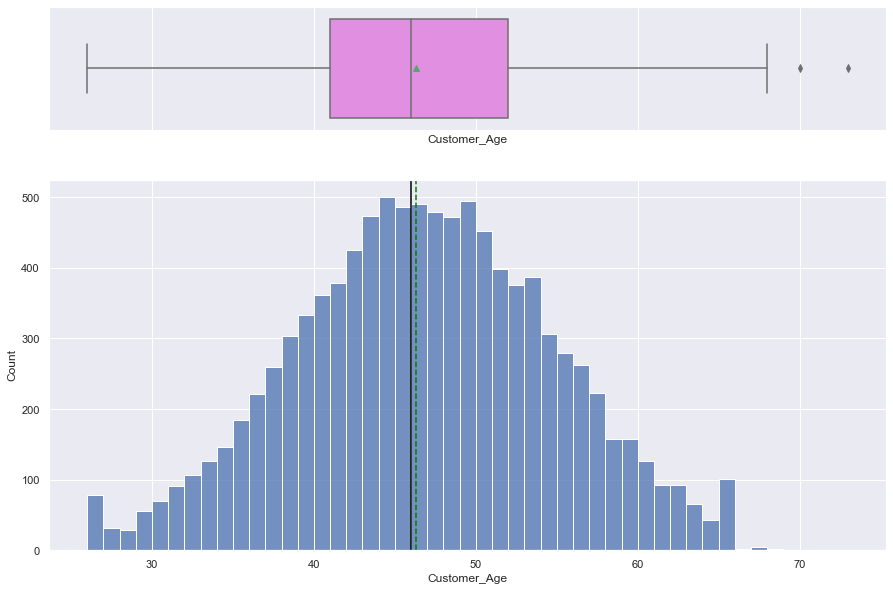

In [13]:
histogram_boxplot(df.Customer_Age)

* Data have a fairly normal distribution. There are some peaks in the histogram on the lowest and 3rd highest values, perhaps some of the values have been clipped previously?
* There are two outlier points, it's not uncommon for some people to live longer than others, so I believe these points are real data. Let's take a look at the outliers.

In [14]:
df[df["Customer_Age"]>69]

Attrition_Flag  Customer_Age Gender  Dependent_count Education_Level  \
251  Existing Customer            73      M                0     High School   
254  Existing Customer            70      M                0     High School   

    Marital_Status Income_Category Card_Category  Months_on_book  \
251        Married     $40K - $60K          Blue              36   
254        Married  Less than $40K          Blue              56   

     Total_Relationship_Count  Months_Inactive_12_mon  Contacts_Count_12_mon  \
251                         5                       3                      2   
254                         3                       2                      3   

     Credit_Limit  Total_Revolving_Bal  Avg_Open_To_Buy  Total_Amt_Chng_Q4_Q1  \
251        4469.0                 1125           3344.0                 1.363   
254        3252.0                 1495           1757.0                 0.581   

     Total_Trans_Amt  Total_Trans_Ct  Total_Ct_Chng_Q4_Q1  \
251             1765              34                1.615   
254             1227              15                0.875   

     Avg_Utilization_Ratio  
251                  0.252  
254                  0.460

* Nothing looks off here. The two entries are fairly close in the index (251 and 254), it could just be a coincidence. We will not treat these values as they are likely real data.

### Observations on Dependent Count

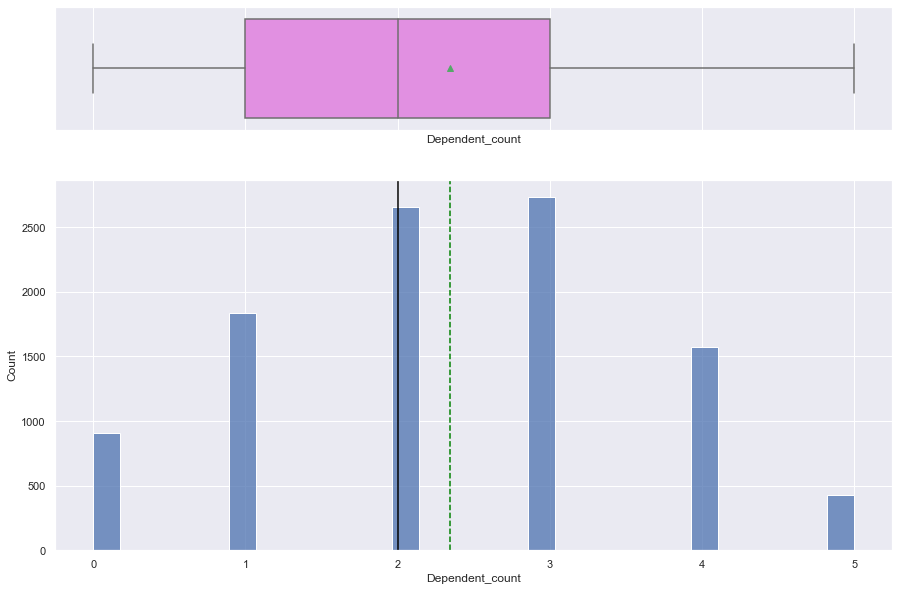

In [15]:
histogram_boxplot(df.Dependent_count)

* Data are fairly normally distributed, with slightly more values in the lower half 0-2 than the upper half 3-5.

### Observations on Months on Book

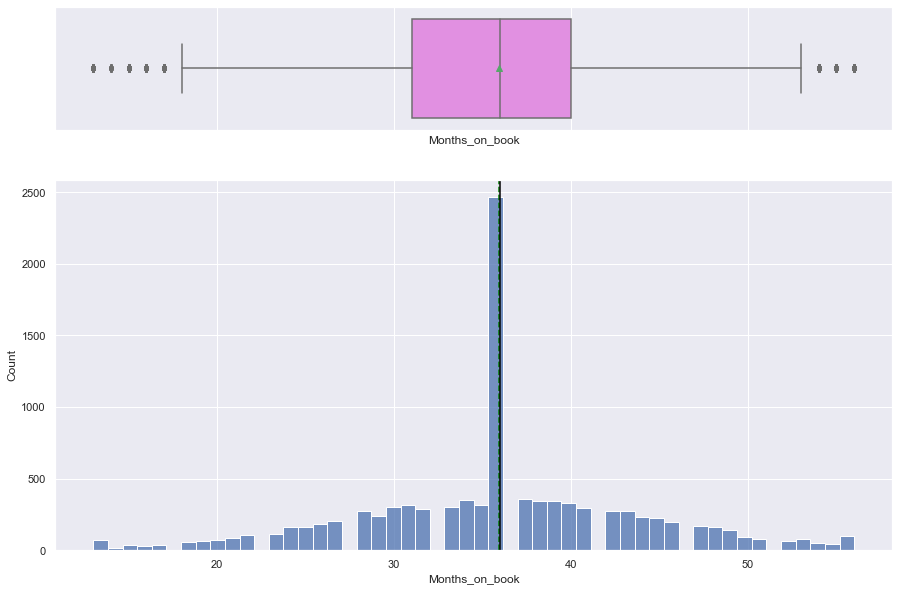

In [16]:
histogram_boxplot(df.Months_on_book)

* These data look very strange. This looks like a normal distribution with a high standard deviation, only there are gaps in the deviation and a massive spike in the data at 36 months on the books. 36 months is exactly 3 years. Perhaps if the Months_on_book values was unknown, it was filled with 36 months? If I was able to go back to the source and ask about this I would. Let's look at these values:

In [17]:
df[df["Months_on_book"]==36].sample(20) # a random sample where Months_on_book = 36

Attrition_Flag  Customer_Age Gender  Dependent_count Education_Level  \
3679  Existing Customer            47      M                3      Uneducated   
3895  Existing Customer            52      M                0      Uneducated   
3031  Existing Customer            32      M                1     High School   
2258  Existing Customer            35      F                1      Uneducated   
9715  Existing Customer            50      F                1        Graduate   
4371  Existing Customer            52      M                3        Graduate   
9478  Existing Customer            52      M                2         College   
3322  Existing Customer            40      M                2        Graduate   
9202  Existing Customer            44      M                2        Graduate   
7984  Existing Customer            47      F                1     High School   
6263  Existing Customer            47      F                4      Uneducated   
6343  Existing Customer            46      M                4     High School   
7061  Existing Customer            48      M                5         Unknown   
8186  Attrited Customer            44      F                1     High School   
1451  Existing Customer            33      F                2         College   
178   Existing Customer            57      F                2      Uneducated   
827   Existing Customer            46      F                4        Graduate   
2625  Existing Customer            36      M                2        Graduate   
9341  Existing Customer            48      M                2     High School   
4023  Existing Customer            44      F                4      Uneducated   

     Marital_Status Income_Category Card_Category  Months_on_book  \
3679         Single    $80K - $120K          Blue              36   
3895        Unknown    $80K - $120K          Blue              36   
3031         Single     $60K - $80K          Blue              36   
2258        Married  Less than $40K          Blue              36   
9715         Single         Unknown          Blue              36   
4371         Single     $60K - $80K          Blue              36   
9478        Married    $80K - $120K          Blue              36   
3322        Married    $80K - $120K          Blue              36   
9202        Married    $80K - $120K          Blue              36   
7984         Single         Unknown          Blue              36   
6263         Single  Less than $40K          Blue              36   
6343         Single     $60K - $80K          Blue              36   
7061        Unknown     $60K - $80K          Blue              36   
8186         Single  Less than $40K          Blue              36   
1451         Single         Unknown          Gold              36   
178          Single     $40K - $60K        Silver              36   
827          Single         Unknown          Blue              36   
2625        Married     $60K - $80K          Blue              36   
9341        Married  Less than $40K        Silver              36   
4023        Married  Less than $40K        Silver              36   

      Total_Relationship_Count  Months_Inactive_12_mon  Contacts_Count_12_mon  \
3679                         5                       3                      2   
3895                         6                       4                      4   
3031                         4                       2                      2   
2258                         3                       2                      4   
9715                         3                       2                      2   
4371                         4                       2                      2   
9478                         1                       2                      2   
3322                         6                       1                      3   
9202                         2                       2                      2   
7984                         2                 

* There does not appear to be a pattern to these customers, other than the fact that they all have 36 Months_on_book.

In [18]:
df[df["Months_on_book"]==36].shape

(2463, 20)

* There are 2463 entries, 24.3% of total data, that have Months_on_book = 36. This column is so heavily biased towards a single value that it might be a useless, or worse, harmful column. I will consider dropping it.

### Observations on Total Relationship Count

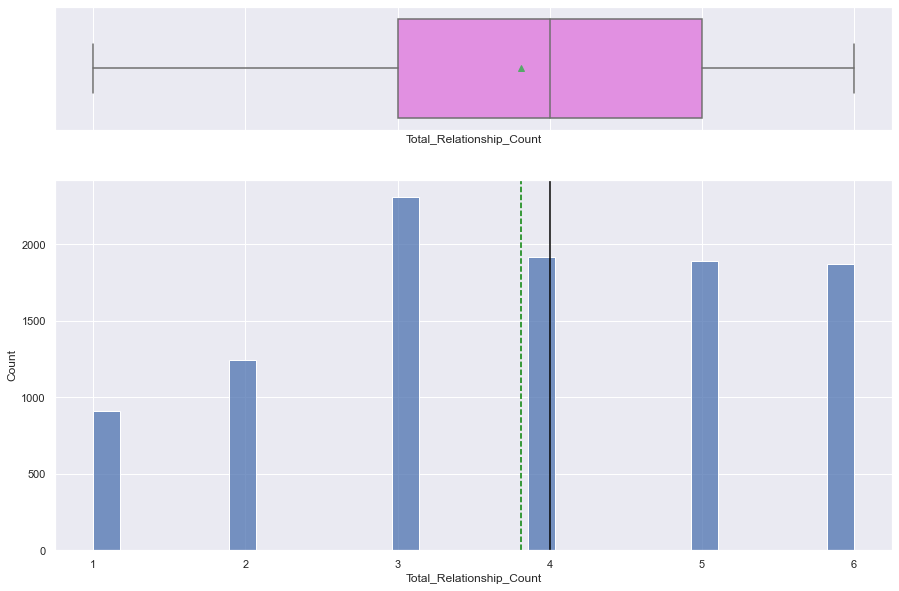

In [19]:
histogram_boxplot(df.Total_Relationship_Count)

* The mode here is 3, mean and median are 4.
* While the mode is 3 there are more values in the upper half 4-6 than the lower half 1-3

### Observations on Months Inactive 12 mon

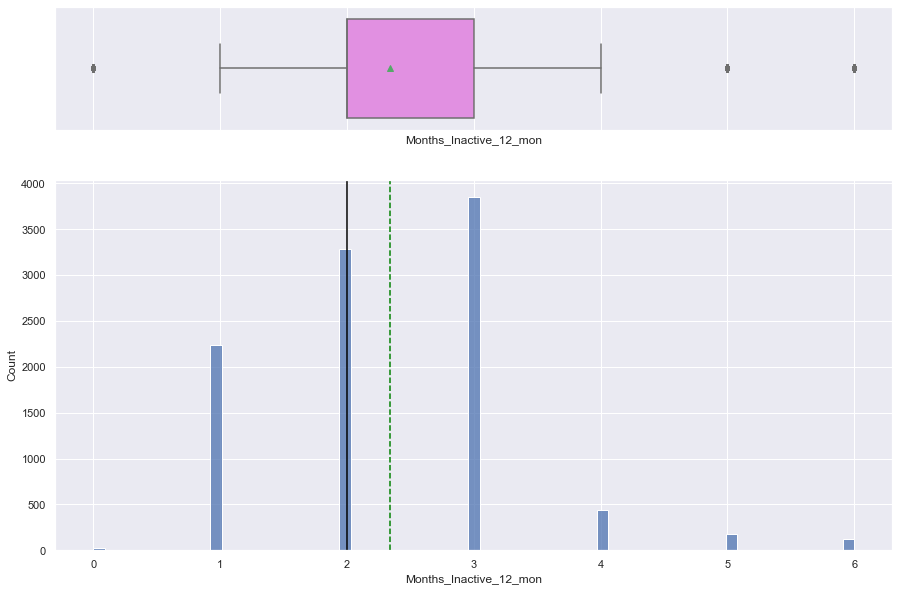

In [20]:
histogram_boxplot(df.Months_Inactive_12_mon)

* The box plot shows outliers, however, given that this variable straddles the line between continuous variable and categorical variable, I'm not concerned about outliers here. i.e. we will not treat outliers in this column.
* This variable represents "Number of months inactive in the last 12 months". I assume this is inactivity with the credit card. It seems that most customers are not using the credit card every month as there are very few customers with a value of zero months inactive.

In [21]:
# We will look at the extremes and see if we can find out what this feature actually represents
df[df["Months_Inactive_12_mon"]==0].sample(10) 

Attrition_Flag  Customer_Age Gender  Dependent_count Education_Level  \
2671  Attrited Customer            49      M                3   Post-Graduate   
6605  Existing Customer            47      F                2       Doctorate   
2126  Attrited Customer            46      F                3     High School   
6470  Existing Customer            35      F                1     High School   
4302  Attrited Customer            50      F                1     High School   
6474  Existing Customer            37      M                3      Uneducated   
6647  Existing Customer            46      F                4        Graduate   
6110  Existing Customer            41      F                3         College   
9633  Attrited Customer            59      F                1     High School   
29    Existing Customer            47      M                4     High School   

     Marital_Status Income_Category Card_Category  Months_on_book  \
2671        Married    $80K - $120K          Blue              45   
6605         Single  Less than $40K          Blue              37   
2126         Single  Less than $40K        Silver              39   
6470        Married  Less than $40K          Blue              28   
4302         Single         Unknown          Blue              42   
6474        Married     $40K - $60K          Blue              25   
6647         Single         Unknown          Blue              42   
6110         Single     $40K - $60K          Blue              22   
9633         Single  Less than $40K          Blue              50   
29          Married     $40K - $60K          Blue              42   

      Total_Relationship_Count  Months_Inactive_12_mon  Contacts_Count_12_mon  \
2671                         3                       0                      4   
6605                         3                       0                      1   
2126                         1                       0                      4   
6470                         6                       0                      2   
4302                         5                       0                      4   
6474                         5                       0                      3   
6647                         4                       0                      3   
6110                         5                       0                      2   
9633                         1                       0                      3   
29                           6                       0                      0   

      Credit_Limit  Total_Revolving_Bal  Avg_Open_To_Buy  \
2671       23870.0                    0          23870.0   
6605        4254.0                 1204           3050.0   
2126       13092.0                 1962          11130.0   
6470        1438.3                  977            461.3   
4302       10057.0                    0          10057.0   
6474        1438.3                    0           1438.3   
6647       13376.0                 1633          11743.0   
6110        2577.0                 1582            995.0   
9633        4085.0                    0           4085.0   
29          4785.0                 1362           3423.0   

      Total_Amt_Chng_Q4_Q1  Total_Trans_Amt  Total_Trans_Ct  \
2671                 0.604             1885              39   
6605                 0.538             5385              93   
2126                 0.686              936              25   
6470                 1.189             4840              85   
4302                 0.792             2383              42   
6474                 1.023             5046              77   
6647                 0.980             4515              63   
6110                 0.697             4734              75   
9633                 0.787             7597              71   
29                   0.739             1045              38   

      Total_Ct_Chng_Q4_Q1  Avg_Utilization_Ratio  
2671                0.345                  0.000  
6605    

In [22]:
df[df["Months_Inactive_12_mon"]==6].sample(10) 

Attrition_Flag  Customer_Age Gender  Dependent_count Education_Level  \
4749  Existing Customer            50      M                2     High School   
884   Existing Customer            61      M                1        Graduate   
6585  Existing Customer            41      F                3         Unknown   
8235  Existing Customer            45      F                3       Doctorate   
8200  Attrited Customer            53      F                1        Graduate   
740   Existing Customer            41      M                4         Unknown   
9499  Existing Customer            51      F                2         Unknown   
7065  Attrited Customer            62      M                0         College   
3970  Existing Customer            41      F                3        Graduate   
9387  Existing Customer            53      M                1     High School   

     Marital_Status Income_Category Card_Category  Months_on_book  \
4749        Married         $120K +          Blue              38   
884         Unknown    $80K - $120K          Blue              52   
6585        Married  Less than $40K          Blue              34   
8235         Single  Less than $40K          Blue              27   
8200         Single  Less than $40K          Blue              48   
740         Married  Less than $40K          Blue              30   
9499        Married  Less than $40K          Blue              46   
7065        Unknown     $40K - $60K          Blue              56   
3970        Married  Less than $40K          Blue              36   
9387        Married         $120K +          Gold              44   

      Total_Relationship_Count  Months_Inactive_12_mon  Contacts_Count_12_mon  \
4749                         5                       6                      0   
884                          6                       6                      1   
6585                         3                       6                      2   
8235                         1                       6                      3   
8200                         6                       6                      3   
740                          4                       6                      1   
9499                         1                       6                      3   
7065                         2                       6                      2   
3970                         6                       6                      4   
9387                         1                       6                      3   

      Credit_Limit  Total_Revolving_Bal  Avg_Open_To_Buy  \
4749       10747.0                 1027           9720.0   
884         8851.0                    0           8851.0   
6585        2679.0                 2214            465.0   
8235        2917.0                 1523           1394.0   
8200        2370.0                 1166           1204.0   
740         2450.0                 1967            483.0   
9499        7744.0                 1893           5851.0   
7065        3477.0                    0           3477.0   
3970        2873.0                 1247           1626.0   
9387       34516.0                  831          33685.0   

      Total_Amt_Chng_Q4_Q1  Total_Trans_Amt  Total_Trans_Ct  \
4749                 0.925             4538              63   
884                  0.731             1257              36   
6585                 1.036             4682              81   
8235                 0.724             4878              92   
8200                 0.562             2164              45   
740                  0.589             1263              29   
9499                 0.813            16059             124   
7065                 0.436             2113              40   
3970                 0.889             3943              80   
9387                 0.727            13247             107   

      Total_Ct_Chng_Q4_Q1  Avg_Utilization_Ratio  
4749                0.658                  0.096  
884     

* At both extreme values we have both Existing Customers and Attrited Customers
* There are more Total_Revolving_Bal = 0 entries for customers with zero months inactive. Perhpas these are customers who use their credit card all the time and pay off the balance every month.

### Observations on Contacts Count 12 mon

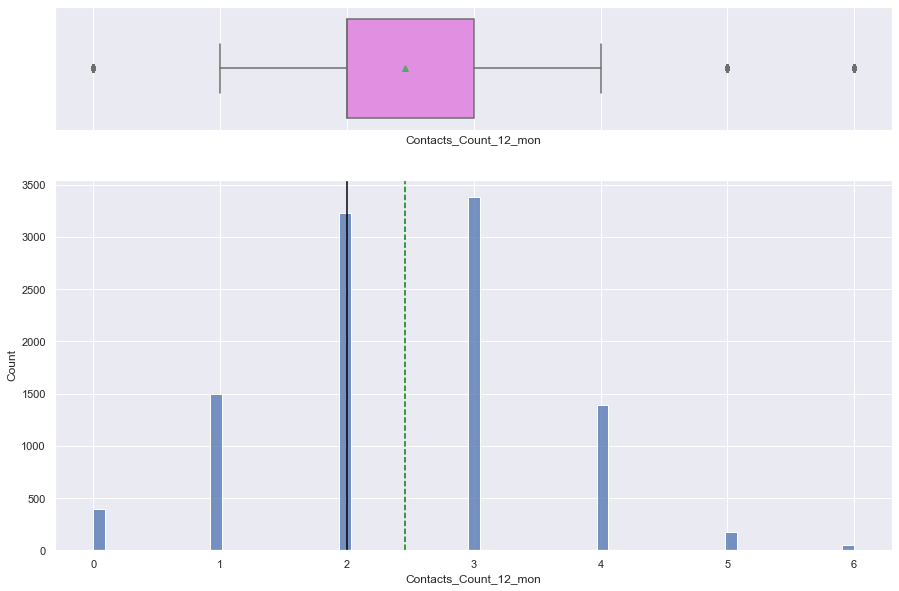

In [23]:
histogram_boxplot(df.Contacts_Count_12_mon)

* These data have a fairly normal distribution.
* There are some outliters; again, these data straddle the line between continuous variable and categorical variable. I belive the outliers are real data and there is no need to treat them.

### Observations on Credit_Limit

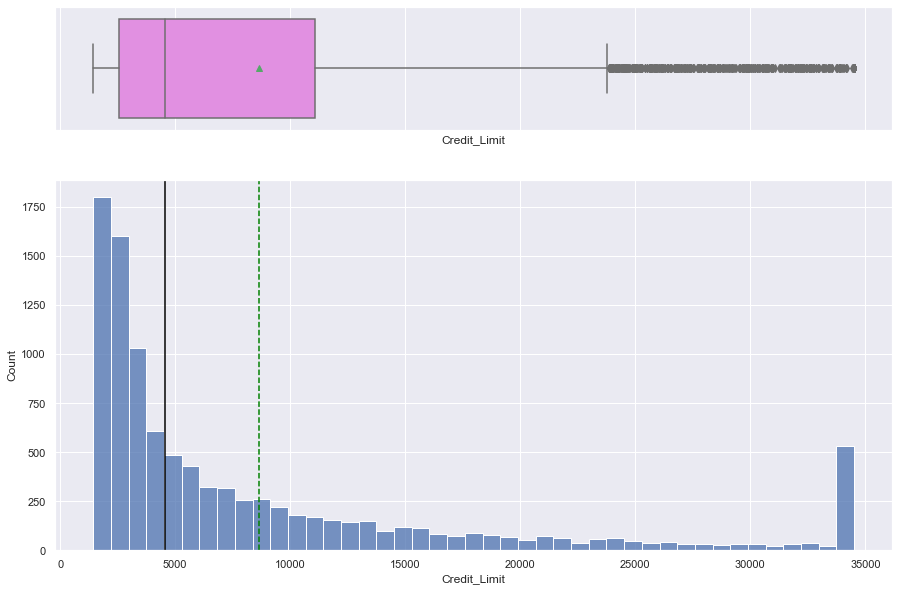

In [24]:
histogram_boxplot(df.Credit_Limit)

* We expect a feature like Credit Limit to be right skewed. Most people make a little, few people make a lot.
* It is strange that there are so many customers with the maximum value (34516) perhaps the bank only offers credit cards up to this value and that is why there is a strange cap? Again, it would be nice to ask the source. We don't have that luxury here so let's explore further.

In [25]:
df[df["Credit_Limit"]==34516.0].shape

(508, 20)

* There are 508 customers with the 34516 credit limit. 5% of the data.

In [26]:
df[df["Credit_Limit"]==34516.0].sample(20) # Look at a random sample of customers with maximum credit limit.

Attrition_Flag  Customer_Age Gender  Dependent_count Education_Level  \
4718  Attrited Customer            45      M                5         Unknown   
260   Existing Customer            36      M                2         College   
9004  Existing Customer            47      M                3        Graduate   
124   Existing Customer            55      M                2         College   
2411  Attrited Customer            48      M                3      Uneducated   
9397  Existing Customer            51      M                1        Graduate   
9961  Existing Customer            54      M                2         College   
9552  Attrited Customer            39      M                2         Unknown   
9846  Attrited Customer            52      M                3       Doctorate   
4487  Attrited Customer            46      F                3     High School   
8977  Existing Customer            38      M                2      Uneducated   
9559  Existing Customer            53      M                1         College   
2724  Existing Customer            48      M                4        Graduate   
9699  Existing Customer            31      M                0        Graduate   
2772  Existing Customer            37      M                4        Graduate   
4082  Existing Customer            49      M                1     High School   
1578  Existing Customer            45      M                3        Graduate   
237   Existing Customer            44      M                3        Graduate   
8078  Existing Customer            53      M                3        Graduate   
5003  Attrited Customer            49      M                4         Unknown   

     Marital_Status Income_Category Card_Category  Months_on_book  \
4718        Married    $80K - $120K        Silver              39   
260         Unknown    $80K - $120K          Blue              22   
9004        Married         $120K +        Silver              42   
124          Single         $120K +        Silver              42   
2411        Married         $120K +          Blue              36   
9397        Married         $120K +          Gold              37   
9961        Married    $80K - $120K        Silver              39   
9552        Married         $120K +          Blue              36   
9846        Married         $120K +          Blue              45   
4487         Single         Unknown        Silver              36   
8977         Single    $80K - $120K          Blue              22   
9559        Married    $80K - $120K        Silver              36   
2724        Married    $80K - $120K        Silver              40   
9699         Single     $60K - $80K        Silver              24   
2772         Single         $120K +          Blue              28   
4082        Married    $80K - $120K        Silver              37   
1578        Married    $80K - $120K        Silver              36   
237         Unknown    $80K - $120K          Blue              33   
8078         Single    $80K - $120K        Silver              39   
5003         Single         $120K +          Blue              38   

      Total_Relationship_Count  Months_Inactive_12_mon  Contacts_Count_12_mon  \
4718                         2                       2                      3   
260                          2                       2                      3   
9004                         1                       3                      1   
124                          2                       3                      2   
2411                         5                       2                      4   
9397                         2                       3                      1   
9961                         4                       1                      4   
9552                         6                       3                      3   
9846                         1                       3                      3   
4487                         4                 

* Most of the entires here belong to the highest Income Categories, which makes sense.
* While there are a more females than males in the data frame, it does appear that more males have the highest credit limit. (see next cell).
* These entries do not look false, or out of the ordinary in any way. So perhaps the large number of entries with the maximum credit limit value is either because a) the bank caps the value or b) someone collecting the data capped the value.

In [27]:
df[df["Credit_Limit"]==34516.0]['Gender'].value_counts()

M    468
F     40
Name: Gender, dtype: int64

### Observations on Total_Revolving_Bal

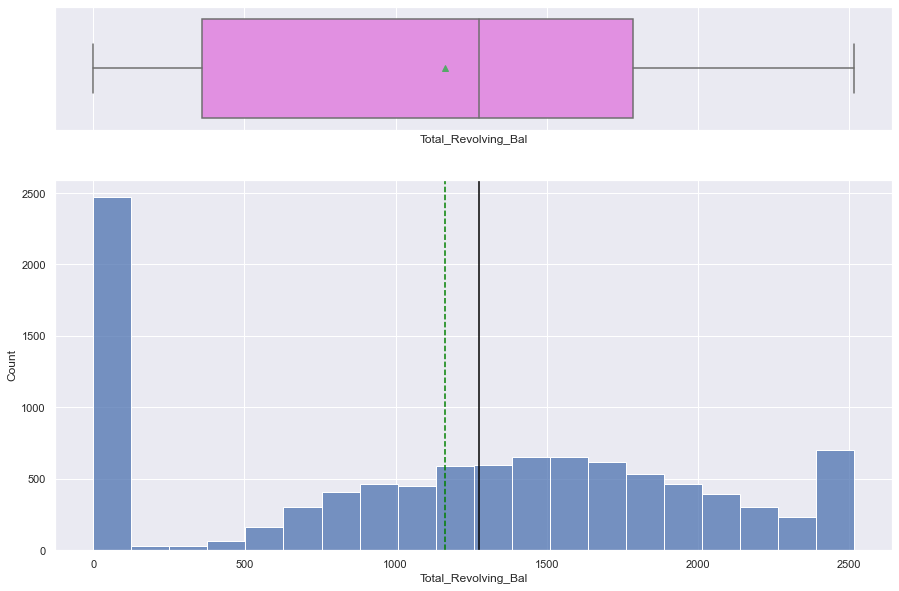

In [28]:
histogram_boxplot(df.Total_Revolving_Bal)

* There are a large number of customers who fully pay their credit card and have a zero total revolving balance.
* The remainder of the values are fairly normally distibuted with a slightly weighting to the right.
* There are again a large number of entries at the maximum value of 2517. Again, perhaps the data were capped in some way in the past?

### Observations on Avg_Open_To_Buy

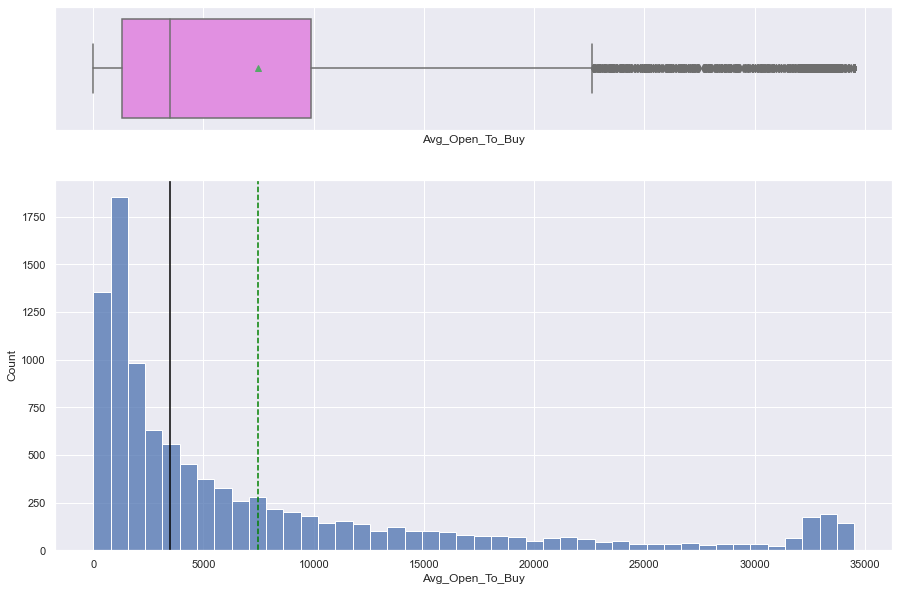

In [29]:
histogram_boxplot(df.Avg_Open_To_Buy)

* Given that Credit Limit is right skewed, we expect this feature to also be right skewed, and it is.
* We again see the larger-than-expected amount of entries near the maximum value, this appears to be a quirk of this data set.
* We will attempt to treat the skewness of these variables before input into our models.

### Observations on Total_Trans_Amt

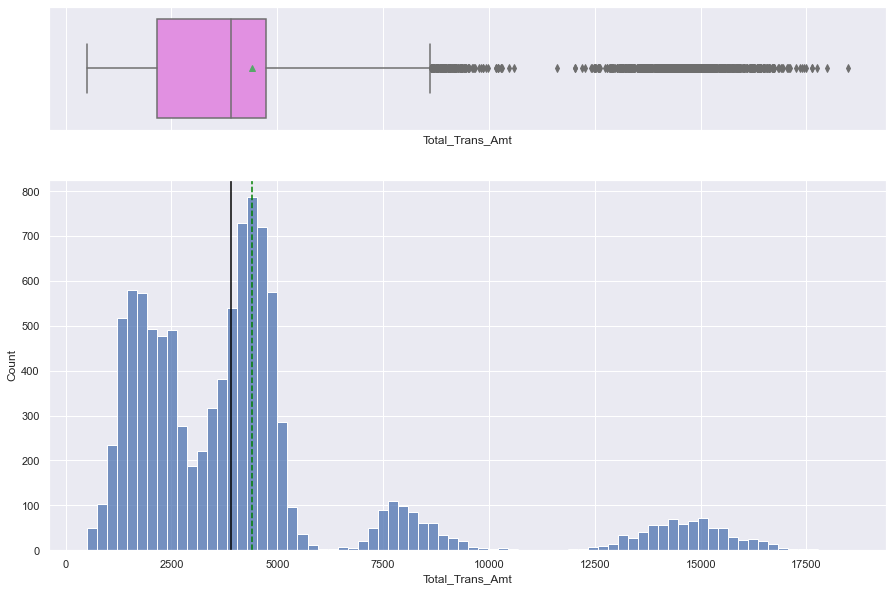

In [30]:
histogram_boxplot(df.Total_Trans_Amt)

* These data appear to be 4 normal distributions. The bulk of data lie in the left 2 distributions, there are a lot of outliers that sit in the 2 right distributions. 
* We could split this variable into 4 categories and separating out the right two distributions would be easy. Separating the left two distributions is more challenging. As the bulk of the models that we will try are based on decision trees, it might be better to let the algorithm make the splits, rather than splitting the variable ourselves.

### Observations on Total_Trans_Ct

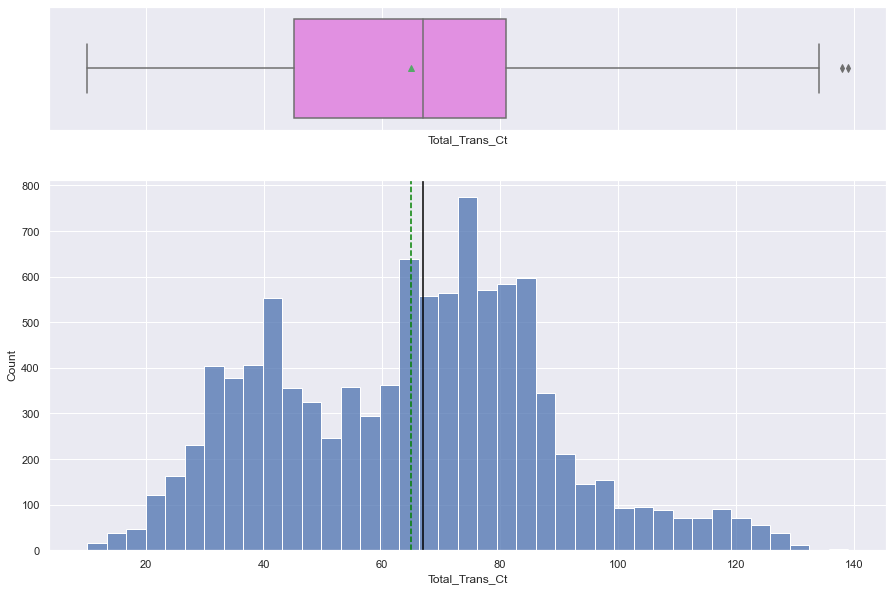

In [31]:
histogram_boxplot(df.Total_Trans_Ct)

* The data are bi-modal.
* There are 2 outliers, let's look at them now

In [32]:
df[df['Total_Trans_Ct']>135]

Attrition_Flag  Customer_Age Gender  Dependent_count Education_Level  \
9324  Existing Customer            41      M                3         Unknown   
9586  Existing Customer            56      F                1     High School   

     Marital_Status Income_Category Card_Category  Months_on_book  \
9324        Married         $120K +          Blue              33   
9586        Married         Unknown          Blue              49   

      Total_Relationship_Count  Months_Inactive_12_mon  Contacts_Count_12_mon  \
9324                         2                       4                      3   
9586                         1                       2                      1   

      Credit_Limit  Total_Revolving_Bal  Avg_Open_To_Buy  \
9324       34516.0                  638          33878.0   
9586       17542.0                 2517          15025.0   

      Total_Amt_Chng_Q4_Q1  Total_Trans_Amt  Total_Trans_Ct  \
9324                 0.724            13085             139   
9586                 0.800            13939             138   

      Total_Ct_Chng_Q4_Q1  Avg_Utilization_Ratio  
9324                0.675                  0.018  
9586                0.792                  0.143

* It is strange that customer in row 9324 has a Total Transaction Count of 139 AND has been inactive 4 months in the last 12 (Months_Inactive_12_mon = 4). In only 8 months he has made more transactions than any other customer in the data base.
* Both customers have more than 2 years on the book and the Total_Ct_Chng_Q4_Q1 is within the normal range (within Q1-Q3) so they are outliers but their behaviour doesn't appear to have changed radically. Consistency of behaviour is an indication that a data point is real.
* Given that both the outliers belong to the majority class, I could just drop them. However, I think that the data are real and don't want to just drop data. I will likely be scaling this variable so it should treat the outliers somewhat.

### Observations on Total_Ct_Chng_Q4_Q1

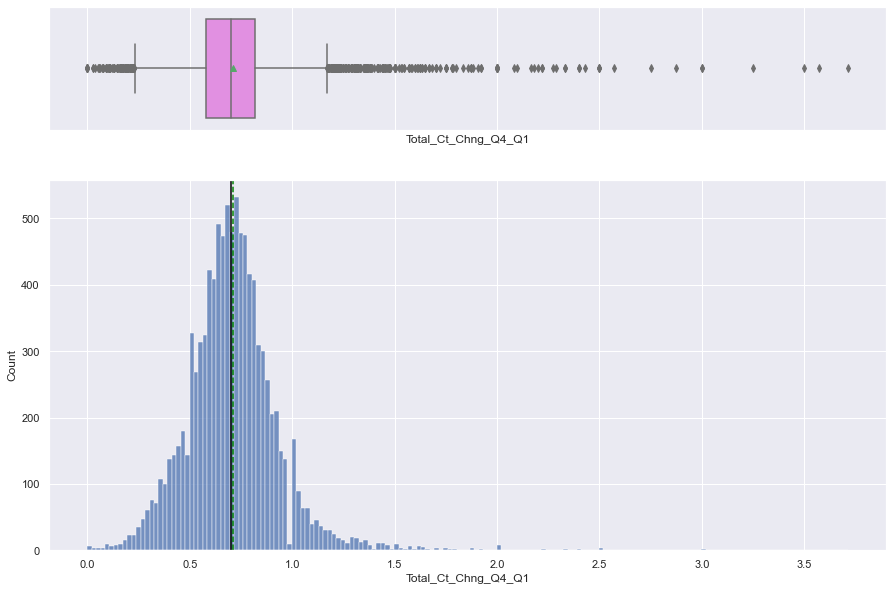

In [33]:
histogram_boxplot(df.Total_Ct_Chng_Q4_Q1)

* The bulk of the data have a normal distribution
* There are long 'tails' on the distribution, especially on the high side. Let's look at the outliers on the high side.

In [34]:
df[df['Total_Ct_Chng_Q4_Q1']>2.5]

Attrition_Flag  Customer_Age Gender  Dependent_count Education_Level  \
1    Existing Customer            49      F                5        Graduate   
12   Existing Customer            56      M                1         College   
30   Existing Customer            53      M                3         Unknown   
113  Existing Customer            54      F                0      Uneducated   
146  Existing Customer            41      F                2        Graduate   
190  Existing Customer            57      M                1        Graduate   
269  Existing Customer            54      M                5        Graduate   
366  Existing Customer            36      F                4        Graduate   
773  Existing Customer            61      M                0   Post-Graduate   

    Marital_Status Income_Category Card_Category  Months_on_book  \
1           Single  Less than $40K          Blue              44   
12          Single    $80K - $120K          Blue              36   
30         Married    $80K - $120K          Blue              33   
113        Married  Less than $40K          Blue              36   
146         Single  Less than $40K          Blue              32   
190        Married    $80K - $120K          Blue              47   
269        Married     $60K - $80K          Blue              38   
366        Married     $40K - $60K          Blue              36   
773        Married         Unknown          Blue              53   

     Total_Relationship_Count  Months_Inactive_12_mon  Contacts_Count_12_mon  \
1                           6                       1                      2   
12                          3                       6                      0   
30                          3                       2                      3   
113                         2                       2                      2   
146                         6                       3                      2   
190                         5                       3                      1   
269                         3                       3                      3   
366                         6                       3                      3   
773                         6                       2                      3   

     Credit_Limit  Total_Revolving_Bal  Avg_Open_To_Buy  Total_Amt_Chng_Q4_Q1  \
1          8256.0                  864           7392.0                 1.541   
12        11751.0                    0          11751.0                 3.397   
30         2753.0                 1811            942.0                 0.977   
113        1494.0                  706            788.0                 1.674   
146        2250.0                 2117            133.0                 1.162   
190       14612.0                 1976          12636.0                 1.768   
269        2290.0                 1434            856.0                 0.923   
366        1628.0                  969            659.0                 0.999   
773       14434.0                 1927          12507.0                 2.675   

     Total_Trans_Amt  Total_Trans_Ct  Total_Ct_Chng_Q4_Q1  \
1               1291              33                3.714   
12              1539              17                3.250   
30              1038              25                2.571   
113             1305              24                3.000   
146             1617              31                2.875   
190             1827              24                3.000   
269             1119              18                3.500   
366             1893              15                2.750   
773             1731              32                3.571   

     Avg_Utilization_Ratio  
1                    0.105  
12                   0.000  
30                   0.658  
113                  0.473  
146                  0.941  
190                  0.135  
269                  0.626  
366                  0.595  
773                  0.134

* All the customers are existing customers with a Blue Card_Category.
* About half of the customers are also outliers in the Total_Amt_Chng_Q4_Q1, and the rest are above average. This makes sense.
* The data look real; none of the outliers are so far away from other points that they look like data entry mistakes and all other columns look normal for these rows.

### Observations on Total_Amt_Chng_Q4_Q1

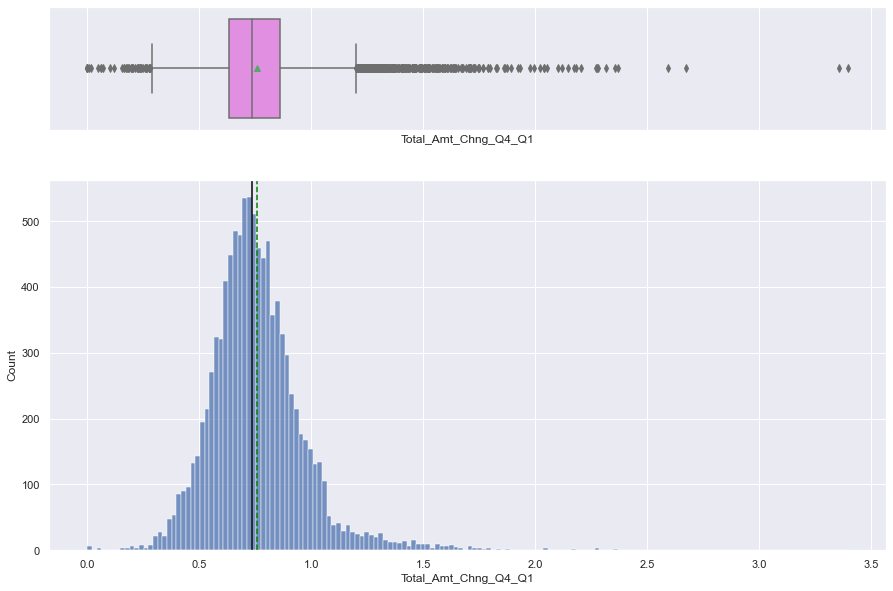

In [35]:
histogram_boxplot(df.Total_Amt_Chng_Q4_Q1)

* We expect this column to look similar to, and be highly correlated with, Total_Ct_Chng_Q4_Q1 as more transanctions on a credit card usually means more money spent. Indeed the distribution of this column and the Total_Ct_Chng_Q4_Q1 column do look similar.
* This time there are 4 outliers that sit a long way from the other data. Let's look at those now.

In [36]:
df[df['Total_Amt_Chng_Q4_Q1']>2.5]

Attrition_Flag  Customer_Age Gender  Dependent_count Education_Level  \
2    Existing Customer            51      M                3        Graduate   
8    Existing Customer            37      M                3      Uneducated   
12   Existing Customer            56      M                1         College   
773  Existing Customer            61      M                0   Post-Graduate   

    Marital_Status Income_Category Card_Category  Months_on_book  \
2          Married    $80K - $120K          Blue              36   
8           Single     $60K - $80K          Blue              36   
12          Single    $80K - $120K          Blue              36   
773        Married         Unknown          Blue              53   

     Total_Relationship_Count  Months_Inactive_12_mon  Contacts_Count_12_mon  \
2                           4                       1                      0   
8                           5                       2                      0   
12                          3                       6                      0   
773                         6                       2                      3   

     Credit_Limit  Total_Revolving_Bal  Avg_Open_To_Buy  Total_Amt_Chng_Q4_Q1  \
2          3418.0                    0           3418.0                 2.594   
8         22352.0                 2517          19835.0                 3.355   
12        11751.0                    0          11751.0                 3.397   
773       14434.0                 1927          12507.0                 2.675   

     Total_Trans_Amt  Total_Trans_Ct  Total_Ct_Chng_Q4_Q1  \
2               1887              20                2.333   
8               1350              24                1.182   
12              1539              17                3.250   
773             1731              32                3.571   

     Avg_Utilization_Ratio  
2                    0.000  
8                    0.113  
12                   0.000  
773                  0.134

* Of these customers (rows 2, 8, 12, 773) rows 12 and 773 are also an outliers in the Total_Ct_Chng_Q4_Q1 column. We expect outliers in one to also be outliers in the other.
* Again all outliers are existing customers and have the Blue Card_Category. Rows 2, 8 and 12 also have the 36 Months_on_book value, which we saw was a strange value in that column.
* Rows 8 and 12 have values in this column which sit a long way from the other data (above 3), so it's likely that they are erroneous data.
* As there are only 4 outliers (data that sit a long way from all other data, not outliers according to the boxplot), I will clip them to the next highest value (2.36)

In [37]:
df["Total_Amt_Chng_Q4_Q1"].clip(upper=2.36, inplace=True)

### Observations on Avg_Utilization_Ratio

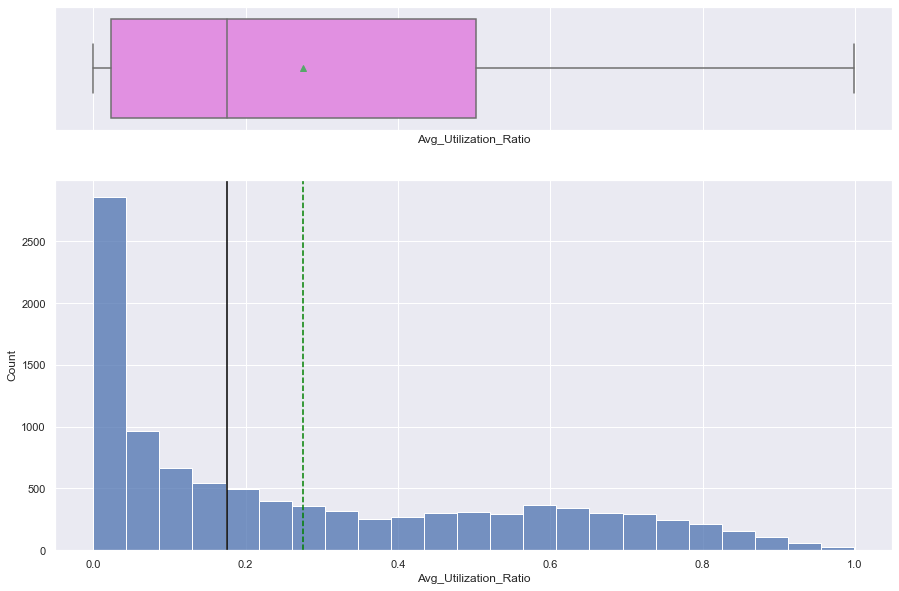

In [38]:
histogram_boxplot(df.Avg_Utilization_Ratio)

* There are a large number of zero values, these are customers who have paid off their credit card and also have a Total_Revolving_Bal of zero.
* The remaining data are skewed to the right

## Univariate Analysis - Categorical Variables

In [39]:
# Write some code to plot categorical variables with the percentage on the bar.
def perc_on_bar(feature):
    """
    plot
    feature: categorical feature
    the function won't work if a column is passed in the hue parameter
    """
    # Creating a countplot for the feature
    sns.set(rc={"figure.figsize": (10, 5)})
    ax = sns.countplot(x=feature, data=df)

    total = len(feature)  # length of the column
    for p in ax.patches:
        percentage = "{:.1f}%".format(
            100 * p.get_height() / total
        )  # percentage of each class of the category
        x = p.get_x() + p.get_width() / 2 - 0.1  # width of the plot
        y = p.get_y() + p.get_height()  # hieght of the plot
        ax.annotate(percentage, (x, y), size=14)  # annotate the percantage

    plt.show()  # show the plot

### Observations on Attrition_Flag

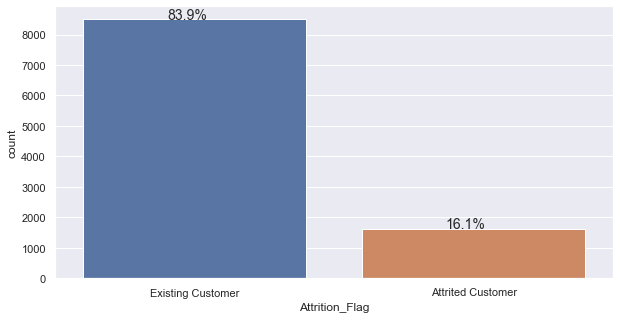

In [40]:
perc_on_bar(df["Attrition_Flag"])

* This is our target variable.
* Only 16% of the customers in the data frame are Attrited, so the target class is unbalanced.

### Observations on Gender

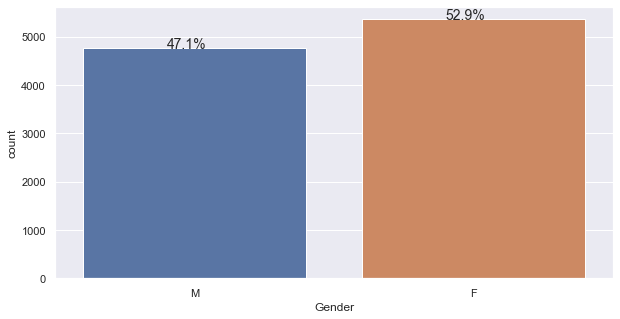

In [41]:
perc_on_bar(df["Gender"])

* Slightly more of the customers in the data set are Female

### Observations on Education_Level

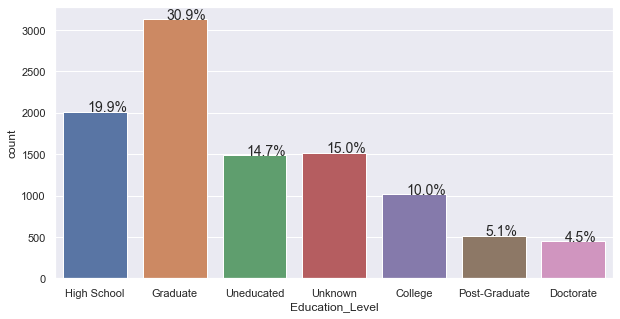

In [42]:
perc_on_bar(df["Education_Level"])

* The most common education level is Graduate, followed by High School.
* There are a large number of customers where the education level is Unknown. If we treated these as nulls and then used the mode value to impute the missing values, we would unbalance the data by adding a lot of entries into the Graduate class. For now, we will treat Unknown as its own category.
* There is clearly an order to the categories: Uneducated, High School, College, Graduate, Post-Graduate, Doctorate. We can use this order to encode this variable for our ML models.

### Observations on Marital_Status

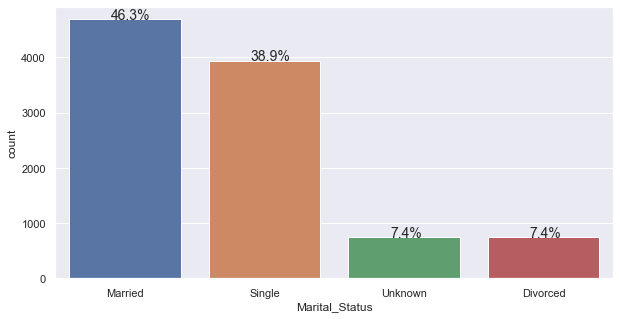

In [43]:
perc_on_bar(df["Marital_Status"])

* The most common marital status is Married. Single is the second most common, with Divorced being much less common.
* There are a large number of customers where the marital status is Unknown. If we treated these as nulls and used the mode to impute the missing values we would again add many data points to the Married class. We will again treat Unknown as its own categrory for now.

### Observations on Income_Category

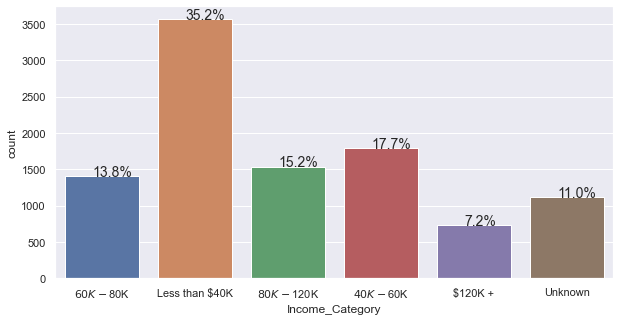

In [44]:
perc_on_bar(df["Income_Category"])

* The most common income category is less than \\$40K, the others are fairly balanced around 15%, with \\$120+ being lower at only 7%
* Again, we have the problem of a fairly large percentage of customers having "Unknown" as their income category. Again, we will treat this as it's own category for now.
* There is a clear order to the categories based on income, we can use this to encode this variable for our ML models.

### Observations on Card_Category

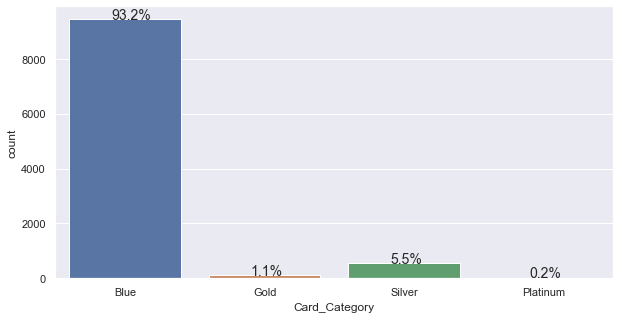

In [45]:
perc_on_bar(df["Card_Category"])

* The vast majority of customers fit into the Blue card category. Only a small percentage of customers have a different card Category.

## Bi-variate Analysis

### Cross Correlation Heat Map

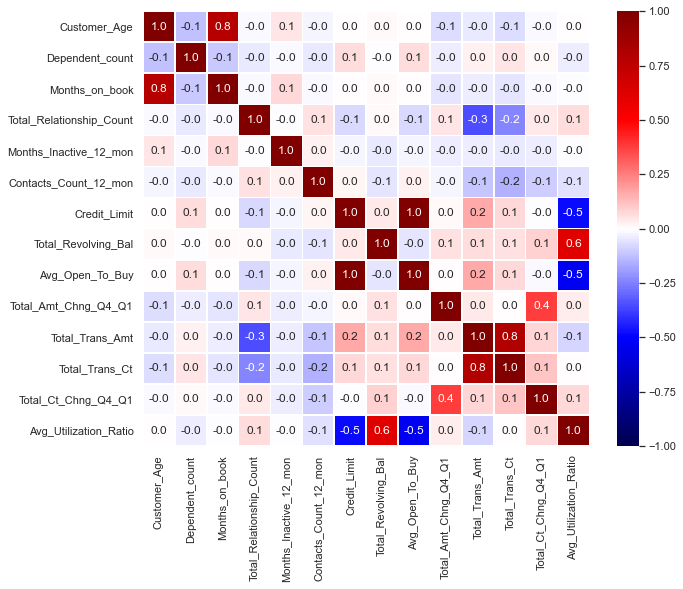

In [46]:
# Let's start by looking for correlation in the data
corr = df.corr()

sns.set(font_scale=1)
fix, ax = plt.subplots(figsize=(10,8))
sns.heatmap(corr, 
            cmap='seismic', annot=True,fmt=".1f",vmin=-1, vmax=1, center= 0,
            square=False, linewidths=.7);

#### Observations
* Age and Months_on_book are highly correlated. 
* Credit_Limit and Avg_Open_To_Buy are perfectly correlated.
* There is  a negative correlation between Avg_Utilization_Ratio and Credit_Limit
* There is the same negative correlation between Avg_Open_To_Buy and Credit_Limit.
* We also see a correlation between Total_Amt_Chng_Q4_Q1 and Total_Ct_Chng_Q4_Q1.

### Continuous Variables vs. Target Variable
### Pair-Plots

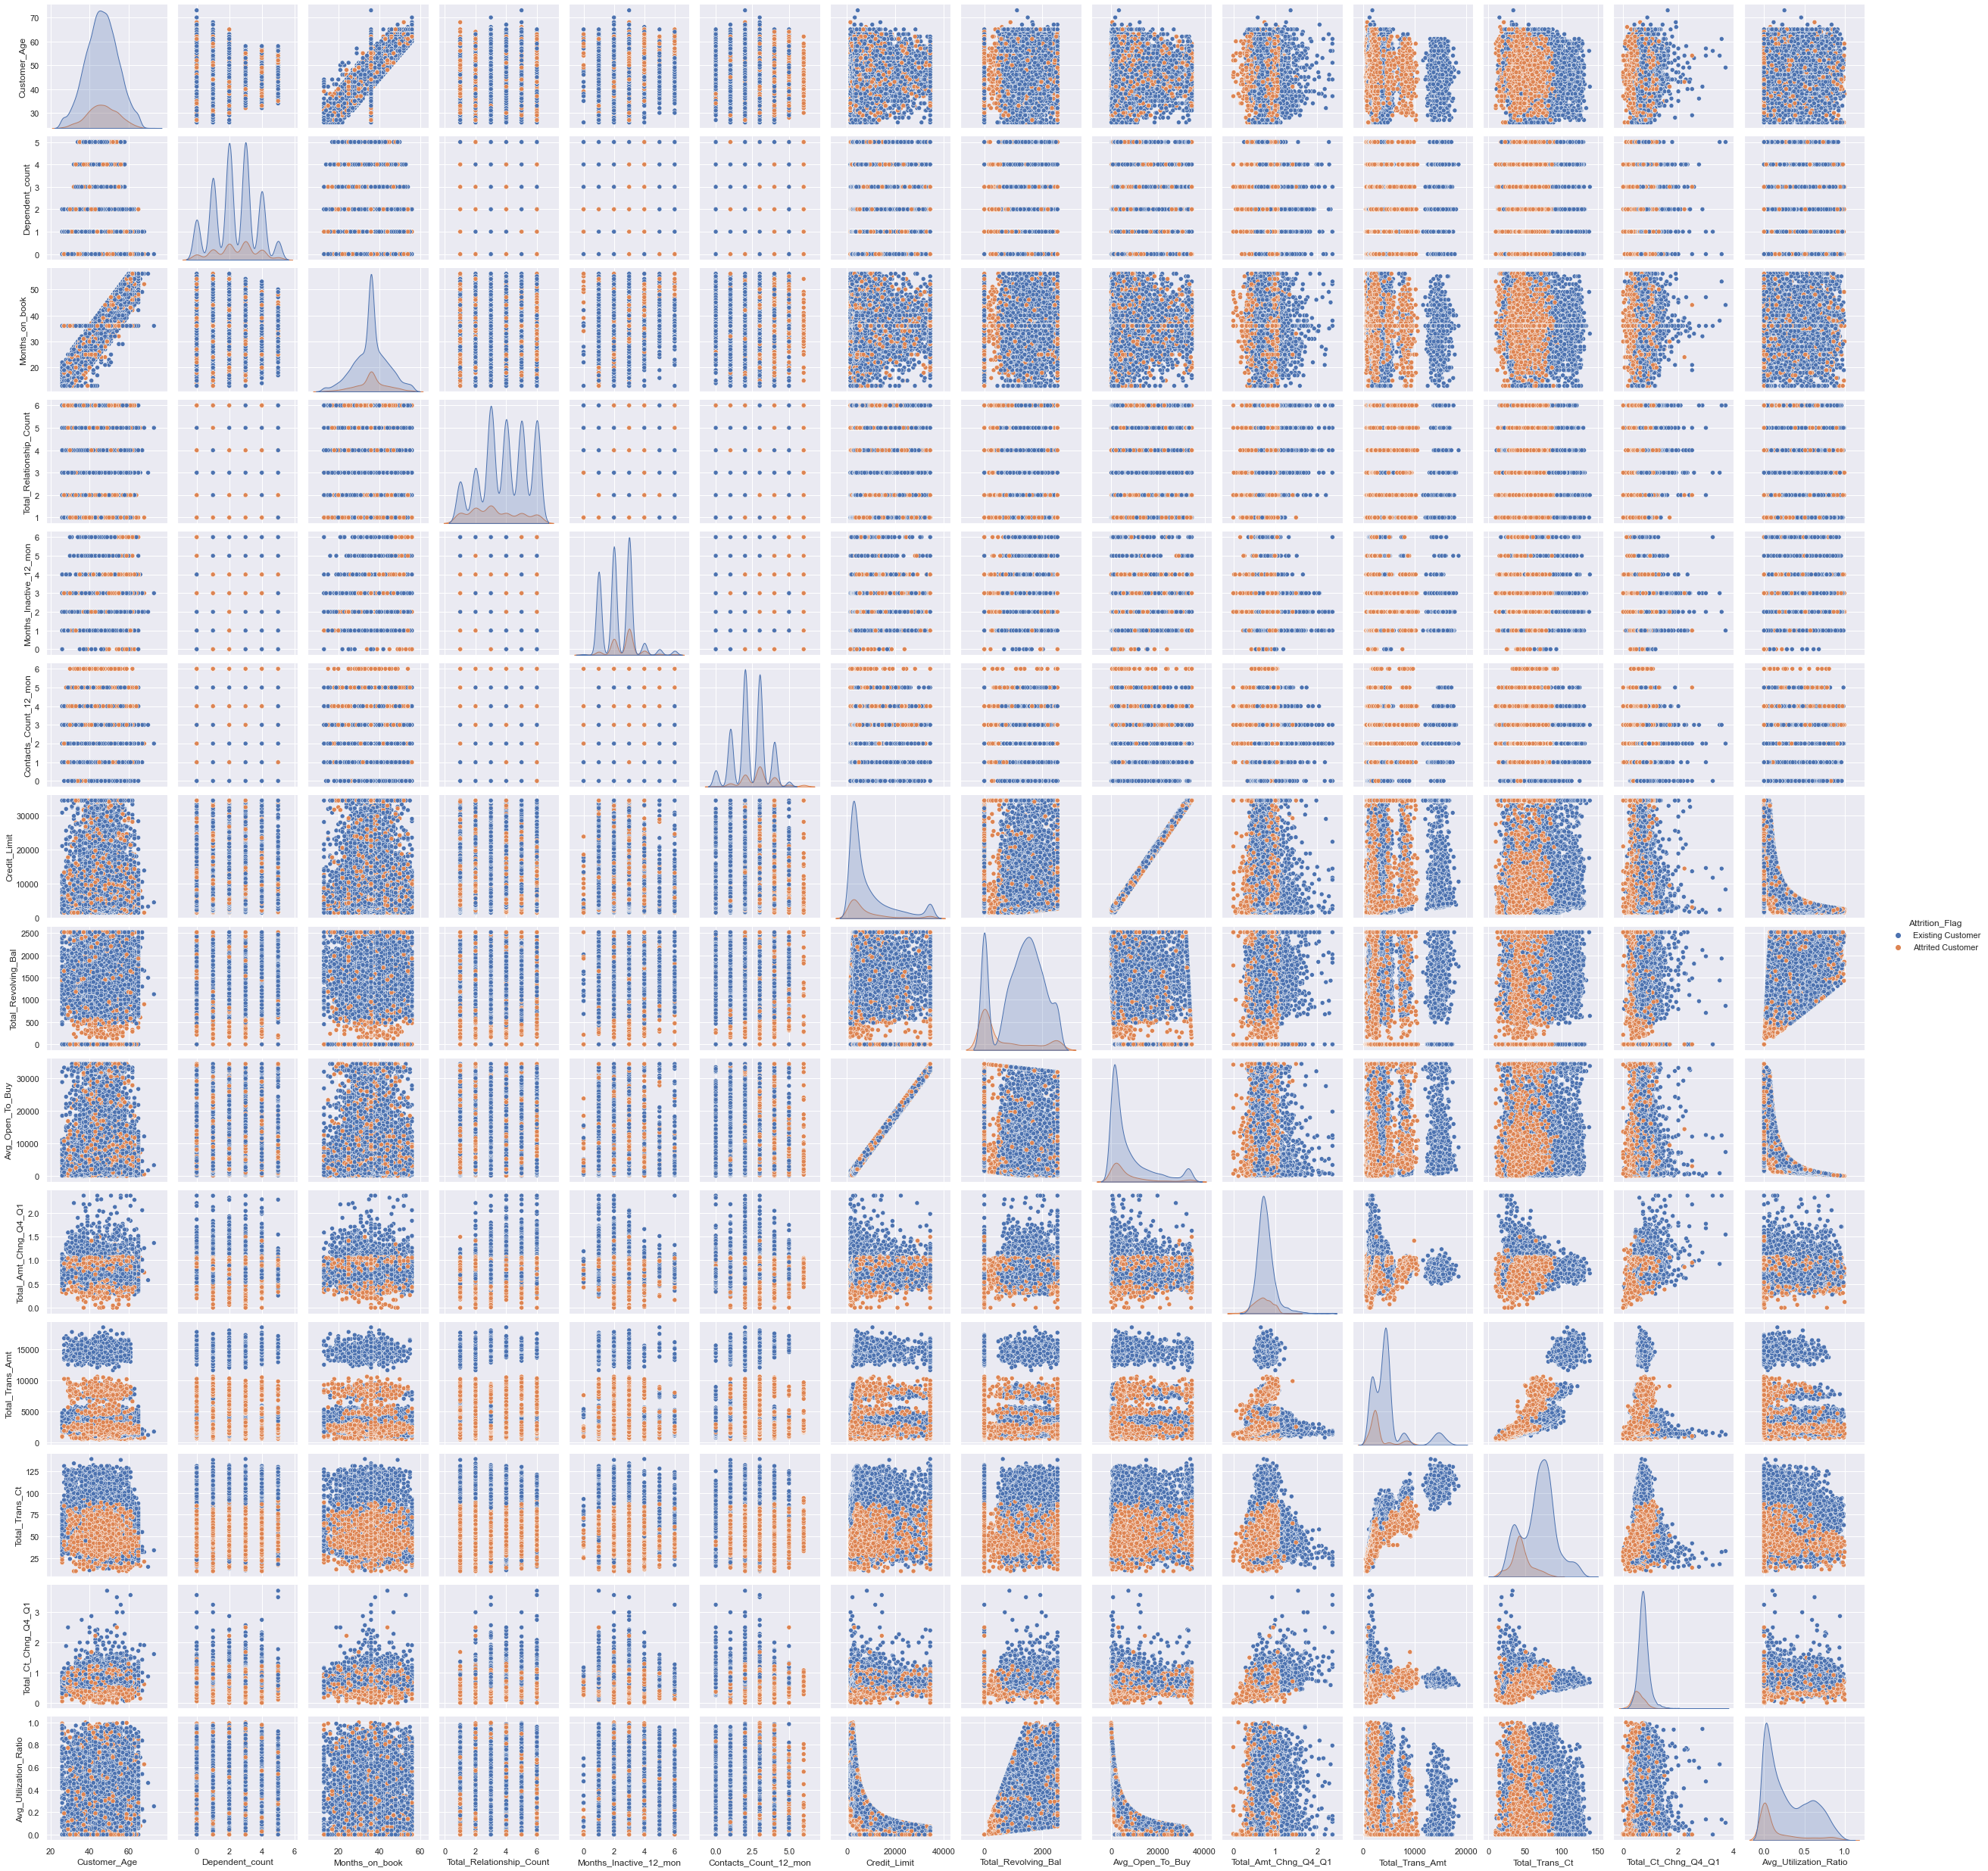

In [47]:
sns.pairplot(df, hue="Attrition_Flag");

#### Observations
* Age is highly correlated with Months_on_book
* Total transaction amount (Total_Trans_Amt) and total transaction count (Total_Trans_Ct) are very highly correlated as we expect.
* There is an inverse relationship between Credit_limit and Avg_Utilization_Ratio, this makes sense; for customers with a higher credit limit, it requires more spending to reach higher utilization ratios.
* Credit Limit and Avg_Open_To_Buy are very highly correlated. In fact Avg_Open_To_Buy = Credit_Limit - Total_Revolving_Bal (See the proof for this below)
* Customers with a low Total_Revolving_Bal, greater than 0 but less than 500, are highly likely to be attrited customers.
* All customers with Contacts_Count_12_mon = 6 are attrited customers.
* Customers with a Total_Trans_Amt between 6000 and 11000 are very likely to be attrited customers, there are no attrited customers with a Total_Trans_Amt above ~10,000
* Total_Transation_Ct appears to be a very strong indicator of our target class, if Total_Transaction_Ct is below 50 a customer is very likely to be attrited. When Total_Transation_Ct ~ 45, almost all customers are attrited.
* For customers with a low Total_Amt change_Q4-Q1 (<0.5), we see a similar pattern in the Total_Ct_Chng_Q4_Q1 i.e. very high attrition rates.
* There appears to be a cut-off for attrited customers in the Total_Amt_Chng_Q4_Q1 column. Once this value is above 1, the chances of a customer being attrited drops dramatically.
* Avg_Utilization_Ratio also appears to be a strong indicator of our target. Customers with higher Ave_Utilization_Ratio are much less likely to be attrited.
* In general we can see, on multiple plots, areas where the target classes do not overlap. This means we expect decision tree ML models (and ensemble methods with decision trees as the base estimator) to work well on these data.

Let's look in more detail at some of the plots that show areas with no overlap:

#### Zoom of Total_Trans_Amt vs. Total_Trans_Ct

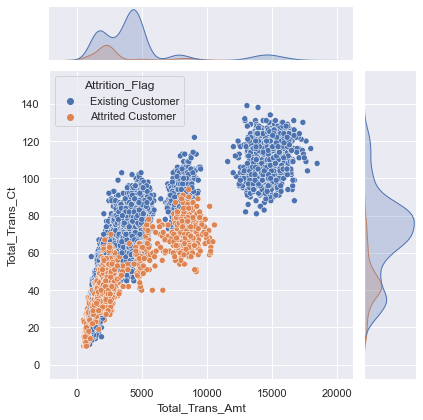

In [48]:
sns.jointplot(data=df, x='Total_Trans_Amt', y='Total_Trans_Ct', hue='Attrition_Flag');

* We can see that customers with a high Total_Trans_Amt (above ~11,000) have very little chance of being attrited customers.
* Customers with a high Total_Trans_Ct (above 90) are also very unlikely to be attrited.
* In addition, there are areas of the plot below the above thresholds, where the combination of the variables is such that a customer is very unlikely to attrite.

#### Zoom of Total_Ct_Chng_Q4_Q1 vs. Total_Amt_Chng_Q4_Q1

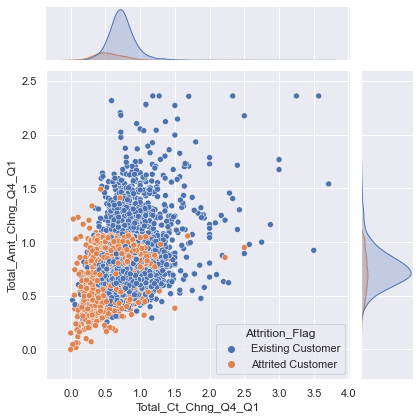

In [49]:
sns.jointplot(data=df, x='Total_Ct_Chng_Q4_Q1', y='Total_Amt_Chng_Q4_Q1', hue='Attrition_Flag');

* We see that customers with a low value for either Total_Ct_Chng_Q4_Q1 or Total_Amt_Chng_Q4_Q1 have a very high probability of being attrited.
* For Total_Amt_Chng_Q4_Q1, above ~1.1, the chance of a customer being attrited drops dramatically.
* For Total_Ct_Chng_Q4_Q1, above ~1.25, the chance of a customer being attrited drops dramatically.

#### Total Revolving Balance Observations

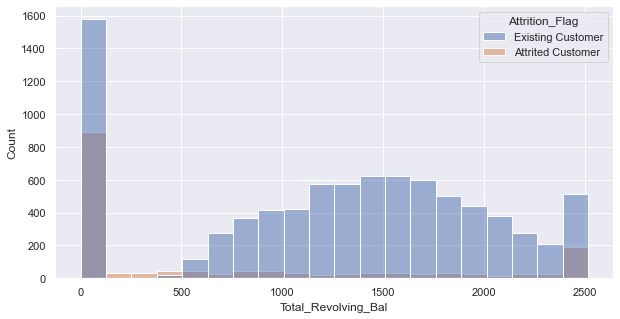

In [50]:
sns.histplot(data=df, x='Total_Revolving_Bal', hue='Attrition_Flag', bins='auto', stat='count' );

* We saw in the pair plot an interesting pattern in Total_Revolving_Bal: Almost all customers with a revolving balance above zero, but below 500 are attrited customers.
* Of customers with a Total_Revolving_Bal = zero, about 50% are attrited, a fairly high percentage given that the overall percentage of attrited customers is 16.1%.
* We can conclude that customers with a lower revolving balance (less than 500) are at more risk of being attrited.
* We can also see that at the maximum Total_Revolving_Bal (~2500) the chances of a customer being attrited also increases.

#### Observations on Average Utilization Ratio

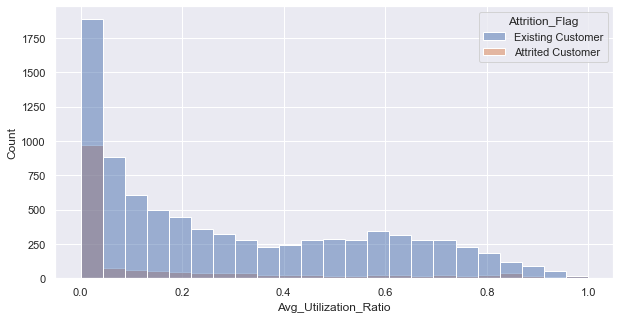

In [51]:
sns.histplot(data=df, x='Avg_Utilization_Ratio', hue='Attrition_Flag', bins='auto', stat='count' );

* Customers with an Avg_Utilization_Ratio above zero are less likely to be attrited, above 0.4 the likelyhood of attrition drops further.

#### Observations on No. of Contacts in the last 12 months

In [52]:
def stacked_plot(x):
    tab = pd.crosstab(x, df["Attrition_Flag"], normalize="index")
    tab.plot(kind="bar", stacked=True, figsize=(10, 5))
    plt.legend(loc="lower left", frameon=False)
    plt.legend(loc="upper left", bbox_to_anchor=(1, 1))
    plt.show()

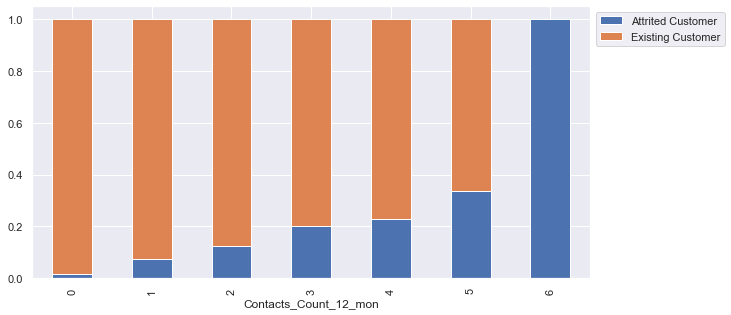

In [53]:
stacked_plot(df['Contacts_Count_12_mon'])

* The plot above shows Contacts_Count_12_mon. The bars are normalized and the proportion of blue indicates the proportion of customers, at each count, that are Attrited.
* We can see a steady increase in the proportion of attrited customers as the number of contacts increases. The Data Dictionary only states for this variable, "No. of Contacts in the last 12 months". We can assume from this pattern that it is the customer that is contacting the bank... and likely to complain! Once the number of contacts reaches 6, the proportion of customers that are attrited is 100%

#### Relationship between Credit_Limit, Total_Revolving_Bal and Avg_Open_To_Buy
In the pair plots we saw the very strong relationship between Credit_Limit and Avg_Open_To_Buy. Here we show that:  
Avg_Open_To_Buy = Credit_Limit - Total_Revolving_Bal  

Below we show that if we plot Credit_Limit - Total_Revolving_Bal + Avg_Open_To_Buy, the result is zero for all rows of the data. We can drop at least one of these columns when it comes time to make our ML models.

<AxesSubplot:>

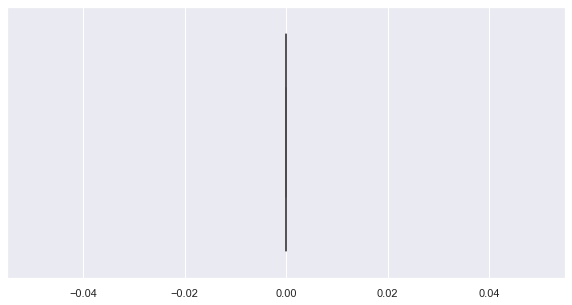

In [54]:
sns.boxplot(df['Credit_Limit'] - (df['Total_Revolving_Bal']+df['Avg_Open_To_Buy']))

## Categorical Variables vs. Target Variable

In [55]:
### Function to plot stacked bar charts for categorical columns
def stacked_plot(x):
    tab = pd.crosstab(x, df["Attrition_Flag"], normalize="index")
    tab.plot(kind="bar", stacked=True, figsize=(10, 5))
    plt.legend(loc="lower left", frameon=False)
    plt.legend(loc="upper left", bbox_to_anchor=(1, 1))
    plt.show()
    # Show numbers that feed the bar chart with percentages
    tab1 = pd.crosstab(x, df["Attrition_Flag"], margins=True)
    tab1['Percent_Attrited'] = round((tab1["Attrited Customer"] / tab1['All'])*100, 2)
    tab1['Percent_Existing'] = round((tab1["Existing Customer"] / tab1['All'])*100, 2)
    return tab1

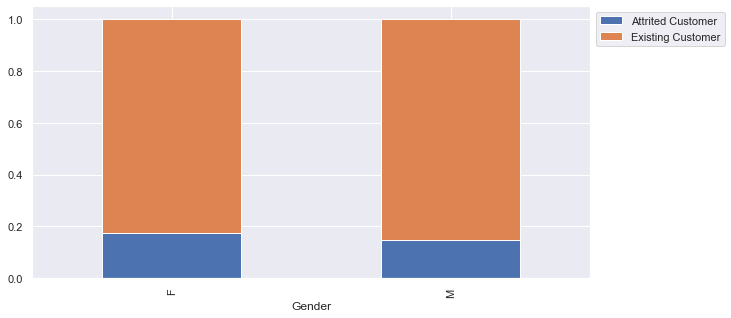

Attrition_Flag  Attrited Customer  Existing Customer    All  Percent_Attrited  \
Gender                                                                          
F                             930               4428   5358             17.36   
M                             697               4072   4769             14.62   
All                          1627               8500  10127             16.07   

Attrition_Flag  Percent_Existing  
Gender                            
F                          82.64  
M                          85.38  
All                        83.93

In [56]:
stacked_plot(df['Gender'])

* There is very little difference in the number of attrited customers between males and females

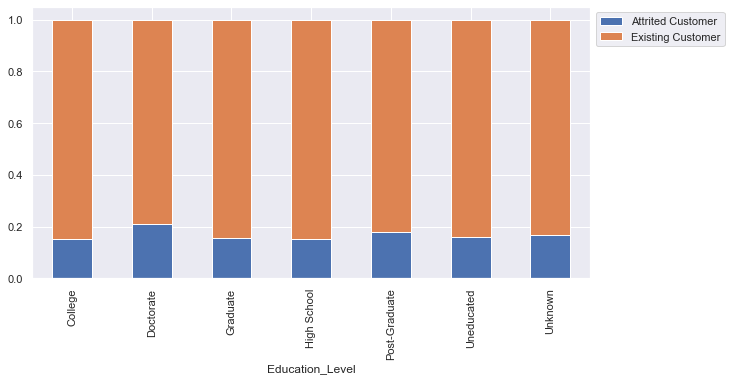

Attrition_Flag   Attrited Customer  Existing Customer    All  \
Education_Level                                                
College                        154                859   1013   
Doctorate                       95                356    451   
Graduate                       487               2641   3128   
High School                    306               1707   2013   
Post-Graduate                   92                424    516   
Uneducated                     237               1250   1487   
Unknown                        256               1263   1519   
All                           1627               8500  10127   

Attrition_Flag   Percent_Attrited  Percent_Existing  
Education_Level                                      
College                     15.20             84.80  
Doctorate                   21.06             78.94  
Graduate                    15.57             84.43  
High School                 15.20             84.80  
Post-Graduate               17.83             82.17  
Uneducated                  15.94             84.06  
Unknown                     16.85             83.15  
All                         16.07             83.93

In [57]:
stacked_plot(df['Education_Level'])

* There is a very slight increase in the attrition percentage with an increase in education level. Doctorates have the highest attrition level at 21%, Post-Graduates sit at 17.8% while most of the other categories sit around 15%
* None of these categories deviate far from our average attrition rate ~16%

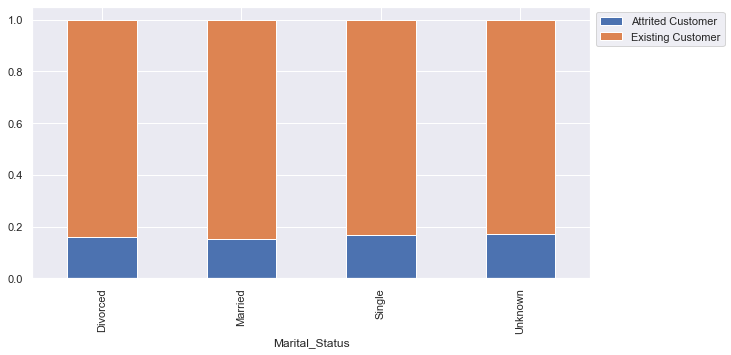

Attrition_Flag  Attrited Customer  Existing Customer    All  Percent_Attrited  \
Marital_Status                                                                  
Divorced                      121                627    748             16.18   
Married                       709               3978   4687             15.13   
Single                        668               3275   3943             16.94   
Unknown                       129                620    749             17.22   
All                          1627               8500  10127             16.07   

Attrition_Flag  Percent_Existing  
Marital_Status                    
Divorced                   83.82  
Married                    84.87  
Single                     83.06  
Unknown                    82.78  
All                        83.93

In [58]:
stacked_plot(df['Marital_Status'])

* There is no relationship between Marital Status and the target variable, all categories sit between ~15-17%

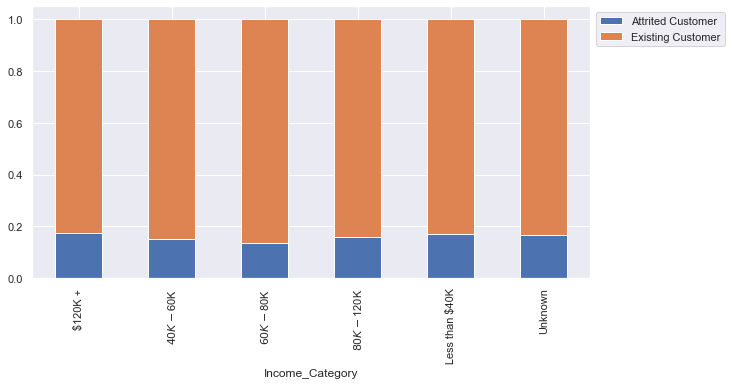

Attrition_Flag   Attrited Customer  Existing Customer    All  \
Income_Category                                                
$120K +                        126                601    727   
$40K - $60K                    271               1519   1790   
$60K - $80K                    189               1213   1402   
$80K - $120K                   242               1293   1535   
Less than $40K                 612               2949   3561   
Unknown                        187                925   1112   
All                           1627               8500  10127   

Attrition_Flag   Percent_Attrited  Percent_Existing  
Income_Category                                      
$120K +                     17.33             82.67  
$40K - $60K                 15.14             84.86  
$60K - $80K                 13.48             86.52  
$80K - $120K                15.77             84.23  
Less than $40K              17.19             82.81  
Unknown                     16.82             83.18  
All                         16.07             83.93

In [59]:
stacked_plot(df['Income_Category'])

* The range of attrition percentage is ~13.5-17%, there is no clear difference between the categories in relation to the target variable. All categories sit near our average attrition rate ~16%

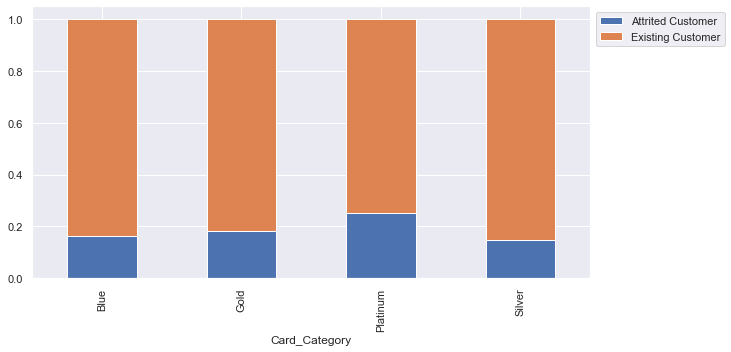

Attrition_Flag  Attrited Customer  Existing Customer    All  Percent_Attrited  \
Card_Category                                                                   
Blue                         1519               7917   9436             16.10   
Gold                           21                 95    116             18.10   
Platinum                        5                 15     20             25.00   
Silver                         82                473    555             14.77   
All                          1627               8500  10127             16.07   

Attrition_Flag  Percent_Existing  
Card_Category                     
Blue                       83.90  
Gold                       81.90  
Platinum                   75.00  
Silver                     85.23  
All                        83.93

In [60]:
stacked_plot(df['Card_Category'])

* There is a slight increase in the percentage of attrited customers in the Platimum category, however, these customers represent only a tiny fraction of the total customer base.

## Other EDA
We have looked at continuous variables and categorical variables vs. our target variable. Now let's explore the relationships between other variables.

#### Total_Trans_Amt
We saw that Total_Trans_Amt was actually 4 distributions, let's see this variable is related to any of our categorical variables.

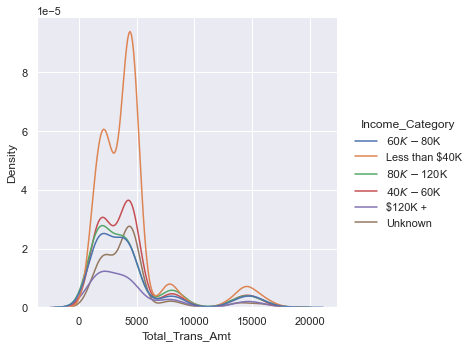

In [61]:
sns.displot(data=df, x='Total_Trans_Amt', hue='Income_Category', kind='kde');

* It does not appear that there is a relationship between income category and Total_Trans_Amt. Let's look at a cdf to be sure

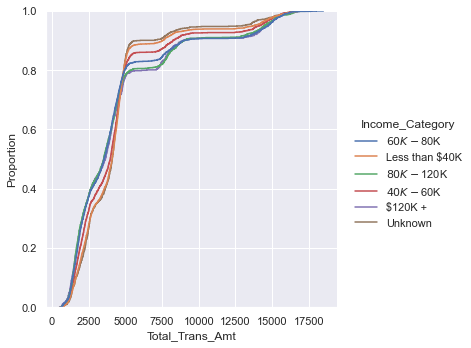

In [62]:
sns.displot(data=df, x='Total_Trans_Amt', hue='Income_Category', kind='ecdf');

* We can see a change in the cdf's of each income category: higher incomes categories have slightly higher Total_Trans_Amt.
* The difference is not the explaination for the separate modes in the Total_Trans_Amt variable.

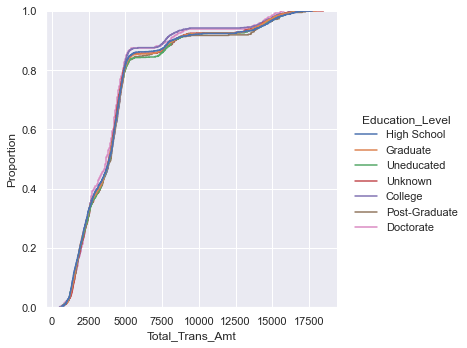

In [63]:
sns.displot(data=df, x='Total_Trans_Amt', hue='Education_Level', kind='ecdf');

* The plot above is cdf of Total_Trans_Amt coloured by Education Level, we can see that education level has no effect on Total_Trans_Amt.
* I have tried other variables, like Card Category and Marital Status, none have any effect on Total_Trans_Amt. We can't make any conclusion about the 4 modes based on the data that we have.

# EDA - Deep Dive: Deadbeats vs. Revolvers
Deadbeat is a slang term the credit card industry uses for customers who pay off their balance in full and on time each month, thus avoiding the need to pay interest on their account.
A Revolver is a customer who has a revolving balance and thus pays interest.
A Revolver is a much more profitable customer to a bank, so let's separate out the Deadbeats and Revolvers and see what we can learn about them.

In [64]:
df['Revolver_Flag'] = 0

for i in range(0,10127):
    if df.loc[i,'Total_Revolving_Bal']>0.0:
        df.loc[i,'Revolver_Flag'] = 1       

In [65]:
### Function to plot stacked bar charts for categorical columns
def stacked_plot(x):
    tab = pd.crosstab(x, df["Revolver_Flag"], normalize="index")
    tab.plot(kind="bar", stacked=True, figsize=(10, 5))
    plt.legend(loc="lower left", frameon=False)
    plt.legend(loc="upper left", bbox_to_anchor=(1, 1))
    plt.show()
    # Show numbers that feed the bar chart with percentages
    #sns.set(palette="nipy_spectral")
    tab1 = pd.crosstab(x, df["Revolver_Flag"], margins=True)
    tab1['Percent_Deadbeat'] = round((tab1[0] / tab1['All'])*100, 2)
    tab1['Percent_Revolver'] = round((tab1[1] / tab1['All'])*100, 2)
    return tab1

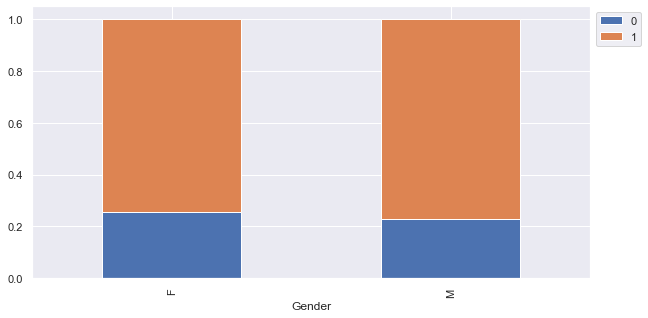

Revolver_Flag     0     1    All  Percent_Deadbeat  Percent_Revolver
Gender                                                              
F              1376  3982   5358             25.68             74.32
M              1094  3675   4769             22.94             77.06
All            2470  7657  10127             24.39             75.61

In [66]:
stacked_plot(df['Gender'])

* Males are slightly more likely to be revolvers, but the difference is only slight.

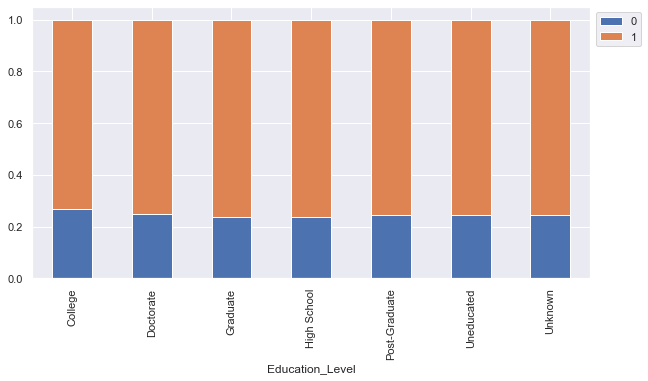

Revolver_Flag       0     1    All  Percent_Deadbeat  Percent_Revolver
Education_Level                                                       
College           271   742   1013             26.75             73.25
Doctorate         113   338    451             25.06             74.94
Graduate          744  2384   3128             23.79             76.21
High School       478  1535   2013             23.75             76.25
Post-Graduate     126   390    516             24.42             75.58
Uneducated        363  1124   1487             24.41             75.59
Unknown           375  1144   1519             24.69             75.31
All              2470  7657  10127             24.39             75.61

In [67]:
stacked_plot(df['Education_Level'])

* It appears that education level has no relationship to a customer being a deadbeat or revolver.

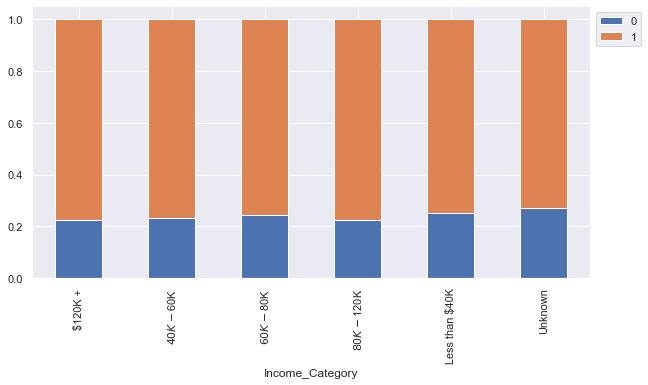

Revolver_Flag       0     1    All  Percent_Deadbeat  Percent_Revolver
Income_Category                                                       
$120K +           164   563    727             22.56             77.44
$40K - $60K       420  1370   1790             23.46             76.54
$60K - $80K       340  1062   1402             24.25             75.75
$80K - $120K      344  1191   1535             22.41             77.59
Less than $40K    899  2662   3561             25.25             74.75
Unknown           303   809   1112             27.25             72.75
All              2470  7657  10127             24.39             75.61

In [68]:
stacked_plot(df['Income_Category'])

* There is no relationship between income category and a customer being a deadbeat of revolver.

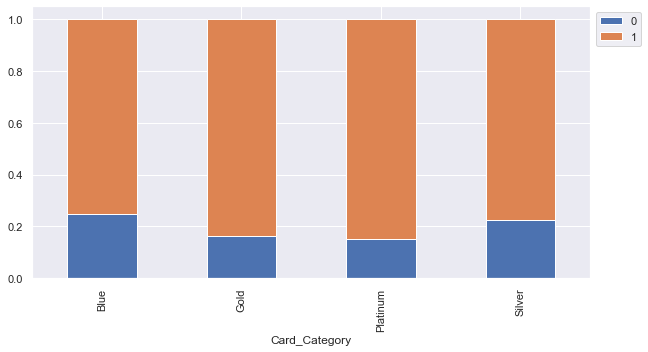

Revolver_Flag     0     1    All  Percent_Deadbeat  Percent_Revolver
Card_Category                                                       
Blue           2323  7113   9436             24.62             75.38
Gold             19    97    116             16.38             83.62
Platinum          3    17     20             15.00             85.00
Silver          125   430    555             22.52             77.48
All            2470  7657  10127             24.39             75.61

In [69]:
stacked_plot(df['Card_Category'])

* The Gold and Platinum card holders are slighly more likely to be revolvers. However, they make up such a small percentage of the data base, it's hard to make any conclusive statements.

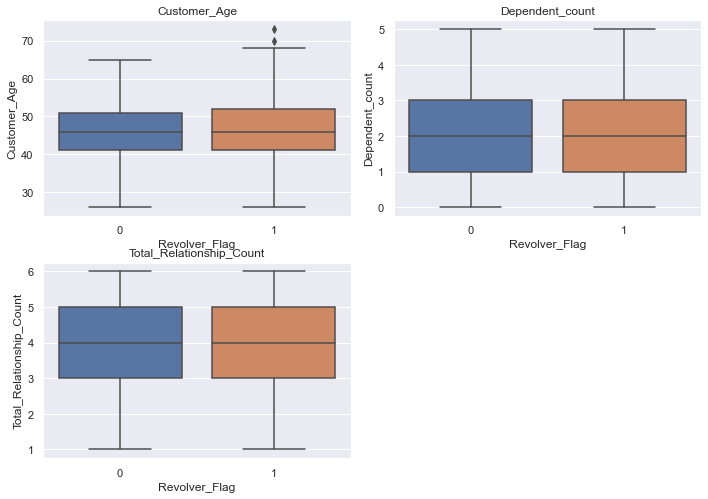

In [70]:
cols = df[["Customer_Age", "Dependent_count", "Total_Relationship_Count"]].columns.tolist()
plt.figure(figsize=(10, 10))

for i, variable in enumerate(cols):
    plt.subplot(3, 2, i + 1)
    sns.boxplot(df["Revolver_Flag"], df[variable])
    plt.tight_layout()
    plt.title(variable)
plt.show()

* Customer Age, Dependent Count and Total Relationship count all appear to have no relationship with a customer being a deadbeat or revolver.

#### Summary
* It appears that there is no specific customer profile that would indicate they are more likely to be a deadbeat or revolver.

# Illustrate the insights based on EDA
*Key meaningful observations on the relationship between variables*

* There is no particular customer profile that predicts customer attrition. We saw that across Age, Gender, Education Level, Marital Status and Income Category, there was almost no difference in the percentage of Attrited Customers.
* Similarly, there is no particular customer profile that predicts a Deadbeat or Revolver.
* **The biggest predictor of a customer being an Attrited vs. Existing customer is their credit card usage habits**
* Customers with a low revolving balance (below ~500) are much more likely to be attrited. For customers with a zero balance the percentage of attrited customers is ~50% much higher than the overall 16.1%. ALL customers with a revolving balance between zero and 500 are attrited.
* Customers with a high Total_Trans_Amt (above ~11,000) have very little chance of being attrited customers. Correlated with this: Customers with a high Total_Trans_Ct (above 90) are also very unlikely to be attrited. So there is little worry of customers who use their card a lot becoming attrited.
* Customers with a high ratio Q4 to Q1 in both count and amount also have very little chance of being attrited.
* The above 3 points all indicate that customers who use their cards often and spend a lot on their credit card are at low risk of cancelling their credit card. This makes logical sense.
* Finally, we saw that as Contacts_Count_12_mon increases, the chances of a customer being attrited increases. My assumption is that customers are contacting the bank to complain. That would explain the pattern, that the more contacts they make with the bank, the more chance there is of attrition. So, this is probably a redundant statement but: reducting the number of times a customer complains will also reduce the chances of attrition.

# Data Pre-processing
*Prepare the data for analysis - Missing value Treatment, Outlier Detection(treat, if needed- why or why not ), Feature Engineering, Prepare data for modeling*

**Missing Value Treatment**  
We have already seen that there are no missing values in the data set. There are a large number of "Unknown" entries in Marital_Status, Income_Category and Education_Level. However, if we treated these as null values and inputed with the mode (the most common method) we would have very unbalanced classes for each variable after the imputation. It is not an uncommon strategy to treat "Unknown" as its own category, that is what we will do here. 

**Outlier Detection**  
We have already dealt with outliers during our univariate analysis. There were many outliers if we consider any data point outside of the boxplot "whiskers" as an outlier. However, I believe that the bulk of these points represent real data and should not be treated. The points that were questionable, i.e. points that sat a long way from other data, were clipped.  
We will experiment with different scaling strategies in our ML model pipelines, which should help with outliers.

**Feature Engineering**  
We created the "Revolver Flag" which flags if a customer has a revolving balance or is a 'deadbeat' (someone without a revolving balance). This should be useful for the ML models as: if Total_Revolving_Bal < 500 AND Revolver_Flag = 1 there is an almost 100% chance a customer is attrited.

**Other**  
We saw that Avg_Open_To_Buy = Credit_Limit - Total_Revolving_Bal, so we can drop at least one of these columns.

In [71]:
# Make a copy of the database after our outlier treatment but before we make any major changes
df_initial = df.copy() 

### Visualize Log Transform on Highly Skewed Columns
Below we will look at skewed columns before and after a log transform to see if this transform will be of any use to us. As some of these columns contain zero, we will evaluate log(x+1). 

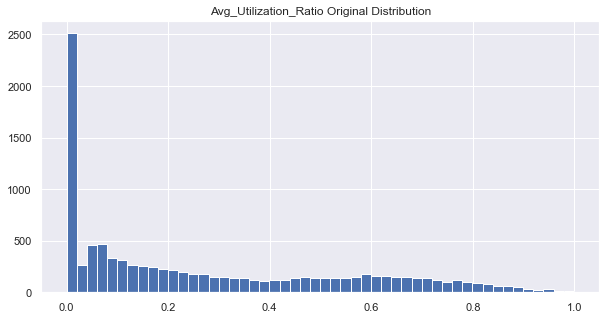

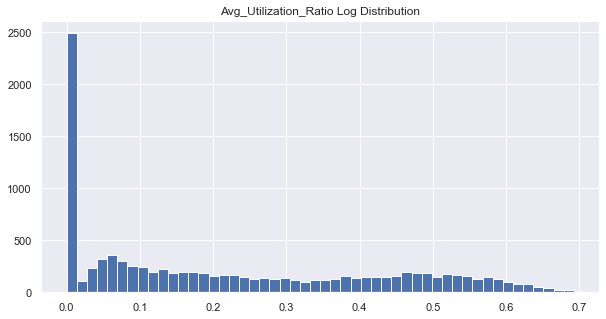

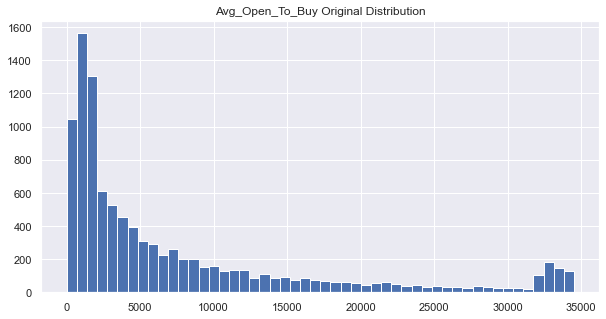

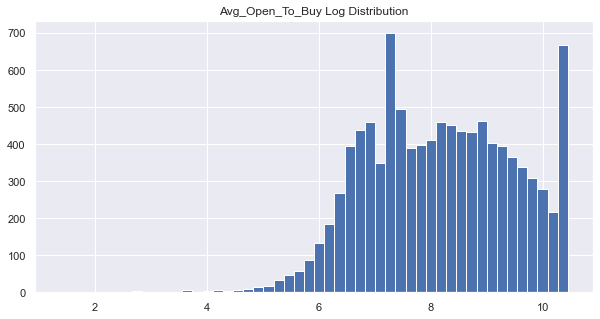

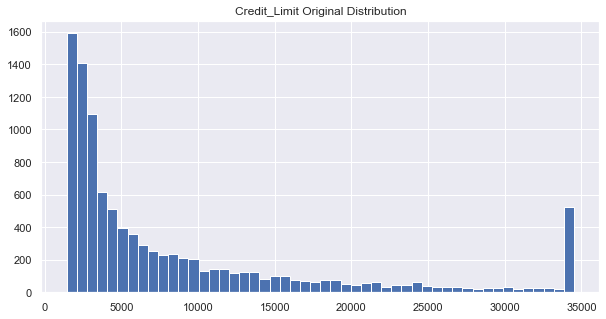

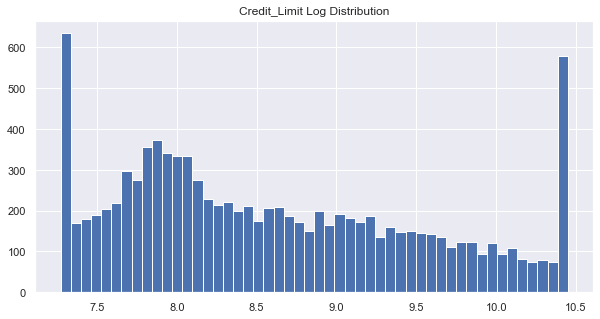

In [72]:
cols_to_log = ['Avg_Utilization_Ratio','Avg_Open_To_Buy','Credit_Limit']
for colname in cols_to_log:
    #sns.displot(df[colname], kind='kde')
    plt.hist(df[colname], bins=50) #plot before a log transform
    plt.title(f'{colname} Original Distribution')
    plt.show()
    #sns.displot(np.log(df[colname]), kind='kde')
    plt.hist(np.log(df[colname]+1), bins=50) #plot after a log transform
    plt.title(f'{colname} Log Distribution')
    plt.show()

* It seems that there is little use in applying the log transform to the Avg_Utilization_Ratio column. However the skewness of the other columns was reduced. We can experiment will applying log transforms to these columns.

### Encode Categorical Variables
The bulk of our categorical variables are either:  
a) categories with 2 options  
b) categories with an obvious ordering  
For categories with 2 options we can simply encode with 0 and 1. For the categories with an order, we will encode using that order. We will encode "Unknown" entries as -1, so as not to mess up the ordering.

The only variable that does not fit into the above 2 cases is Marital Status. We will encode that using get-dummies

In [73]:
# Encode our target variable, 1 for Attrited Customers
df['Attrition_Flag']=df['Attrition_Flag'].map(
    {'Existing Customer':0,'Attrited Customer':1}
)

# Encode Gender, 1 for Females
df['Gender']=df['Gender'].map(
    {'M':0,'F':1}
)

# Encode Education_Level
df['Education_Level']=df['Education_Level'].map(
    {'Uneducated':0, 'High School':1, 'College':2, 'Graduate':3, 'Post-Graduate':4, 'Doctorate':5, 'Unknown':-1  }
)

#Encode Income_Category
df['Income_Category']=df['Income_Category'].map(
    {'Less than $40K':0, '$40K - $60K':1, '$60K - $80K':2, '$80K - $120K':3, '$120K +':4, 'Unknown':-1}
)
    
#Encode Card_Category
df['Card_Category']=df['Card_Category'].map(
    {'Blue':0, 'Silver':1, 'Gold':2, 'Platinum':3}
)

In [74]:
df = pd.get_dummies(data=df, columns=['Marital_Status'], drop_first=True)

In [75]:
df # Check the work, looks good

Attrition_Flag  Customer_Age  Gender  Dependent_count  Education_Level  \
0                   0            45       0                3                1   
1                   0            49       1                5                3   
2                   0            51       0                3                3   
3                   0            40       1                4                1   
4                   0            40       0                3                0   
...               ...           ...     ...              ...              ...   
10122               0            50       0                2                3   
10123               1            41       0                2               -1   
10124               1            44       1                1                1   
10125               1            30       0                2                3   
10126               1            43       1                2                3   

       Income_Category  Card_Category  Months_on_book  \
0                    2              0              39   
1                    0              0              44   
2                    3              0              36   
3                    0              0              34   
4                    2              0              21   
...                ...            ...             ...   
10122                1              0              40   
10123                1              0              25   
10124                0              0              36   
10125                1              0              36   
10126                0              1              25   

       Total_Relationship_Count  Months_Inactive_12_mon  \
0                             5                       1   
1                             6                       1   
2                             4                       1   
3                             3                       4   
4                             5                       1   
...                         ...                     ...   
10122                         3                       2   
10123                         4                       2   
10124                         5                       3   
10125                         4                       3   
10126                         6                       2   

       Contacts_Count_12_mon  Credit_Limit  Total_Revolving_Bal  \
0                          3       12691.0                  777   
1                          2        8256.0                  864   
2                          0        3418.0                    0   
3                          1        3313.0                 2517   
4                          0        4716.0                    0   
...                      ...           ...                  ...   
10122                      3        4003.0                 1851   
10123                      3        4277.0                 2186   
10124                      4        5409.0                    0   
10125                      3        5281.0                    0   
10126                      4       10388.0                 1961   

       Avg_Open_To_Buy  Total_Amt_Chng_Q4_Q1  Total_Trans_Amt  Total_Trans_Ct  \
0              11914.0                 1.335             1144              42   
1               7392.0                 1.541             1291              33   
2               3418.0                 2.360             1887              20   
3                796.0                 1.405             1171              20   
4               4716.0                 2.175              816              28   
...                ...                   ...              ...             ...   
10122           2152.0                 0.703            15476             117   
10123           2091.0                 0.804             8764              69   
10124           5409.0                 0.819            10291              60   
10125           5281.0   

In [76]:
df.info() # our database is now fully encoded, all data are numerical

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10127 entries, 0 to 10126
Data columns (total 23 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Attrition_Flag            10127 non-null  int64  
 1   Customer_Age              10127 non-null  int64  
 2   Gender                    10127 non-null  int64  
 3   Dependent_count           10127 non-null  int64  
 4   Education_Level           10127 non-null  int64  
 5   Income_Category           10127 non-null  int64  
 6   Card_Category             10127 non-null  int64  
 7   Months_on_book            10127 non-null  int64  
 8   Total_Relationship_Count  10127 non-null  int64  
 9   Months_Inactive_12_mon    10127 non-null  int64  
 10  Contacts_Count_12_mon     10127 non-null  int64  
 11  Credit_Limit              10127 non-null  float64
 12  Total_Revolving_Bal       10127 non-null  int64  
 13  Avg_Open_To_Buy           10127 non-null  float64
 14  Total_

### Split Data

In [77]:
# Separating target variable and other variables
X = df.drop(columns="Attrition_Flag")
y = df["Attrition_Flag"]

In [78]:
# Let's split the data into a train and test sets. 
# I will use the stratify parameter to maintain the ratio of classes in the dependent variable
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1, stratify=y)

In [79]:
print("{0:0.2f}% data is in training set".format((len(X_train)/len(df.index)) * 100))
print("{0:0.2f}% data is in test set".format((len(X_test)/len(df.index)) * 100))

69.99% data is in training set
30.01% data is in test set


In [80]:
print("Original Attrition_Flag 1 Values    : {0} ({1:0.2f}%)".format(len(df.loc[df['Attrition_Flag'] == 1]), (len(df.loc[df['Attrition_Flag'] == 1])/len(df.index)) * 100))
print("Original Attrition_Flag 0 Values   : {0} ({1:0.2f}%)".format(len(df.loc[df['Attrition_Flag'] == 0]), (len(df.loc[df['Attrition_Flag'] == 0])/len(df.index)) * 100))
print("")
print("Training Attrition_Flag 1 Values    : {0} ({1:0.2f}%)".format(len(y_train[y_train[:] == 1]), (len(y_train[y_train[:] == 1])/len(y_train)) * 100))
print("Training Attrition_Flag 0 Values   : {0} ({1:0.2f}%)".format(len(y_train[y_train[:] == 0]), (len(y_train[y_train[:] == 0])/len(y_train)) * 100))
print("")
print("Test Attrition_Flag 1 Values        : {0} ({1:0.2f}%)".format(len(y_test[y_test[:] == 1]), (len(y_test[y_test[:] == 1])/len(y_test)) * 100))
print("Test Attrition_Flag 0 Values       : {0} ({1:0.2f}%)".format(len(y_test[y_test[:] == 0]), (len(y_test[y_test[:] == 0])/len(y_test)) * 100))

Original Attrition_Flag 1 Values    : 1627 (16.07%)
Original Attrition_Flag 0 Values   : 8500 (83.93%)

Training Attrition_Flag 1 Values    : 1139 (16.07%)
Training Attrition_Flag 0 Values   : 5949 (83.93%)

Test Attrition_Flag 1 Values        : 488 (16.06%)
Test Attrition_Flag 0 Values       : 2551 (83.94%)


The data have been split into training and test sets. The data have been stratified, such that the proportion of classes in our target variable is the same in the original, training and test data sets.

### Test for Multicollinearity
We will test for multicollinearity using VIF scores.

In [81]:
# to compute VIF, we first have to add a constant column having value 1 to our input variables

X1 = X.copy()   #Copy our X data frame for the purpose of this test
X1['const'] = 1  #Add a constant column

In [82]:
# Here we will be using our library: from statsmodels.stats.outliers_influence import variance_inflation_factor

vif_series1 = pd.Series([variance_inflation_factor(X1.values,i) for i in range(X1.shape[1])],index=X1.columns)
print('VIF Scores: \n\n{}\n'.format(vif_series1))

VIF Scores: 

Customer_Age                  2.687503
Gender                        2.733285
Dependent_count               1.041281
Education_Level               1.001644
Income_Category               2.914259
Card_Category                 1.407996
Months_on_book                2.659424
Total_Relationship_Count      1.158482
Months_Inactive_12_mon        1.012063
Contacts_Count_12_mon         1.039001
Credit_Limit                       inf
Total_Revolving_Bal                inf
Avg_Open_To_Buy                    inf
Total_Amt_Chng_Q4_Q1          1.191362
Total_Trans_Amt               3.309111
Total_Trans_Ct                3.115622
Total_Ct_Chng_Q4_Q1           1.204701
Avg_Utilization_Ratio         3.054584
Revolver_Flag                 3.040861
Marital_Status_Married        3.944273
Marital_Status_Single         3.841927
Marital_Status_Unknown        1.857329
const                       112.986832
dtype: float64



* As we expected we get very high multicollinearity for Credit_Limit, Total_Revolving_Bal and Avg_Open_To_Buy. We will need to remove one of these columns. We will test which one to drop by building a number of logistic regression models, dropping each column in turn and seeing which gives us the best resutls. We will do that in the next section: Model Building - Logistic Regression.

# Model Building Prepwork

### Model evaluation criterion:

#### Model can make wrong predictions as:
1. Predicting a customer will attrite  but the customer does not (False Positive) 
2. Predicting a customer will not attrite but the customer does (False Negative) 

#### Which case is more important? 
* In this case the False Negative case leads to a much worse outcome. If the bank cannot identify customers who will churn they will not spend the time/effort on customer retention with these customers and the customers will leave.
* The False Positive case would simply lead to time/effort spent on boosting customer relationships with customers unlikely to churn. This is not a bad thing. If the bank spends time making a customer happy, they are more likely to recommend the bank to their friends.

#### How to reduce this loss i.e how to reduce False Negatives?
* Company wants Recall to be maximized, greater the Recall lesser the chances of false negatives.

As our task here is classification, we need to look at confusion matrixes and classification metrics. The cells below define some functions to achieve this.

In [83]:
##  Function to calculate different metric scores of the model - Accuracy, Recall and Precision
def get_metrics_score(model,train,test,train_y,test_y,flag=True):
    '''
    model : classifier to predict values of X

    '''
    # defining an empty list to store train and test results
    
    score_list=[] 
    
    pred_train = model.predict(train)
    pred_test = model.predict(test)
    
    train_acc = accuracy_score(pred_train,train_y)
    test_acc = accuracy_score(pred_test,test_y)
    
    train_recall = recall_score(train_y,pred_train)
    test_recall = recall_score(test_y,pred_test)
    
    train_precision = precision_score(train_y,pred_train)
    test_precision = precision_score(test_y,pred_test)
    
    train_f1 = f1_score(train_y,pred_train)
    test_f1 = f1_score(test_y,pred_test)
    
    
    score_list.extend((train_acc,test_acc,train_recall,test_recall,train_precision,test_precision,train_f1,test_f1))
        
     # If the flag is set to True then only the following print statements will be dispayed. The default value is set to True.
    if flag == True: 
        print("Accuracy on training set : ",accuracy_score(pred_train,train_y))
        print("Accuracy on test set : ",accuracy_score(pred_test,test_y))
        print("Recall on training set : ",recall_score(train_y,pred_train))
        print("Recall on test set : ",recall_score(test_y,pred_test))
        print("Precision on training set : ",precision_score(train_y,pred_train))
        print("Precision on test set : ",precision_score(test_y,pred_test))
        print("F1 on training set : ",f1_score(train_y,pred_train))
        print("F1 on test set : ",f1_score(test_y,pred_test))
    
    return score_list # returning the list with train and test scores

In [84]:
def make_confusion_matrix(model,test_X,y_actual,labels=[1, 0]):
    '''
    model : classifier to predict values of X
    y_actual : ground truth  
    
    '''
    y_predict = model.predict(test_X)
    cm=metrics.confusion_matrix( y_actual, y_predict, labels=[0, 1])
    df_cm = pd.DataFrame(cm, index = [i for i in ["Actual - No","Actual - Yes"]],
                  columns = [i for i in ['Predicted - No','Predicted - Yes']])
    group_counts = ["{0:0.0f}".format(value) for value in
                cm.flatten()]
    group_percentages = ["{0:.2%}".format(value) for value in
                         cm.flatten()/np.sum(cm)]
    labels = [f"{v1}\n{v2}" for v1, v2 in
              zip(group_counts,group_percentages)]
    labels = np.asarray(labels).reshape(2,2)
    plt.figure(figsize = (10,7))
    sns.heatmap(df_cm, annot=labels,fmt='')
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

# Model building - Logistic Regression
*Make a logistic regression model - Improve model performance by up and downsampling the data - Regularize above models, if required*

* We saw when we tested for multicollinearity that 3 columns had infinite multicollinearity. This is because:  
Avg_Open_To_Buy = Credit_Limit - Total_Revolving_Bal  
* So the first thing we need to do is to drop one of these columns. 
* We will drop one column at a time and look at the effect on the training and test accuracy and recall


### Removing Multicollinearity
#### Test dropping Ave_Open_To_Buy

In [85]:
# this is a short function to drop a column, fit a logistic regression model on the data (minus the column) and report the 
# accuracy and recall scores.

def col_drop_test(cols):
    # Drop specified column from X_train and X_Test
    X_train_col_drop = X_train.drop(cols, axis=1)
    X_test_col_drop = X_test.drop(cols, axis=1)

    # Here we create the model and fit it to the training data
    model = LogisticRegression(random_state=1)  
    lg = model.fit(X_train_col_drop,y_train)

    # Use model to predict on the training and test data
    pred_train = lg.predict(X_train_col_drop)
    pred_test = lg.predict(X_test_col_drop)

    print("Accuracy on training set : ",accuracy_score(y_train, pred_train))
    print("Accuracy on test set : ",accuracy_score(y_test,pred_test))
    print("Recall on training set : ",recall_score(y_train, pred_train))
    print("Recall on test set : ",recall_score(y_test,pred_test))

In [86]:
col_drop_test('Avg_Open_To_Buy')

Accuracy on training set :  0.886568848758465
Accuracy on test set :  0.8868048700230339
Recall on training set :  0.456540825285338
Recall on test set :  0.4405737704918033


#### Test dropping Credit_Limit

In [87]:
col_drop_test('Credit_Limit')

Accuracy on training set :  0.8781038374717833
Accuracy on test set :  0.8772622573214873
Recall on training set :  0.4363476733977173
Recall on test set :  0.4262295081967213


#### Test dropping Total_Revolving_Bal

In [88]:
col_drop_test('Total_Revolving_Bal')

Accuracy on training set :  0.891647855530474
Accuracy on test set :  0.8923988153998026
Recall on training set :  0.4916593503072871
Recall on test set :  0.4733606557377049


### Check Multicollinearity After Single Column Drop
* We got the best accuracy and recall on both the training and test data when we dropped the Total_Revolving_Bal column. So this is the column that we will drop moving forward.
* Let's test to see if this resolves our multicollinearity issue by checking the VIF scores again.

In [89]:
#Drop the Total_Revolving_Bal column from our test and train data
X_train.drop('Total_Revolving_Bal', axis=1, inplace=True)
X_test.drop('Total_Revolving_Bal', axis=1, inplace=True)

In [90]:
#Drop the Total_Revolving_Bal column from our X data with constant added
X1.drop('Total_Revolving_Bal', axis=1, inplace=True)

In [91]:
vif_series1 = pd.Series([variance_inflation_factor(X1.values,i) for i in range(X1.shape[1])],index=X1.columns)
print('VIF Scores: \n\n{}\n'.format(vif_series1))

VIF Scores: 

Customer_Age                  2.687503
Gender                        2.733285
Dependent_count               1.041281
Education_Level               1.001644
Income_Category               2.914259
Card_Category                 1.407996
Months_on_book                2.659424
Total_Relationship_Count      1.158482
Months_Inactive_12_mon        1.012063
Contacts_Count_12_mon         1.039001
Credit_Limit                445.430857
Avg_Open_To_Buy             460.708176
Total_Amt_Chng_Q4_Q1          1.191362
Total_Trans_Amt               3.309111
Total_Trans_Ct                3.115622
Total_Ct_Chng_Q4_Q1           1.204701
Avg_Utilization_Ratio         3.054584
Revolver_Flag                 3.040861
Marital_Status_Married        3.944273
Marital_Status_Single         3.841927
Marital_Status_Unknown        1.857329
const                       112.986832
dtype: float64



* There is still very high multicollinearity between Credit_Limit and Avg_Open_To_Buy. 
* We will need to drop one more column. Let's run the same test and see what happens.

#### Test Dropping Total_Revolving_Bal AND Credit_Limit

In [92]:
col_drop_test('Credit_Limit')

Accuracy on training set :  0.883323927765237
Accuracy on test set :  0.8821980914774596
Recall on training set :  0.45741878841088673
Recall on test set :  0.4487704918032787


#### Test Dropping Total_Revolving_Bal AND Avg_Open_To_Buy

In [93]:
col_drop_test('Avg_Open_To_Buy')

Accuracy on training set :  0.8879796839729119
Accuracy on test set :  0.8881210924646266
Recall on training set :  0.5171202809482002
Recall on test set :  0.5040983606557377


### Check Multicollinearity After Second Column Drop
* We got the best accuracy and recall on both the training and test data when we dropped the Avg_Open_To_Buy column, in addition to the Total_Revolving_Bal column. So this is the column that we will drop moving forward.
* Let's run a final test on the VIF scores before moving on.

In [94]:
#Drop the Avg_Open_To_Buy column from our test and train data
X_train.drop('Avg_Open_To_Buy', axis=1, inplace=True)
X_test.drop('Avg_Open_To_Buy', axis=1, inplace=True)

In [95]:
#Drop the Avg_Open_To_Buy column from our X data with constant added
X1.drop('Avg_Open_To_Buy', axis=1, inplace=True)

In [96]:
vif_series1 = pd.Series([variance_inflation_factor(X1.values,i) for i in range(X1.shape[1])],index=X1.columns)
print('VIF Scores: \n\n{}\n'.format(vif_series1))

VIF Scores: 

Customer_Age                  2.687462
Gender                        2.729212
Dependent_count               1.041257
Education_Level               1.001520
Income_Category               2.913608
Card_Category                 1.406743
Months_on_book                2.659069
Total_Relationship_Count      1.158339
Months_Inactive_12_mon        1.011766
Contacts_Count_12_mon         1.038988
Credit_Limit                  2.416228
Total_Amt_Chng_Q4_Q1          1.191315
Total_Trans_Amt               3.283000
Total_Trans_Ct                3.095385
Total_Ct_Chng_Q4_Q1           1.204223
Avg_Utilization_Ratio         2.416992
Revolver_Flag                 1.852410
Marital_Status_Married        3.944267
Marital_Status_Single         3.841362
Marital_Status_Unknown        1.857318
const                       112.979112
dtype: float64



### Removing Multicollinearity Summary
* We saw high VIF scores in three of our columns. 
* We tested which column to drop by running the Logistic Regression model multiple times, each time dropping one of the suspect columns. We achieved the best results when we dropped Total_Revolving_Bal.
* Removing one column was not enough to reduce multicollinearity.
* We dropped a second column, again by dropping each in turn and looking for the best Logistic Regression Results. We achieved the best results when we dropped the Avg_Open_To_Buy column.
* In summary we have dropped Total_Revolving_Bal and Avg_Open_To_Buy. We have kept Credit_Limit.
* All VIF scores are now below 5, which is the acceptable limit.

# Model building - Logistic Regression
*Make a logistic regression model - Improve model performance by up and downsampling the data - Regularize above models, if required*

### Base Model Statistics
Let's get the statistics for our base model this will be the default Logistic Regression algorithm with our default input data. I.e. The data after the processing above with the Total_Revolving_Bal and Avg_Open_To_Buy columns dropped.

In [97]:
lg_base = LogisticRegression(random_state=1)  
lg_base = lg_base.fit(X_train,y_train)

Accuracy on training set :  0.8879796839729119
Accuracy on test set :  0.8881210924646266
Recall on training set :  0.5171202809482002
Recall on test set :  0.5040983606557377
Precision on training set :  0.7070828331332533
Precision on test set :  0.7151162790697675
F1 on training set :  0.5973630831643002
F1 on test set :  0.5913461538461539


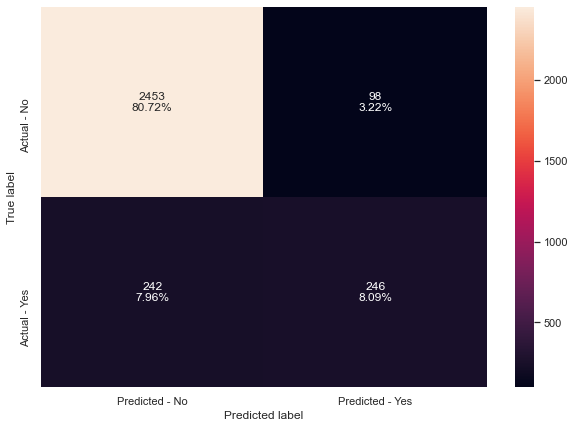

In [98]:
get_metrics_score(lg_base,X_train,X_test,y_train,y_test)
make_confusion_matrix(lg_base,X_test,y_test)

* The accuracy of our model is quite decent ~89% on test data. However, remember that 84% of the customers are Existing Customers, so even a "dumb" model predicting all customers as existing customers would get 84% accuracy.
* Our recall is fairly low, at 50% on test data.
* The model does not appear to be overfitting the data. The training and test metrics are very similar.

### Test Scaling Options
**Standard Scaler**  
We saw during our EDA that the different variables have different scales. We can apply a Standard Scaler to all of the columns to address this and make all the variables (roughly) the same scale. We will test this and see if it improves the results.

**Log Transform on Credit Limit**  
During our EDA we saw that a number of variables were skewed to the right, we also saw that for Credit_Limit and Avg_Open_To_Buy, performing a log transform removed the skewness and transformed the data to a more normal distribution. We have dropped the Avg_Open_To_Buy, so let's attempt to log transform the Credit_Limit variable and see if we get better results. We will perform the log transform before the Standard Scaler is applied.

In [99]:
# Here we will create a separate train and test set that has the log transformed Credit Limit (with original dropped)
# Add a column where the Credit_Limit variable has been log transformed
X_train['Credit_Limit_log']=np.log1p(X_train['Credit_Limit'])
X_test['Credit_Limit_log']=np.log1p(X_test['Credit_Limit'])

# Create a train and test set with only the log transformed Credit_Limit
X_train_experiment = X_train.drop(['Credit_Limit'], axis=1)
X_test_experiment = X_test.drop(['Credit_Limit'], axis=1)

# Drop the log transformed Credit_Limit from the original dataset
X_train.drop(['Credit_Limit_log'], axis=1, inplace=True)
X_test.drop(['Credit_Limit_log'], axis=1, inplace=True)

### Test Set Up: Stratified K-Fold Cross Validation
We will be using a Stratified K-Fold Cross Validation to test the results. This way we can look at the effect of changing the inputs without touching the test data. There is a possibility that we would pick a set of inputs that, by chance, happened to fit the test data. This would lead to models that work well on our particular test data but not in production in general. To avoid this we will use cross validation.

In [100]:
def run_cv(model, X_data,y_data):
    scoring='recall'
    kfold=StratifiedKFold(n_splits=10,shuffle=True,random_state=1)     #Setting number of splits equal to 10
    cv_result_bfr=cross_val_score(estimator=model, X=X_data, y=y_data, scoring=scoring, cv=kfold)
    #Plotting boxplots for CV scores of model defined above
    plt.boxplot(cv_result_bfr)
    plt.show()
    print('Mean recall',cv_result_bfr.mean())
    print('Max recall',cv_result_bfr.max())    

#### Test Log Transform on Credit Limit

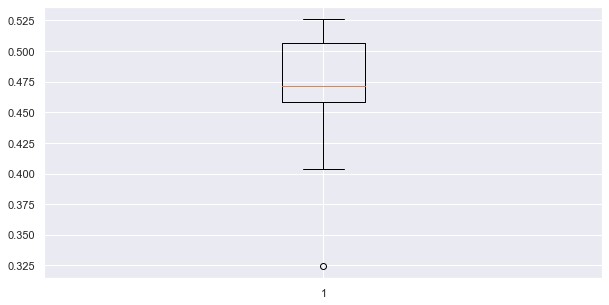

Mean recall 0.4644465145163795
Max recall 0.5263157894736842


In [101]:
lg_test1 = LogisticRegression(random_state=1)  
lg_test1.fit(X_train_experiment,y_train)
run_cv(lg_test1,X_train_experiment,y_train)

#### Test applying Standard Scaler To All Variables

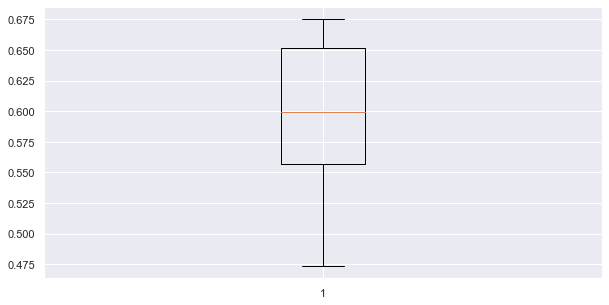

Mean recall 0.5961419034311443
Max recall 0.6754385964912281


In [102]:
lg_test2 = make_pipeline(StandardScaler(), LogisticRegression(random_state=1))
lg_test2.fit(X_train, y_train)
run_cv(lg_test2,X_train,y_train)

#### Test applying Log Transform to Credit Limit and then Standard Scaler to All Variables

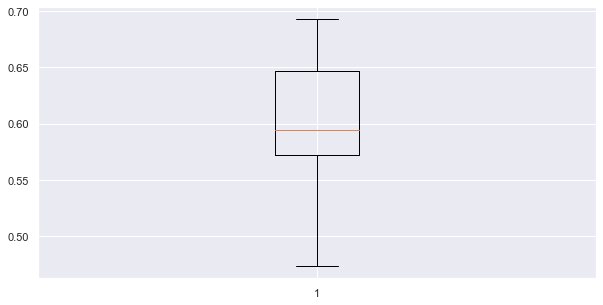

Mean recall 0.5970113336438441
Max recall 0.6929824561403509


In [103]:
lg_test3 = make_pipeline(StandardScaler(), LogisticRegression(random_state=1))
lg_test3.fit(X_train_experiment, y_train)
run_cv(lg_test3,X_train_experiment,y_train)

* When we just apply the log transform to Credit Limit, the mean recall is below our baseline test, the max recall is above.
* Applying the standard scalar to all columns provides a large boost to the recall score compared to the baseline model.
* Applying both the log transform to Credit Limit and the standard scalar to all columns gave the best results, with mean and max recall slightly higher than using the standard scalar alone.

Let's compare our best results (using log transfrom and standard scalar) to the baseline model with unscaled inputs using the test data.

### Model Performance using Scaled Input Data

In [104]:
# Get metrics of Logistic Regression model using scaled inputs.
get_metrics_score(lg_test3,X_train_experiment,X_test_experiment,y_train,y_test)
print()

Accuracy on training set :  0.9071670428893905
Accuracy on test set :  0.9108259295820994
Recall on training set :  0.5987708516242318
Recall on test set :  0.6127049180327869
Precision on training set :  0.7723669309173273
Precision on test set :  0.7847769028871391
F1 on training set :  0.6745796241345203
F1 on test set :  0.6881472957422324



* We see an increase in all metrics, compared to the baseline, when the Logistic Regression model is trained on scaled data.
* Test recall increased from 0.50 to 0.61 after scaling
* We will use the scaled data as input moving forward. We can apply the log transform now as it is simply a mathematic transform. We will keep the standard scalar as part of our pipeline to avoid data leakage.

**We will alter the training data such that it contains the Log Transformed Credit_Limit Column**

In [105]:
# Copy the datasets with the log transformed Credit Limit column to X_train and X_test.
# This is just to keep naming conventions and avoid confusion when running future models.
X_train = X_train_experiment.copy()
X_test = X_test_experiment.copy()

### Oversampling train data using SMOTE
As our target variable is unbalanced, we will try to add synthetic data points to the minority class when training the model, to attempt to improve model performance.

In [106]:
print("Before UpSampling, counts of label 'Attrited': {}".format(sum(y_train==1)))
print("Before UpSampling, counts of label 'Existing': {} \n".format(sum(y_train==0)))

sm = SMOTE(sampling_strategy = 1 ,k_neighbors = 5, random_state=1)   #Synthetic Minority Over Sampling Technique
X_train_over, y_train_over = sm.fit_resample(X_train, y_train)


print("After UpSampling, counts of label 'Attrited': {}".format(sum(y_train_over==1)))
print("After UpSampling, counts of label 'Existing': {} \n".format(sum(y_train_over==0)))


print('After UpSampling, the shape of train_X: {}'.format(X_train_over.shape))
print('After UpSampling, the shape of train_y: {} \n'.format(y_train_over.shape))

Before UpSampling, counts of label 'Attrited': 1139
Before UpSampling, counts of label 'Existing': 5949 

After UpSampling, counts of label 'Attrited': 5949
After UpSampling, counts of label 'Existing': 5949 

After UpSampling, the shape of train_X: (11898, 20)
After UpSampling, the shape of train_y: (11898,) 



We have increased the number of Attrited Customer samples in the dataset using SMOTE such that they equal the number of Existing Customer samples.

#### Evaluate Logistic Regression Performance using UpSampled Data
We will now run a Stratified 10-Fold Stratified Cross Validation to see if our recall score has improved after upsampling the minority class in the target variable.

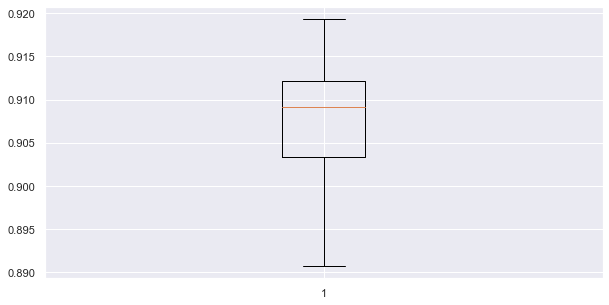

Mean recall 0.9078838808250573
Max recall 0.9193277310924369


In [107]:
lg_over = make_pipeline(StandardScaler(), LogisticRegression(random_state=1))
lg_over.fit(X_train_over, y_train_over)
run_cv(lg_over,X_train_over,y_train_over)

* We see a large increase in the recall scores coming out of our CV test. The previous mean recall, before UpSampling, was 0.597. It's now up to 0.908.
* Let's see how the model does on our test data.

### Model Performance after training on UpSampled Data

Accuracy on training set :  0.9114977307110439
Accuracy on test set :  0.8756169792694966
Recall on training set :  0.908219868885527
Recall on test set :  0.735655737704918
Precision on training set :  0.9142131979695431
Precision on test set :  0.5904605263157895
F1 on training set :  0.9112066784720466
F1 on test set :  0.6551094890510949


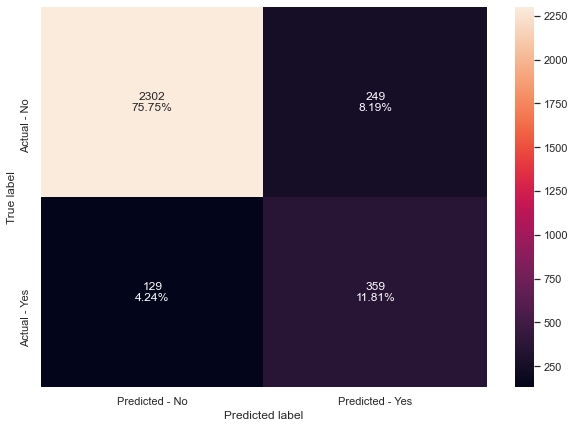

In [108]:
#Calculating different metrics
get_metrics_score(lg_over,X_train_over,X_test,y_train_over,y_test)

# creating confusion matrix
make_confusion_matrix(lg_over,X_test,y_test)

* The test accuracy has fallen slightly (0.911 down to 0.876), while the test recall has increased significantly (0.613 up to 0.736)
* The model now appears overfit to the training data, as training metrics are much better than test metrics.
* We can try to regularize this model and see if that improves the test metrics.

### Regularize Logistic Regression Model Using UpSampled Data
We will still use our UpSampled data when training the model. We will also perform a GridSearch to look for the optimum regularization parameters.

In [109]:
# Choose the type of classifier. 
pipe = make_pipeline(StandardScaler(), LogisticRegression(random_state=1))

# Grid of parameters to choose from
parameters = {'logisticregression__C': np.arange(0.1,1.1,0.1)}

# Run the grid search
grid_obj = GridSearchCV(pipe, parameters, scoring='recall', n_jobs=-1)
grid_obj = grid_obj.fit(X_train_over, y_train_over)

# Set the clf to the best combination of parameters
lg_over_reg = grid_obj.best_estimator_

# Fit the best algorithm to the data. 
lg_over_reg.fit(X_train_over, y_train_over)

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('logisticregression',
                 LogisticRegression(C=0.2, random_state=1))])

* The GridSearch has chosen C as 0.2. Given that the possible range was 0.1-1.1 and 1 means no regularization, the GridSearch has chosen to add a strong regulaization to the model.

### Model Performance after training on UpSampled Data and Regularization

Accuracy on training set :  0.9120020171457388
Accuracy on test set :  0.876604146100691
Recall on training set :  0.9090603462766852
Recall on test set :  0.735655737704918
Precision on training set :  0.9144403111261413
Precision on test set :  0.5933884297520661
F1 on training set :  0.9117423923122313
F1 on test set :  0.6569075937785911


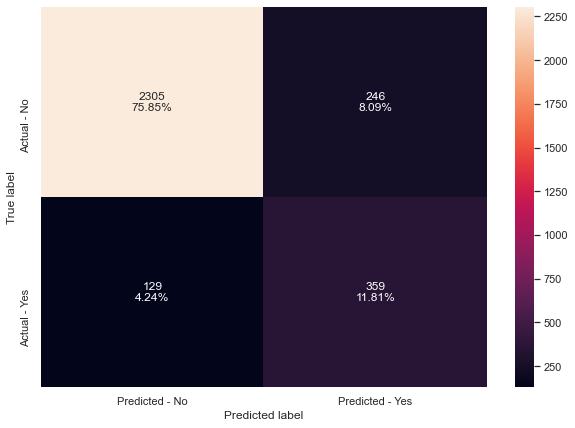

In [110]:
#Calculating different metrics
get_metrics_score(lg_over_reg,X_train_over,X_test,y_train_over,y_test)

# creating confusion matrix
make_confusion_matrix(lg_over_reg,X_test,y_test)

* Regularizing the model has had a slight effect on some of the metrics. E.g. test accuracy is 0.876 before and 0.877 after.
* Test recall score has not changed as a result of the regularization.
* Perhaps the difference in metrics between the training and test metrics is due to the fact that the training target is balanced while the test target data are still very unbalanced.
* Despite the large difference between training and test data metrics. UpSampling the model has improved our test recall compared to the data before UpSampling.

### Undersampling train data using RandomUnderSampler
Above we attempted to balance the classes in the target variable by creating synthetic data points in the minority class. Now we will attempt to balance the data by removing samples of the majority class.

In [111]:
rus = RandomUnderSampler(random_state = 1)
X_train_un, y_train_un = rus.fit_resample(X_train, y_train)

In [112]:
print("Before Under Sampling, counts of label 'Attrited': {}".format(sum(y_train==1)))
print("Before Under Sampling, counts of label 'Existing': {} \n".format(sum(y_train==0)))

print("After Under Sampling, counts of label 'Attrited': {}".format(sum(y_train_un==1)))
print("After Under Sampling, counts of label 'Existing': {} \n".format(sum(y_train_un==0)))

print('After Under Sampling, the shape of train_X: {}'.format(X_train_un.shape))
print('After Under Sampling, the shape of train_y: {} \n'.format(y_train_un.shape))

Before Under Sampling, counts of label 'Attrited': 1139
Before Under Sampling, counts of label 'Existing': 5949 

After Under Sampling, counts of label 'Attrited': 1139
After Under Sampling, counts of label 'Existing': 1139 

After Under Sampling, the shape of train_X: (2278, 20)
After Under Sampling, the shape of train_y: (2278,) 



We have randomly dropped samples from the majority class until the number of samples for each class is balanced.

#### Evaluate Logistic Regression Performance using Down Sampled Data
We will now run a Stratified 10-Fold Cross Validation to see if our recall score has improved after down sampling the majority class in the target variable.

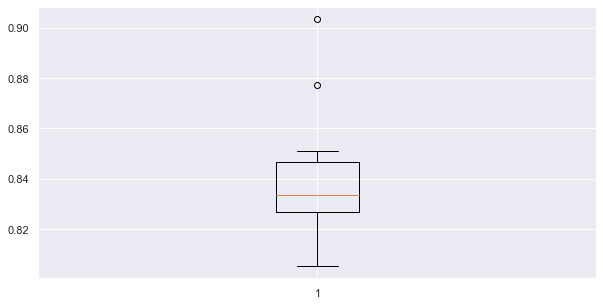

Mean recall 0.8419344822232573
Max recall 0.9035087719298246


In [113]:
lg_under = make_pipeline(StandardScaler(), LogisticRegression(random_state=1))
lg_under.fit(X_train_un, y_train_un)
run_cv(lg_under,X_train_un,y_train_un)

* The mean recall is lower, compared to when we ran the CV on the upsampled data. Max recall is about the same.
* Mean and max recall are significantly higher than Logistic Regression with no up or down sampling.

### Model Performace after training on DownSampled Data

Accuracy on training set :  0.8419666374012291
Accuracy on test set :  0.8420533070088845
Recall on training set :  0.8446005267778753
Recall on test set :  0.8422131147540983
Precision on training set :  0.840174672489083
Precision on test set :  0.504914004914005
F1 on training set :  0.8423817863397548
F1 on test set :  0.6313364055299538


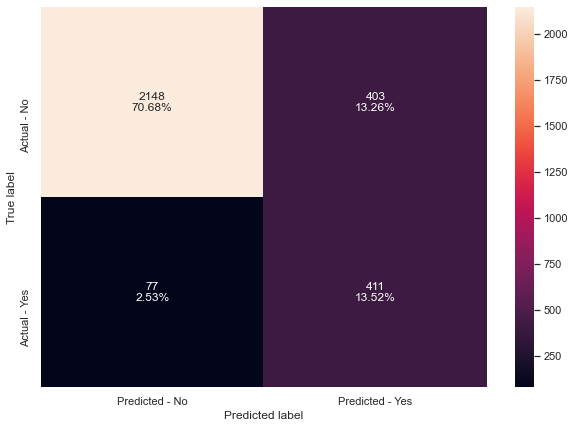

In [114]:
#Calculating different metrics
get_metrics_score(lg_under,X_train_un,X_test,y_train_un,y_test)

# creating confusion matrix
make_confusion_matrix(lg_under,X_test,y_test)

* After training the Logistic Regression Model on the DownSampled training data, we have achieved our best test recall score so far: 0.842 up from 0.735 (nearest competitor model, lg_over). We will compare all models at the end of this section.

### Regularize Logistic Regression Model Using DownSampled Data
Given that the Logistic Regression trained on the DownSampled data does not appear to be overfitting, it's not technically necessary to attempt to regularize the model. However, a) it's not hard to do b) it could be part of the project mark that I don't want to miss out on.  
We will use GridSearch again to attempt to find the optimum regularization parameter.

In [115]:
# Choose the type of classifier. 
lg_under_reg = make_pipeline(StandardScaler(), LogisticRegression(random_state=1))

# Grid of parameters to choose from
parameters = {'logisticregression__C': np.arange(0.1,1.1,0.1)}

# Run the grid search
grid_obj = GridSearchCV(pipe, parameters, scoring='recall', n_jobs=-1)
grid_obj = grid_obj.fit(X_train_un, y_train_un)

# Set the clf to the best combination of parameters
lg_under_reg = grid_obj.best_estimator_

# Fit the best algorithm to the data. 
lg_under_reg.fit(X_train_over, y_train_over)

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('logisticregression',
                 LogisticRegression(C=0.30000000000000004, random_state=1))])

* The GridSearch has chosen C as 0.3. Given that the possible range was 0.1-1 and 1 means no regularization, the GridSearch has chosen to add a strong regulaization to the model.

### Model Performance after training on DownSampled Data and Regularization

Accuracy on training set :  0.820017559262511
Accuracy on test set :  0.8762750904902928
Recall on training set :  0.7251975417032485
Recall on test set :  0.735655737704918
Precision on training set :  0.894907908992416
Precision on test set :  0.5924092409240924
F1 on training set :  0.8011639185257032
F1 on test set :  0.656307129798903


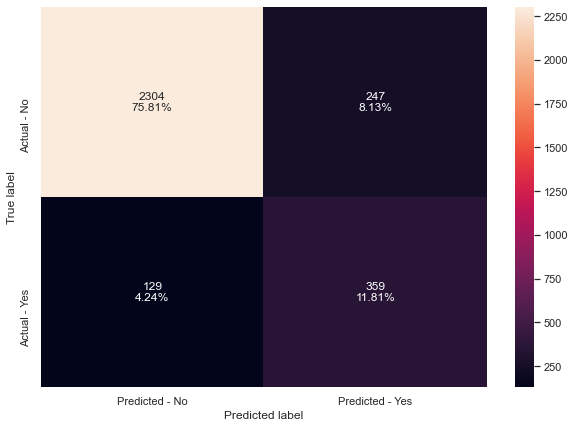

In [116]:
#Calculating different metrics
get_metrics_score(lg_under_reg,X_train_un,X_test,y_train_un,y_test)

# creating confusion matrix
make_confusion_matrix(lg_under_reg,X_test,y_test)

* Model performance drops when we attempt to regularize the model. Test Accuracy has increased slightly 0.842 to 0.876, however test recall has fallen 0.842 to 0.736.

## Comparison of all Logistic Regression Models

In [117]:
# defining list of models
# models that use the default X_training set NOTE:default means Credit_Limit has log transform and standard scalar is applied.
models = [lg_test3]

# models that use the UpSampled data: X_train_over, y_train_over
models2 = [lg_over, lg_over_reg]

# models that use the DownSampled data: X_train_un, y_train_un
models3 = [lg_under, lg_under_reg]

# defining empty lists to add train and test results
acc_train = []
acc_test = []
recall_train = []
recall_test = []
precision_train = []
precision_test = []
f1_train = [] 
f1_test = []

# looping through all the models to get the metrics score - Accuracy, Recall, Precision, F1-Score
# First models with default data
for model in models:
    
    j = get_metrics_score(model, X_train, X_test, y_train, y_test, flag=False)
    acc_train.append(j[0])
    acc_test.append(j[1])
    recall_train.append(j[2])
    recall_test.append(j[3])
    precision_train.append(j[4])
    precision_test.append(j[5])
    f1_train.append(j[6])
    f1_test.append(j[7])
    
# Now models with UpSampled data

for model in models2:
    
    j = get_metrics_score(model, X_train_over, X_test, y_train_over, y_test, flag=False)
    acc_train.append(j[0])
    acc_test.append(j[1])
    recall_train.append(j[2])
    recall_test.append(j[3])
    precision_train.append(j[4])
    precision_test.append(j[5])
    f1_train.append(j[6])
    f1_test.append(j[7])
    
    
# Finally loop through the models with DownSampled data

for model in models3:
    
    j = get_metrics_score(model, X_train_un, X_test, y_train_un, y_test, flag=False)
    acc_train.append(j[0])
    acc_test.append(j[1])
    recall_train.append(j[2])
    recall_test.append(j[3])
    precision_train.append(j[4])
    precision_test.append(j[5])
    f1_train.append(j[6])
    f1_test.append(j[7])

In [118]:
comparison_frame1 = pd.DataFrame({'Model':['LG_Base Model','LG_UpSampled','LG_UpSampled with Reg','LG_DownSampled','LG_DownSampled with Reg'], 
                                          'Train_Accuracy': acc_train,'Test_Accuracy': acc_test,
                                          'Train_Recall':recall_train,'Test_Recall':recall_test,
                                          'Train_Precision':precision_train,'Test_Precision':precision_test,
                                           'Train_F1-Score':f1_train, 'Test_F1-Score':f1_test}) 

#Sorting models in decreasing order of test recall
comparison_frame1.sort_values(by='Test_Recall',ascending=False)

Model  Train_Accuracy  Test_Accuracy  Train_Recall  \
3           LG_DownSampled        0.841967       0.842053      0.844601   
1             LG_UpSampled        0.911498       0.875617      0.908220   
2    LG_UpSampled with Reg        0.912002       0.876604      0.909060   
4  LG_DownSampled with Reg        0.820018       0.876275      0.725198   
0            LG_Base Model        0.907167       0.910826      0.598771   

   Test_Recall  Train_Precision  Test_Precision  Train_F1-Score  Test_F1-Score  
3     0.842213         0.840175        0.504914        0.842382       0.631336  
1     0.735656         0.914213        0.590461        0.911207       0.655109  
2     0.735656         0.914440        0.593388        0.911742       0.656908  
4     0.735656         0.894908        0.592409        0.801164       0.656307  
0     0.612705         0.772367        0.784777        0.674580       0.688147

* The table above shows all the logistic regression models, ranked by Test Recall score.
* We can see that the model trained on the DownSampled data performed the best on the test data set. This model had the highest test recall while also maintaining comparable accuracy and precision scores to the other models.

# ---------------------------------------------------------------------------------------------------------------

# Model building - Bagging and Boosting
*Build Decision tree, random forest, bagging classifier models - Build Xgboost, AdaBoost, and gradient boosting models*

In this section we are moving on from Logistic Regression and building ensemble-method-based models. We will start buy building all the models, testing their performance using a Stratified K-Fold Cross Validation and then moving on to tune the best 3.

In [119]:
models = []  # Empty list to store all the models

# Appending pipelines for each model into the list
models.append(
    (
        "DTREE",
         Pipeline(steps=[
             ("scaler", StandardScaler()),
             ("decision_tree", DecisionTreeClassifier(random_state=1))]
                 )
    )
)
models.append(
    (
        "RF",
         Pipeline(steps=[
             ("scaler", StandardScaler()),
             ("random_forest", RandomForestClassifier(random_state=1))]
                 )
    )
)
models.append(
    (
        "BAG",
         Pipeline(steps=[
             ("scaler", StandardScaler()),
             ("bagging", BaggingClassifier(random_state=1))]
                 )
    )
)
models.append(
    (
        "XGB",
         Pipeline(steps=[
             ("scaler", StandardScaler()),
             ("xgboost", XGBClassifier(random_state=1,eval_metric='logloss'))]
                 )
    )
)
models.append(
    (
        "ADB",
         Pipeline(steps=[
             ("scaler", StandardScaler()),
             ("adaboost", AdaBoostClassifier(random_state=1))]
                 )
    )
)
models.append(
    (
        "GBM",
         Pipeline(steps=[
             ("scaler", StandardScaler()),
             ("gradient_boosting", GradientBoostingClassifier(random_state=1))]
                 )
    )
)




results = []  # Empty list to store all model's CV scores
names = []  # Empty list to store name of the models

# loop through all models to get the mean cross validated score
for name, model in models:
    scoring = "recall"
    kfold = StratifiedKFold(
        n_splits=5, shuffle=True, random_state=1
    )  # Setting number of splits equal to 5
    cv_result = cross_val_score(
        estimator=model, X=X_train, y=y_train, scoring=scoring, cv=kfold
    )
    results.append(cv_result)
    names.append(name)
    print("{}: {}".format(name, cv_result.mean() * 100))

DTREE: 80.42159363165624
RF: 78.57639693948528
BAG: 80.15611716515959
XGB: 87.09251101321586
ADB: 81.82664811809259
GBM: 82.26253960893423


The boosting methods XGBoost, AdaBoost, GradientBoost, have the 3 highest mean recall scores in our cross validation test. Let's look at all the scores in boxplots:

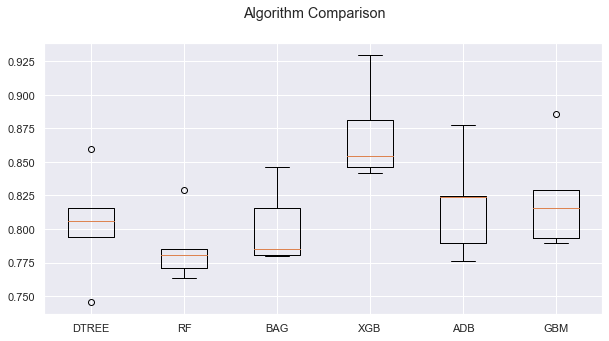

In [120]:
# Plotting boxplots for CV scores of all models defined above
fig = plt.figure()

fig.suptitle("Algorithm Comparison")
ax = fig.add_subplot(111)

plt.boxplot(results)
ax.set_xticklabels(names)

plt.show()

* XGBoost is clearly the best performing algorithm of the ones tested with the highest mean, median and max.
* We saw above the that boosting algorithms have the highest mean recall values, the boxplot shows that they also have higher median and max values than the other methods.
* We will move forward with the three boosting algorithms: XGBoost, AdaBoost and GradientBoost.

# Hyperparameter tuning using grid search and random search
*Tune the best 3 models using grid search and provide the reason behind choosing those models - Use pipelines in hyperparameter tuning*

#### Note 
* Previously I have been following the order of the tasks in the Scoring Rubric. I will break from that structure a little bit here as I want to perform the GridSearch and RandomSearch on each model in turn - rather than perform 3 Grid Searches *then* 3 Random Searches.  
* Furthermore, I will be performing the RandomSearch first. The reason for this is:  
    - "...for most data sets only a few of the hyper-parameters really matter, but that different hyper-parameters are important on different data sets. This phenomenon makes grid search a poor choice for configuring algorithms for new data sets." - Bergstra, 2012
* As we don't know the hyperparameter space, or which hyperparameters are important, it makes sense to perform the RandomSearch first (over a wider hyperparameter space) and *then* perform the GridSearch to fine tune the hyperparameters.

I will use RandomizedSearchCV and GridSearchCV to tune XGBoost, then AdaBoost, then GradientBoost. The reason that I have chosen these three algorithms is because they had the best mean, median and max recall scores in the cross validation test run above.

## XGBoost Tuning

### RandomSearch
We will use RandomSearch first to search a large parameter space quickly. You can see in the cell below that we are entering a large number of options for the RandomSearch to choose from. Just the first parameter alone (n_estimators=np.arange(50,300,1)) is 250 different options. If we had entered this into a grid search, combined with the other parameters, it would never be finished! Using RandomSearch first will help to quickly map out the parameter space, I can then perform a GridSearch over a much smaller parameter space in a region of the parameter space RandomSearch has shown performs well.

In [121]:
%%time
#Creating pipeline
pipe=make_pipeline(StandardScaler(),XGBClassifier(random_state=1,eval_metric='logloss'))

#Parameter grid to pass in RandomizedSearchCV
param_grid={'xgbclassifier__n_estimators':np.arange(50,300,1), 
            'xgbclassifier__scale_pos_weight':np.arange(0.5,12,0.5),
            'xgbclassifier__eta':np.arange(0.01,1,0.01), #aka learning rate default=0.3 pos.range=0-1. higher = more conservative
            'xgbclassifier__gamma':np.arange(0,100,1), #default = 0 pos.range=0-inf. Higher = more conservative
            'xgbclassifier__subsample':[0.7,0.8,0.9,1], #subsample ratio default=1 pos.range=0-1. Lower to reduce overfitting
            'xgbclassifier__max_depth':np.arange(2,10,1) #max tree depth default=6 pos.range=1-inf
           }

# Type of scoring used to compare parameter combinations
scorer = metrics.make_scorer(metrics.recall_score)

#Calling RandomizedSearchCV
randomized_cv = RandomizedSearchCV(estimator=pipe, param_distributions=param_grid, n_iter=50, scoring=scorer, cv=5, random_state=1, n_jobs=-1)

#Fitting parameters in RandomizedSearchCV
randomized_cv.fit(X_train,y_train)

print("Best parameters are {} with CV score={}:" .format(randomized_cv.best_params_,randomized_cv.best_score_))

Best parameters are {'xgbclassifier__subsample': 0.7, 'xgbclassifier__scale_pos_weight': 11.0, 'xgbclassifier__n_estimators': 66, 'xgbclassifier__max_depth': 2, 'xgbclassifier__gamma': 73, 'xgbclassifier__eta': 0.060000000000000005} with CV score=0.9727838318262618:
Wall time: 54.6 s


* The random search above took about 1 minute. Note that I had some spare time and ran the random search with n_iter=100 and 500 to test for myself what would happen. It returned the same parameters. I deleted those cells to cut down on the time it takes to run this notebook as a whole (and there is no point running the RandomSearch for longer just to get the same results).

* The CV recall score is very high. Let's create a model using these parameters and check the results against the test data.

In [122]:
# Make pipeline using the best parameters found in the RandomSearchCV
XGB_rand_best = make_pipeline(
    StandardScaler(),
    XGBClassifier(eval_metric='logloss',
                  random_state=1,
                  subsample=0.7,
                  scale_pos_weight=11.0,
                  n_estimators=66,
                  max_depth=2,
                  gamma=73,
                  eta=0.6)
)

# Fit the model on the training data
XGB_rand_best.fit(X_train, y_train)

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('xgbclassifier',
                 XGBClassifier(base_score=0.5, booster='gbtree',
                               colsample_bylevel=1, colsample_bynode=1,
                               colsample_bytree=1, eta=0.6,
                               eval_metric='logloss', gamma=73, gpu_id=-1,
                               importance_type='gain',
                               interaction_constraints='',
                               learning_rate=0.600000024, max_delta_step=0,
                               max_depth=2, min_child_weight=1, missing=nan,
                               monotone_constraints='()', n_estimators=66,
                               n_jobs=12, num_parallel_tree=1, random_state=1,
                               reg_alpha=0, reg_lambda=1, scale_pos_weight=11.0,
                               subsample=0.7, tree_method='exact',
                               validate_parameters=1, verbosity=None))]

### XGBoost Model Performance after hyperparameter tuning using RandomSearch

Accuracy on training set :  0.9092832957110609
Accuracy on test set :  0.8996380388285621
Recall on training set :  0.9841966637401229
Recall on test set :  0.9672131147540983
Precision on training set :  0.6420389461626576
Precision on test set :  0.6202365308804205
F1 on training set :  0.7771230502599653
F1 on test set :  0.755804643714972


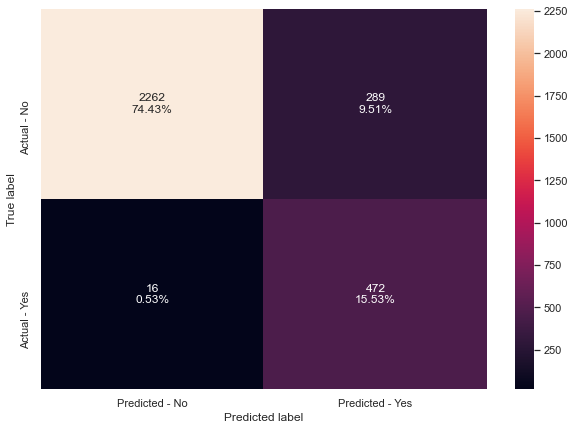

In [123]:
get_metrics_score(XGB_rand_best,X_train,X_test,y_train,y_test)
make_confusion_matrix(XGB_rand_best,X_test,y_test)

* The test recall score is very high: 0.967
* Only 16 Attrited Customers have been misclassified by the model, 0.53%
* Other metrics are also very good, the highest that we have seen so far.
* The model does not appear to be overfitting as the training and test metrics are very similar.

### XGBoost GridSearch
Now that we have narrowed down our hyperparameter space using RandomSearch, we can fine tune the hyperparameters using GridSearch.

In [124]:
%%time
#Creating pipeline
pipe=make_pipeline(StandardScaler(),XGBClassifier(random_state=1,eval_metric='logloss'))

#Parameter grid to pass in RandomizedSearchCV
param_grid={'xgbclassifier__n_estimators':[60,63,66,69,72], 
            'xgbclassifier__scale_pos_weight':[10,11,12],
            'xgbclassifier__eta':[0.55,0.6,0.65], #aka learning rate default=0.3 pos.range=0-1. higher = more conservative
            'xgbclassifier__gamma':[70,71,72,73,74,75,76], #default = 0 pos.range=0-inf. Higher = more conservative
            'xgbclassifier__subsample':[0.6,0.7,0.8], #subsample ratio default=1 pos.range=0-1. Lower to reduce overfitting
            'xgbclassifier__max_depth':[1,2,3] #max tree depth default=6 pos.range=1-inf
           }

# Type of scoring used to compare parameter combinations
scorer = metrics.make_scorer(metrics.recall_score)

# Calling GridSearchCV
grid_cv = GridSearchCV(estimator=pipe, param_grid=param_grid, scoring=scorer, cv=5, n_jobs=-1)

# Fitting parameters in GridSeachCV
grid_cv.fit(X_train, y_train)

print("Best parameters are {} with CV score={}:".format(grid_cv.best_params_, grid_cv.best_score_))

Best parameters are {'xgbclassifier__eta': 0.55, 'xgbclassifier__gamma': 76, 'xgbclassifier__max_depth': 2, 'xgbclassifier__n_estimators': 60, 'xgbclassifier__scale_pos_weight': 12, 'xgbclassifier__subsample': 0.7} with CV score=0.9736687533812505:
Wall time: 8min 11s


* Despite the fact that the parameter space for the GridSearch was much smaller, it took much longer to run (~9x longer).
* The GridSearch has chosen slighlty different parameters to the RandomSearch, many of these parameters are at the edge of the range that we specified, inicating that we could continue to refine our search for optimum hyperparameters. However, given that this project has a deadline, I am going to cap the hyperparmater search here.

Let's create a new model using the best parameters from the GridSearch and evaluate it using our test data.

In [125]:
# Make pipeline using the best parameters found in the GridSearchCV
XGB_grid_best = make_pipeline(
    StandardScaler(),
    XGBClassifier(eval_metric='logloss',
                  random_state=1,
                  subsample=0.7,
                  scale_pos_weight=12.0,
                  n_estimators=60,
                  max_depth=2,
                  gamma=76,
                  eta=0.55)
)

# Fit the model on the training data
XGB_grid_best.fit(X_train, y_train)

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('xgbclassifier',
                 XGBClassifier(base_score=0.5, booster='gbtree',
                               colsample_bylevel=1, colsample_bynode=1,
                               colsample_bytree=1, eta=0.55,
                               eval_metric='logloss', gamma=76, gpu_id=-1,
                               importance_type='gain',
                               interaction_constraints='',
                               learning_rate=0.550000012, max_delta_step=0,
                               max_depth=2, min_child_weight=1, missing=nan,
                               monotone_constraints='()', n_estimators=60,
                               n_jobs=12, num_parallel_tree=1, random_state=1,
                               reg_alpha=0, reg_lambda=1, scale_pos_weight=12.0,
                               subsample=0.7, tree_method='exact',
                               validate_parameters=1, verbosity=None))

### XGBoost Model Performance after hyperparameter tuning using GridSearch

Accuracy on training set :  0.9015237020316027
Accuracy on test set :  0.8881210924646266
Recall on training set :  0.9833187006145742
Recall on test set :  0.9631147540983607
Precision on training set :  0.622568093385214
Precision on test set :  0.5934343434343434
F1 on training set :  0.762423417290674
F1 on test set :  0.734375


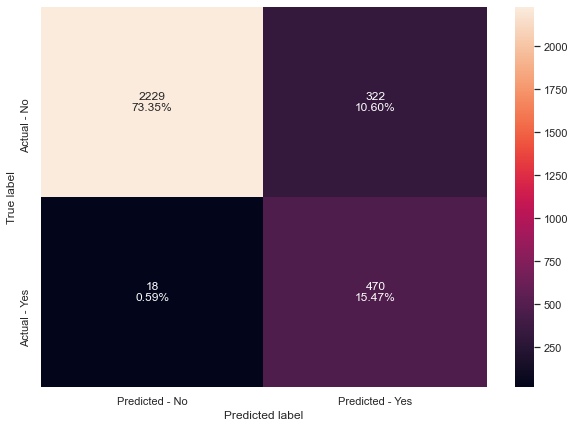

In [126]:
get_metrics_score(XGB_grid_best,X_train,X_test,y_train,y_test)
make_confusion_matrix(XGB_grid_best,X_test,y_test)

* Despite the fact that GridSearch took longer to run AND was searching exhaustively around a small subset of parameters known to perform well, the results from the GridSearch are actually WORSE!
* All test data metrics have worsened compared to the RandomSearch results. Test recall has dropped from 0.967 to 0.963.

## AdaBoost Tuning

### RandomSearch
We will use RandomSearch first for the same reasons as before: We can search a wider parameter space quickly and then attempt to hone the search using GridSearch.

In [127]:
%%time
#Creating pipeline
pipe=make_pipeline(StandardScaler(),AdaBoostClassifier(random_state=1))

#Parameter grid to pass in RandomizedSearchCV
param_grid={
    #Let's try different max_depth for base_estimator, we will also experiment with class_weight
    "adaboostclassifier__base_estimator":[DecisionTreeClassifier(max_depth=1, class_weight={0:0.16,1:0.84}, random_state=1),
                                          DecisionTreeClassifier(max_depth=2, class_weight={0:0.16,1:0.84}, random_state=1),
                                          DecisionTreeClassifier(max_depth=3, class_weight={0:0.16,1:0.84}, random_state=1),
                                          DecisionTreeClassifier(max_depth=1, random_state=1),
                                          DecisionTreeClassifier(max_depth=2, random_state=1),
                                          DecisionTreeClassifier(max_depth=3, random_state=1)],
    "adaboostclassifier__n_estimators": np.arange(10,300,1), #default =50
    "adaboostclassifier__learning_rate":np.arange(0.01,1.5,0.01) #default=1 smaller values decrease overfitting
           }

# Type of scoring used to compare parameter combinations
scorer = metrics.make_scorer(metrics.recall_score)

#Calling RandomizedSearchCV
randomized_cv = RandomizedSearchCV(estimator=pipe, param_distributions=param_grid, n_iter=50, scoring=scorer, cv=5, random_state=1, n_jobs=-1)

#Fitting parameters in RandomizedSearchCV
randomized_cv.fit(X_train,y_train)

print("Best parameters are {} with CV score={}:" .format(randomized_cv.best_params_,randomized_cv.best_score_))

Best parameters are {'adaboostclassifier__n_estimators': 58, 'adaboostclassifier__learning_rate': 0.3, 'adaboostclassifier__base_estimator': DecisionTreeClassifier(class_weight={0: 0.16, 1: 0.84}, max_depth=2,
                       random_state=1)} with CV score=0.9367995981142283:
Wall time: 47.2 s


* At n_iter=50 the RandomSearch took about 45 seconds.
* The CV recall score is good, let's create a model using the best parameters and evaluate the model using the test data.

In [128]:
AB_rand_best = make_pipeline(StandardScaler(),
                              AdaBoostClassifier(random_state=1,
                                                base_estimator=DecisionTreeClassifier(max_depth=2, class_weight={0:0.16,1:0.84}, random_state=1),
                                                n_estimators=58,
                                                learning_rate=0.3)
                             )

AB_rand_best.fit(X_train,y_train)

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('adaboostclassifier',
                 AdaBoostClassifier(base_estimator=DecisionTreeClassifier(class_weight={0: 0.16,
                                                                                        1: 0.84},
                                                                          max_depth=2,
                                                                          random_state=1),
                                    learning_rate=0.3, n_estimators=58,
                                    random_state=1))])

### AdaBoost Model Performance after hyperparameter tuning using RandomSearch

Accuracy on training set :  0.9597911963882618
Accuracy on test set :  0.9470220467258966
Recall on training set :  0.9692712906057945
Recall on test set :  0.9405737704918032
Precision on training set :  0.8153618906942393
Precision on test set :  0.7766497461928934
F1 on training set :  0.8856799037304453
F1 on test set :  0.8507877664504171


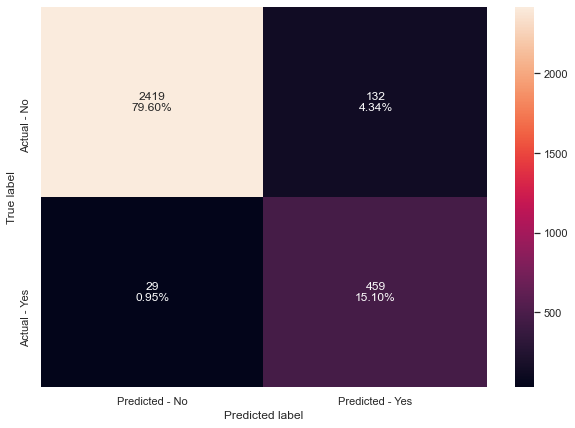

In [129]:
get_metrics_score(AB_rand_best,X_train,X_test,y_train,y_test)
make_confusion_matrix(AB_rand_best,X_test,y_test)

* Metrics for training and test data are similar indicating that model is generalizing well.
* Test recall is very good at 0.941, however this model is slighly outperformed by the XGBoost model (test recall = 0.967)
* Test accuracy, precision and F1-Score are better on this model compared to best XGBoost model.

### AdaBoost GridSearch
Now that we have narrowed down our hyperparameter space using RandomSearch, we can fine tune the hyperparameters using GridSearch. We will keep the base_estimator the same, this will allow us to cut down on time while exporing a slightly wider range of possibilities for the other parameters.

In [130]:
%%time
#Creating pipeline
pipe=make_pipeline(StandardScaler(),
                   AdaBoostClassifier(random_state=1, 
                                      base_estimator=DecisionTreeClassifier(max_depth=2,
                                                                            class_weight={0:0.16,1:0.84},
                                                                            random_state=1))
                  )

#Parameter grid to pass in GridSearchCV
param_grid={
   "adaboostclassifier__n_estimators": np.arange(38,78,2), #default =50 RndSeach gave 58
    "adaboostclassifier__learning_rate":np.arange(0.1,0.45,0.05) #default=1 RndSeach gave 0.3
           }

# Type of scoring used to compare parameter combinations
scorer = metrics.make_scorer(metrics.recall_score)

# Calling GridSearchCV
grid_cv = GridSearchCV(estimator=pipe, param_grid=param_grid, scoring=scorer, cv=5, n_jobs=-1)

# Fitting parameters in GridSeachCV
grid_cv.fit(X_train, y_train)

print("Best parameters are {} with CV score={}:".format(grid_cv.best_params_, grid_cv.best_score_))

Best parameters are {'adaboostclassifier__learning_rate': 0.20000000000000004, 'adaboostclassifier__n_estimators': 66} with CV score=0.9429399489914214:
Wall time: 47.9 s


* The parameters chosen are within the ranges that we specified and the CV score has increased slightly from our RandomSearchCV, this indicates that we have the best set of parameters possible, or at least reached a local maximum for recall in the parameter space. Let's test that on the test data.

In [131]:
AB_grid_best=make_pipeline(StandardScaler(),
                           AdaBoostClassifier(random_state=1, 
                                              base_estimator=DecisionTreeClassifier(max_depth=2,
                                                                                    class_weight={0:0.16,1:0.84},
                                                                                    random_state=1),
                                             learning_rate=0.2,
                                             n_estimators=66)
                          )
AB_grid_best.fit(X_train,y_train)

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('adaboostclassifier',
                 AdaBoostClassifier(base_estimator=DecisionTreeClassifier(class_weight={0: 0.16,
                                                                                        1: 0.84},
                                                                          max_depth=2,
                                                                          random_state=1),
                                    learning_rate=0.2, n_estimators=66,
                                    random_state=1))])

### AdaBoost Model Performance after hyperparameter tuning using GridSearch

Accuracy on training set :  0.9534424379232506
Accuracy on test set :  0.947680157946693
Recall on training set :  0.9683933274802459
Recall on test set :  0.944672131147541
Precision on training set :  0.7895490336435218
Precision on test set :  0.7774030354131535
F1 on training set :  0.8698738170347003
F1 on test set :  0.8529139685476411


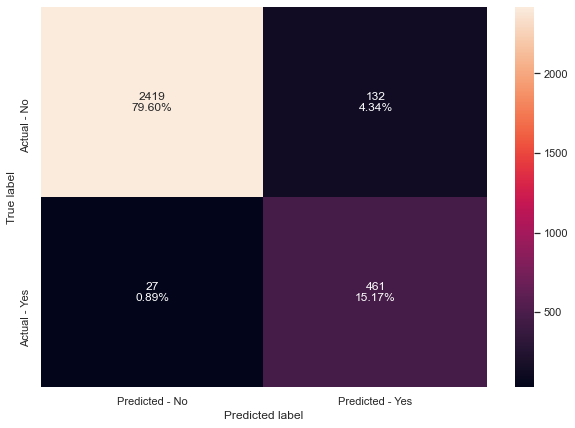

In [132]:
get_metrics_score(AB_grid_best,X_train,X_test,y_train,y_test)
make_confusion_matrix(AB_grid_best,X_test,y_test)

* After further refining our parameter search using GridSearch, all metrics have improved compared to the AdaBoost RandomSearch
* Test recall has increased from 0.941 to 0.945
* All other increases are similarly small, on the order of 0.001.
* We were able to see an improvement with our GridSearch. 
* The RandomSearch and GridSearch took about the same time, 0.75 mins, although the GridSearch was over a much smaller parameter space.

## GradientBoosting Tuning

### RandomSearch
We will again be using our methodology of using RandomSearch over a large parameter space and then attempting to hone the parameters using GridSearch.

In [133]:
%%time
#Creating pipeline
pipe=make_pipeline(StandardScaler(),GradientBoostingClassifier(random_state=1))

#Parameter grid to pass in RandomizedSearchCV
param_grid={
    "gradientboostingclassifier__n_estimators": np.arange(10,300,1), #default =100
    "gradientboostingclassifier__learning_rate":np.arange(0.01,1.5,0.01), #default=0.1 smaller values decrease overfitting
    "gradientboostingclassifier__subsample":np.arange(0.5,1,0.05), #fraction of samples used for fitting individual base learners default=1
    "gradientboostingclassifier__max_depth":np.arange(1,7,1), #max depth of base learner DTrees default=3
    "gradientboostingclassifier__max_features":['auto','log2',0.6,0.7,0.8,'None'] #max features for best split default=None
           }

# Type of scoring used to compare parameter combinations
scorer = metrics.make_scorer(metrics.recall_score)

#Calling RandomizedSearchCV
randomized_cv = RandomizedSearchCV(estimator=pipe, param_distributions=param_grid, n_iter=50, scoring=scorer, cv=5, random_state=1, n_jobs=-1)

#Fitting parameters in RandomizedSearchCV
randomized_cv.fit(X_train,y_train)

print("Best parameters are {} with CV score={}:" .format(randomized_cv.best_params_,randomized_cv.best_score_))

Best parameters are {'gradientboostingclassifier__subsample': 0.8000000000000003, 'gradientboostingclassifier__n_estimators': 242, 'gradientboostingclassifier__max_features': 0.8, 'gradientboostingclassifier__max_depth': 6, 'gradientboostingclassifier__learning_rate': 0.67} with CV score=0.8604297086328156:
Wall time: 29.8 s


Given that the random search was so fast, only 29 seconds. Let's change the random state of the RandomizedSearchCV and increase the number of iterations to 500 and see what happens.

In [134]:
%%time

#Calling RandomizedSearchCV, random state has been changed so we don't repeat the random path taken before. n_iter has been doubled
randomized_cv = RandomizedSearchCV(estimator=pipe, param_distributions=param_grid, n_iter=500, scoring=scorer, cv=5, random_state=42, n_jobs=-1)

#Fitting parameters in RandomizedSearchCV
randomized_cv.fit(X_train,y_train)

print("Best parameters are {} with CV score={}:" .format(randomized_cv.best_params_,randomized_cv.best_score_))

Best parameters are {'gradientboostingclassifier__subsample': 0.9500000000000004, 'gradientboostingclassifier__n_estimators': 241, 'gradientboostingclassifier__max_features': 'auto', 'gradientboostingclassifier__max_depth': 3, 'gradientboostingclassifier__learning_rate': 0.55} with CV score=0.876219182317026:
Wall time: 4min 25s


* Changing the random state and number of iterations has lead to a large change in the hyperparameter values.
* The parameters from the larger search lead to a better result and are likely more 'trustworthy' as more of the parameter space has been sampled. We will create a model using these parameters and evaluate it against the test data.

In [135]:
GB_rand_best = make_pipeline(StandardScaler(),
                              GradientBoostingClassifier(random_state=1,
                                                         subsample=0.95,
                                                         n_estimators=241,
                                                         max_features='auto',
                                                         max_depth=3,
                                                         learning_rate=0.55)
                            )
                            

GB_rand_best.fit(X_train,y_train)

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('gradientboostingclassifier',
                 GradientBoostingClassifier(learning_rate=0.55,
                                            max_features='auto',
                                            n_estimators=241, random_state=1,
                                            subsample=0.95))])

### GradientBoosting Model Performance after hyperparameter tuning using RandomSearch

Accuracy on training set :  1.0
Accuracy on test set :  0.9697268838433696
Recall on training set :  1.0
Recall on test set :  0.889344262295082
Precision on training set :  1.0
Precision on test set :  0.9194915254237288
F1 on training set :  1.0
F1 on test set :  0.9041666666666667


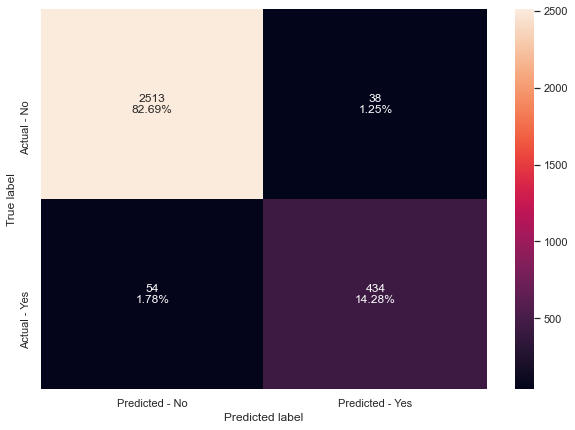

In [136]:
get_metrics_score(GB_rand_best,X_train,X_test,y_train,y_test)
make_confusion_matrix(GB_rand_best,X_test,y_test)

* We can see that the recall on the test data approximately matches that of the recall score in the RandomizedSearchCV, about 0.88.
* The model appears to be overfit to the training data; all metrics are equal to 1, a perfect model. This is unrealistic and indicates that we need to reduce variance in the model, i.e. the model is fitting noise.
* Let's run a GridSearch and see if we can improve the results.

### GradientBoosting GridSearch
Now that we have narrowed down our hyperparameter space using RandomSearch, we can fine tune the hyperparameters using GridSearch. We ran the RandomSearch 2 times, both times the n_estimators parameter was ~240, so let's fix that parameter. We will also fix the max_depth at 3. This is the default value and we want to keep this relatively low to reduce variance in the model.

In [137]:
%%time
#Creating pipeline
pipe=make_pipeline(StandardScaler(),
                   GradientBoostingClassifier(random_state=1,
                                             n_estimators=240,
                                             max_depth=3))

#Parameter grid to pass in RandomizedSearchCV
param_grid={
    "gradientboostingclassifier__learning_rate":np.arange(0.05,0.6,0.05), #default=0.1 RndSearch returned 0.55
    "gradientboostingclassifier__subsample":np.arange(0.5,1,0.05), #default=1 RndSearch returned 0.95, lower values decrease variance
    "gradientboostingclassifier__max_features":['auto',0.6,0.8,'None'] #max features for best split default=None
           }

# Type of scoring used to compare parameter combinations
scorer = metrics.make_scorer(metrics.recall_score)

# Calling GridSearchCV
grid_cv = GridSearchCV(estimator=pipe, param_grid=param_grid, scoring=scorer, cv=5, n_jobs=-1)

# Fitting parameters in GridSeachCV
grid_cv.fit(X_train, y_train)

print("Best parameters are {} with CV score={}:".format(grid_cv.best_params_, grid_cv.best_score_))

Best parameters are {'gradientboostingclassifier__learning_rate': 0.45, 'gradientboostingclassifier__max_features': 'auto', 'gradientboostingclassifier__subsample': 0.8000000000000003} with CV score=0.8788546255506609:
Wall time: 4min 56s


* The learning rate and subsample have decreased compared to our RandomSearchCV. Both of these are indications that the variance has reduced in this model. In addition the CV recall score has increased. 
* The parameters chosen lie within the range we specified, rather than at the min/max, so it's likely that we have the best set of parameters. 
* Let's evaluate this against the test data.

In [138]:
GB_grid_best = make_pipeline(StandardScaler(),
                              GradientBoostingClassifier(random_state=1,
                                                         subsample=0.8,
                                                         n_estimators=240,
                                                         max_features='auto',
                                                         max_depth=3,
                                                         learning_rate=0.45)
                            )
                            

GB_grid_best.fit(X_train,y_train)

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('gradientboostingclassifier',
                 GradientBoostingClassifier(learning_rate=0.45,
                                            max_features='auto',
                                            n_estimators=240, random_state=1,
                                            subsample=0.8))])

### GradientBoosting Model Performance after hyperparameter tuning using GridSearch

Accuracy on training set :  1.0
Accuracy on test set :  0.970714050674564
Recall on training set :  1.0
Recall on test set :  0.889344262295082
Precision on training set :  1.0
Precision on test set :  0.9253731343283582
F1 on training set :  1.0
F1 on test set :  0.9070010449320794


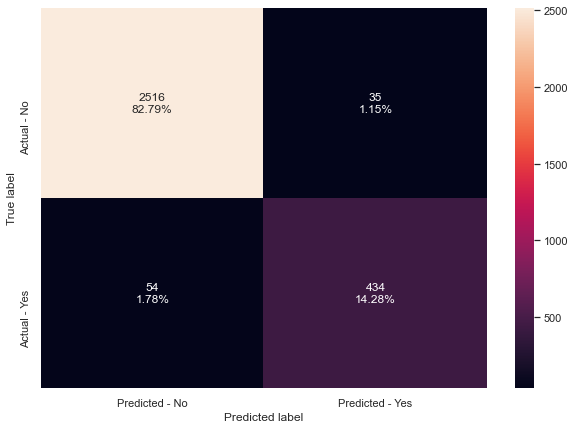

In [139]:
get_metrics_score(GB_grid_best,X_train,X_test,y_train,y_test)
make_confusion_matrix(GB_grid_best,X_test,y_test)

* The overfitting issue has not gone away dispite the fact that we have decreased variance in the model by decreasing learning rate and subsample percentage.
* There is an increase in all test metrics compared to the RandomSearch (in the order of 0.001). Recall has not changed.
* This model is giving a very high test accuracy, precision and F1-Score - the highest scores we have seen so far. If GradientBoosting had a parameter like class_weight we could perhaps increase the recall, while dropping precision. As we don't have a class_weight parameter, the model is likely favoring the majority class, leading to a high precision but a lower recall. 


**While we don't have a class_weight/scale_pos_weight parameter for GradientBoosting, we can attempt to fit the model using our Up and Down Sampled data, where the class proportions are balanced**

### Test Tuned GB Model, fitting on UpSampled and DownSampled Data

In [140]:
#train our best GB model using UpSampled Data
GB_grid_best_over = make_pipeline(StandardScaler(),
                              GradientBoostingClassifier(random_state=1,
                                                         subsample=0.8,
                                                         n_estimators=240,
                                                         max_features='auto',
                                                         max_depth=3,
                                                         learning_rate=0.45)
                            )
                            

GB_grid_best_over.fit(X_train_over,y_train_over)

#train our best GB model using DownSampled Data
GB_grid_best_under = make_pipeline(StandardScaler(),
                              GradientBoostingClassifier(random_state=1,
                                                         subsample=0.8,
                                                         n_estimators=240,
                                                         max_features='auto',
                                                         max_depth=3,
                                                         learning_rate=0.45)
                            )
                            

GB_grid_best_under.fit(X_train_un,y_train_un)

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('gradientboostingclassifier',
                 GradientBoostingClassifier(learning_rate=0.45,
                                            max_features='auto',
                                            n_estimators=240, random_state=1,
                                            subsample=0.8))])

In [141]:
print('Metrics for Tuned GB fit on UpSampled Data \n')
get_metrics_score(GB_grid_best_over,X_train_over,X_test,y_train_over,y_test)
print('\n')
print('Metrics for Tuned GB fit on DownSampled Data \n')
get_metrics_score(GB_grid_best_under,X_train_un,X_test,y_train_un,y_test)
print()

Metrics for Tuned GB fit on UpSampled Data 

Accuracy on training set :  1.0
Accuracy on test set :  0.9680816057913787
Recall on training set :  1.0
Recall on test set :  0.9159836065573771
Precision on training set :  1.0
Precision on test set :  0.8886679920477137
F1 on training set :  1.0
F1 on test set :  0.9021190716448033


Metrics for Tuned GB fit on DownSampled Data 

Accuracy on training set :  1.0
Accuracy on test set :  0.9450477130635078
Recall on training set :  1.0
Recall on test set :  0.9528688524590164
Precision on training set :  1.0
Precision on test set :  0.7635467980295566
F1 on training set :  1.0
F1 on test set :  0.8477666362807658



* The test recall using the DownSampled data is slightly better than when using the UpSampled data. The remaining points in this cell refer to the DownSampled data.


* By training the model on data with balanced classes in the target varaible, we have been able to improve the test recall of the model. Test recall is now 0.953, up from 0.889. The trade-off is that model accuracy and precision drop. Given that we are more interested in minimizing false negatives, this is a trade-off that we can make.
* The model still overfits training data, despite the different number of samples in the DownSampled data.
* Given that this is our best GradientBoosting model, let's print out the metrics and confusion matrix in the same format we have done for the other models:

### GradientBoosting Model Performance - hyperparameter tuned and trained on UpSampled Data

Accuracy on training set :  1.0
Accuracy on test set :  0.9450477130635078
Recall on training set :  1.0
Recall on test set :  0.9528688524590164
Precision on training set :  1.0
Precision on test set :  0.7635467980295566
F1 on training set :  1.0
F1 on test set :  0.8477666362807658


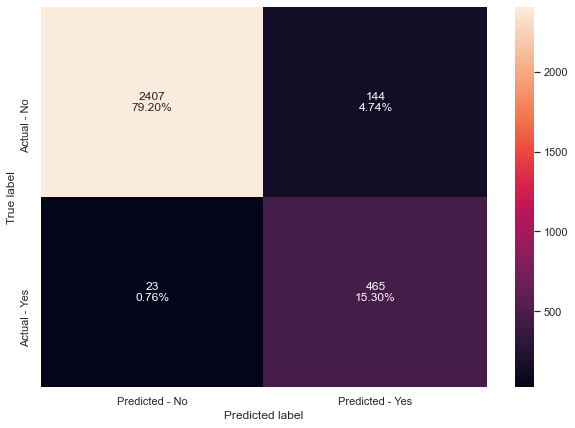

In [142]:
get_metrics_score(GB_grid_best_under,X_train_un,X_test,y_train_un,y_test)
make_confusion_matrix(GB_grid_best_under,X_test,y_test)

* The model above has the same hyperparameters as the model tuned using the GridSearch. However, fitting the model on the DownSampled data has allowed us to increase the recall, for a slight drop in accuracy/precision.
* The number of false negatives in this model is 23 (0.76%), compare this to 54 (1.78%) in the model fit on unbalanced data.

# ---------------------------------------------------------------------------------------------------------------
# Model Performances
*Compare the model performance of all the models - Comment on the time taken by the grid and randomized search in optimization*

In [143]:
# defining list of models
# models that use the default X_training set NOTE:default means Credit_Limit has log transform and standard scalar is applied.
models = [XGB_rand_best, XGB_grid_best, AB_rand_best, AB_grid_best, GB_rand_best, GB_grid_best]

# models that use the DownSampled data: X_train_un, y_train_un
models2 = [GB_grid_best_under]


# defining empty lists to add train and test results
acc_train = []
acc_test = []
recall_train = []
recall_test = []
precision_train = []
precision_test = []
f1_train = [] 
f1_test = []

# looping through all the models to get the metrics score - Accuracy, Recall, Precision, F1-Score
# First models with default data
for model in models:
    
    j = get_metrics_score(model, X_train, X_test, y_train, y_test, flag=False)
    acc_train.append(j[0])
    acc_test.append(j[1])
    recall_train.append(j[2])
    recall_test.append(j[3])
    precision_train.append(j[4])
    precision_test.append(j[5])
    f1_train.append(j[6])
    f1_test.append(j[7])
    
# Now models with UpSampled data

for model in models2:
    
    j = get_metrics_score(model, X_train_un, X_test, y_train_un, y_test, flag=False)
    acc_train.append(j[0])
    acc_test.append(j[1])
    recall_train.append(j[2])
    recall_test.append(j[3])
    precision_train.append(j[4])
    precision_test.append(j[5])
    f1_train.append(j[6])
    f1_test.append(j[7])

In [144]:
# Make the comparison frame for the ensemble methods
comparison_frame2 = pd.DataFrame({'Model':['XGB_RndSearch','XGB_GrdSearch','AB_RndSearch','AB_GrdSearch',
                                           'GB_RndSeach','GB_GrdSearch','GB_GrdSearch_DownSample'], 
                                          'Train_Accuracy': acc_train,'Test_Accuracy': acc_test,
                                          'Train_Recall':recall_train,'Test_Recall':recall_test,
                                          'Train_Precision':precision_train,'Test_Precision':precision_test,
                                           'Train_F1-Score':f1_train, 'Test_F1-Score':f1_test}) 

# Add the LG models comparison frame to the ensemble methods
all_models_df = pd.concat([comparison_frame1, comparison_frame2], axis=0, sort=False)

#Sorting models in decreasing order of test recall
all_models_df.sort_values(by='Test_Recall',ascending=False)

Model  Train_Accuracy  Test_Accuracy  Train_Recall  \
0            XGB_RndSearch        0.909283       0.899638      0.984197   
1            XGB_GrdSearch        0.901524       0.888121      0.983319   
6  GB_GrdSearch_DownSample        1.000000       0.945048      1.000000   
3             AB_GrdSearch        0.953442       0.947680      0.968393   
2             AB_RndSearch        0.959791       0.947022      0.969271   
4              GB_RndSeach        1.000000       0.969727      1.000000   
5             GB_GrdSearch        1.000000       0.970714      1.000000   
3           LG_DownSampled        0.841967       0.842053      0.844601   
1             LG_UpSampled        0.911498       0.875617      0.908220   
2    LG_UpSampled with Reg        0.912002       0.876604      0.909060   
4  LG_DownSampled with Reg        0.820018       0.876275      0.725198   
0            LG_Base Model        0.907167       0.910826      0.598771   

   Test_Recall  Train_Precision  Test_Precision  Train_F1-Score  Test_F1-Score  
0     0.967213         0.642039        0.620237        0.777123       0.755805  
1     0.963115         0.622568        0.593434        0.762423       0.734375  
6     0.952869         1.000000        0.763547        1.000000       0.847767  
3     0.944672         0.789549        0.777403        0.869874       0.852914  
2     0.940574         0.815362        0.776650        0.885680       0.850788  
4     0.889344         1.000000        0.919492        1.000000       0.904167  
5     0.889344         1.000000        0.925373        1.000000       0.907001  
3     0.842213         0.840175        0.504914        0.842382       0.631336  
1     0.735656         0.914213        0.590461        0.911207       0.655109  
2     0.735656         0.914440        0.593388        0.911742       0.656908  
4     0.735656         0.894908        0.592409        0.801164       0.656307  
0     0.612705         0.772367        0.784777        0.674580       0.688147

#### Comments on Model Metrics
* The best model, based on our criterion of maximum test recall, is XGBoost with parameters tuned from the RandomizedSearchCV.
* The XGBoost algorithm worked best in general, we saw this in our original kfolds CV and the two top models are XGBoost models.
* The ensemble method models worked better than the logistic regression models, this makes sense given that we don't really have a linear dataset.
* An honerable mention needs to go to the AdaBoost Model, tuned using GridSearch. This model had the highest accuracy and precision (of a non-overfit model) while still maintaining a very high test recall, only 2.2% lower than the XGB_RndSearch model. If we were interested in maximizing accuracy, precission or F1-Score, this would be our best model. However in this particular interest, the cost of a false negative is much higher than that of a false positive, so our preference has to go to the model with the highest test recall score.


#### Comments on RandomizedSearchCV vs. GridSearchCV
* I did the task somewhat out of order according to the Scoring Rubric from this project. It made sense to me to perfrom a RandomizedSearchCV (RandomSearch) over a wide parameter space first and then, once I had some idea of a good hyperparameter set, refine the hyperparameters using a GridSearchCV (GridSearch).
* Because I used this methodology, I got better results using GridSearch for the AdaBoost and GradientBoosting algorithms. For these algorithms, when I ran the GridSearch after the RandomSearch, the best hyperparameter set found was within the range I specified for the GridSearch. So RandomSearch pointed me in the right direction and GridSearch got me to the final destination.
* That said, the improvement on the results was *very* slight. AdaBoost test recall increased by 0.004 and the GradientBoosting test recall didn't increase at all (however test accuracy increased 0.001). Given that I was able to search a much bigger parameter space in less time using RandomSearch, I believe that this is the better method for hyperparameter tuning. If I had just attempted to perform a GridSearch without performing the RandomSearch first, I likely would have needlessly searched a parameter space far away from the optimum parameters and wasted a lot time.
* Ultimately I think that these two tuning methods should be used in the way that I ran them here:
    - On a new dataset, when we have no idea what the hyperparameter space is like, run RandomizedSearchCV over a large range of the parameter space.
    - Once we have have a parameter set from the RandomizedSearchCV, run a GridSearchCV centred around the parameters found in the RandomizedSeachCV to zero-in on the optimum hyperparameter set.
* For the XGBoost hyperparameter search, I ran the RandomSearch using n_iter=50, 100 and 500. However, given that I got the same best hyperparameter set each time, I deleted the cells with n_iter=100 and 500 as I did not want the run time of the full Jupyter Notebook to be increased for no reason.
* That said, I know that I don't have the optimum set of hyperparameters for XGBoost because, when I ran the GridSearch, the parameters chosen by the GridSearch were at the extremes of the range specified and not in the middle. This indicates that there exists a better set of hyperparameters somewhere in the parameter space that the RandomSearch and GridSearch did not cover. However, I do find it strange that the parameter set found by the RandomSearch lies within the ranges set in the GridSearch but for some reason the GridSearch chose a different parameter set that gives worse results.

* **Final Verdict:** the time taken to perform a RandomizedSearchCV depends on the n_iter, but in general, RandomizedSearchCV is much, much faster than GridSearchCV and achieves comparable results to GridSearchCV. In fact, if a RandomizedSearchCV is not performed before a GridSearchCV to give a basic idea of the area of the parameter space in which to search, GridSearchCV will only achieve good results if by great luck the inital parameter grid chosen just happens to be in the correct space.

# Best Model Stats and Feature Importances
Our best model was the XGBoost using hyperparameters found in the RandomSearch. Let's look at our best model once more.

### Metrics and Confusion Matrix

Accuracy on training set :  0.9092832957110609
Accuracy on test set :  0.8996380388285621
Recall on training set :  0.9841966637401229
Recall on test set :  0.9672131147540983
Precision on training set :  0.6420389461626576
Precision on test set :  0.6202365308804205
F1 on training set :  0.7771230502599653
F1 on test set :  0.755804643714972


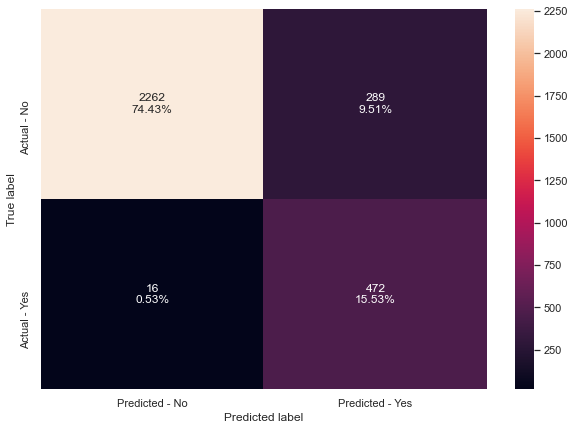

In [145]:
get_metrics_score(XGB_rand_best,X_train,X_test,y_train,y_test)
make_confusion_matrix(XGB_rand_best,X_test,y_test)

* Our model achieves a very high test recall score 96.7%. So off all the customers who Attrited, only 3.3% of them have been incorrectly classified.
* There are only 16 Attrited customers that have been incorrectly classified as Existing customers (i.e. False Negatives) from the total of 3039 customers in the test data. So only 0.53% of customers fall into the false negative bin.
* The model still maintains reasonable accuracy, 90%. There are 289 customers who have been predicted as Attrited but are actually existing customers.

### Feature Importances
Let's look at the feature importances from our best model to gain insight on which of our variables are most important.

                               Imp
Total_Trans_Ct            0.222162
Avg_Utilization_Ratio     0.157953
Total_Relationship_Count  0.113603
Total_Trans_Amt           0.086072
Total_Amt_Chng_Q4_Q1      0.081925
Months_Inactive_12_mon    0.081374
Total_Ct_Chng_Q4_Q1       0.074185
Contacts_Count_12_mon     0.053679
Months_on_book            0.040480
Credit_Limit_log          0.036051
Customer_Age              0.035243
Marital_Status_Married    0.017272
Gender                    0.000000
Card_Category             0.000000
Income_Category           0.000000
Education_Level           0.000000
Dependent_count           0.000000
Revolver_Flag             0.000000
Marital_Status_Single     0.000000
Marital_Status_Unknown    0.000000


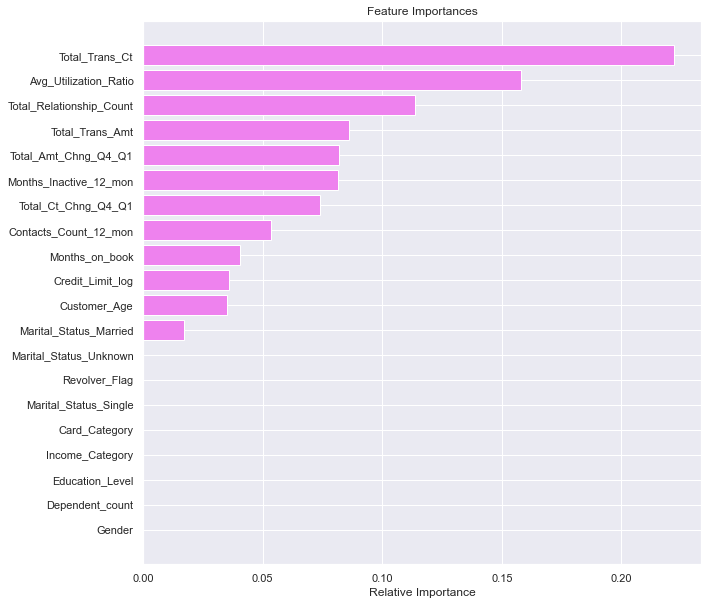

In [146]:
# We can't get the feature importances of a pipeline, so we will need to break the pipe into it's two parts
# in order to extract the feature importances from the XGBoostClassifier

# First get the feature names, as StandardScalar will strip these when it does the transform.
feature_names = list(X_train.columns)

# Instantiate StandardScalar
ss = StandardScaler()
# Fit and Transform training data 
X_train_ss = pd.DataFrame(ss.fit_transform(X_train), columns=feature_names)

XGB_rand_best_ss = XGBClassifier(eval_metric='logloss',
                  random_state=1,
                  subsample=0.7,
                  scale_pos_weight=11.0,
                  n_estimators=66,
                  max_depth=2,
                  gamma=73,
                  eta=0.6)


# Fit the model on the training data
XGB_rand_best_ss.fit(X_train_ss, y_train)

print (pd.DataFrame(XGB_rand_best_ss.feature_importances_, columns = ["Imp"], index = X_train_ss.columns).sort_values(by = 'Imp', ascending = False))

importances = XGB_rand_best_ss.feature_importances_
indices = np.argsort(importances)

plt.figure(figsize=(10,10))
plt.title('Feature Importances')
plt.barh(range(len(indices)), importances[indices], color='violet', align='center')
plt.yticks(range(len(indices)), [feature_names[i] for i in indices])
plt.xlabel('Relative Importance')
plt.show()

* As we saw during our EDA, the customer profile: Gender, Education_Level, Income_Category, Dependent_count, Marital_Status and Age have little to no indicative power on predicting an Existing vs. Attrited Customer. All of these variables have a feature importance of zero.
* We identified during our EDA that customer spending habits were the biggest predictor of attrition, 4 of the top 5 feature importances indicate spending habits.
* The surprise feature with high importance is Total_Relationship_Count, we will explore this more below.
* Our Revolver Flag feature has zero importance, this makes sense given that we dropped the revolving balance column.

#### Observations on Total_Relationship_Ct
As Total_Relationship_Ct was a feature with high importance that we have not expored in the EDA, we will look at it now. We will plot its distribution and then against the other highest importance features, all coloured by our target variable.

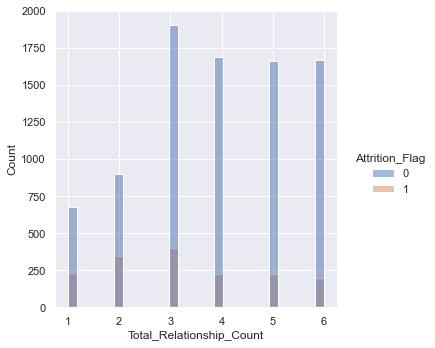

In [147]:
sns.displot(data=df, x='Total_Relationship_Count', hue="Attrition_Flag");

* We can see that as total relationship count goes up the probability of attrition goes down. However there are no areas with zero overlap in Total_Relationship_Ct.

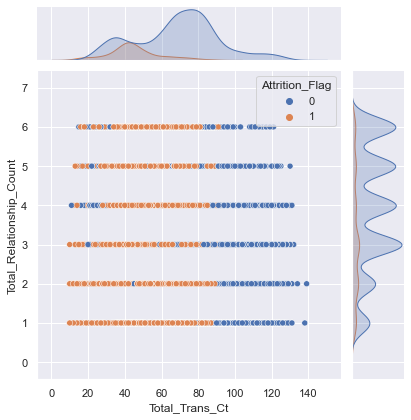

In [148]:
sns.jointplot(data=df, x='Total_Trans_Ct', y='Total_Relationship_Count', hue="Attrition_Flag");

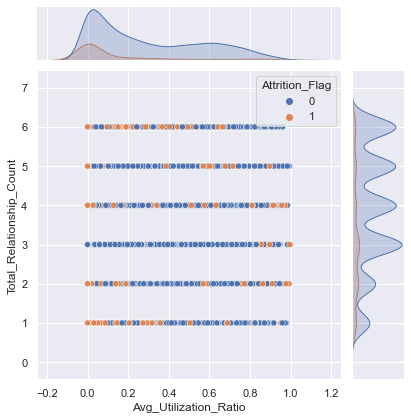

In [149]:
sns.jointplot(data=df, x='Avg_Utilization_Ratio', y='Total_Relationship_Count', hue="Attrition_Flag");

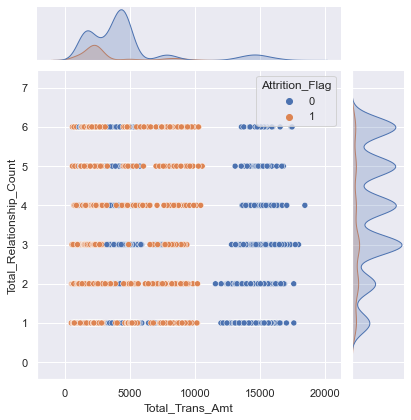

In [150]:
sns.jointplot(data=df, x='Total_Trans_Amt', y='Total_Relationship_Count', hue="Attrition_Flag");

* There are obvious areas of zero overlap (of target variable classes) in the distributions of Total_Trans_Amt and Total_Trans_Ct. In Avg_Utilization_Ratio we can see in the kde part of the plot that, as Avg_Utilization_Ratio goes up the probabillity of attrition drops. 
* Total_Relationship_Ct does not appear, to the naked eye, to be adding much to the pitcure. However, there are undoubtably patterns that the ML algorithm sees that we do not.

# Actionable Insights & Recommendations
*Business recommendations and insights*

First let's restate a pertinent section from the Background and Context:  
"...*the bank wants to analyze the data of customers and identify the customers who will leave their credit card services and reason for same – so that bank could improve upon those areas*"  

We have certainly analyzed the data and we have build a model that predicts very well which customers will leave their credit card services. Our best model had a test recall of 96.7%. Of the 488 customers who did leave their credit card 472 were correctly identified and only 16 misclassified. The model did this while maintaining an overall accuracy of 90%

The bank also wants to identify "reasons" that customers are leaving their credit card services. I don't believe that we have the data to find *reasons* a customer is leaving their credit card, but we certainly have the data to find *indications* a customer will leave their credit card. These are:  

#### Signs indicating a customer will/will not attrite:
* We saw from our EDA and from the feature importances of our best ML model that, there is no particular customer profile that predicts customer attrition. We saw that across Age, Gender, Education Level, Marital Status and Income Category, there was almost no difference in the percentage of Attrited Customers.
* **The biggest predictor of a customer being an Attrited vs. Existing customer is their credit card usage habits**
* The general rule is: As credit card usage increases, chances of attrition decrease. Evidence for this is the following:
    - Total_Trans_Ct: Above 90 chance of attrition is zero, above 60 chance is very low.
    - Total_Trans_Amt: Above ~11,000 chance of attrition is zero, above ~4000 chance is very low
    - Avg_Utilization_Ratio: Above 0.4 chance of attrition is almost zero, above 0.1 chance of attrition drops dramatically.
    - Total_Ct_Chng_Q4_Q1 and Total_Amt_Chng_Q4_Q1: high values in these features indicated lower chance of attrition.
* We saw from our feature importances that Total_Relationship_Ct has high importance. As the number of products held by the customer goes up, the chances of attrition goes down.
* In our EDA we saw that as Contacts_Count_12_mon goes up, so too does the chance of attrition. When the Contacts_Count_12_mon = 6 the chances of attrition are 100%

#### Business Recommendations Based on Above Observations
* The above observations indicate that customers who use their credit card a lot are less likely to leave their credit card. This makes intuitive sense. In order to reduce churn, the bank should attempt to drive credit card usage. Perhaps they could offer lower interest rates to customers who exceed a certain transaction amount or number of transactions each month. The bank could offer reward points based on credit card spending to reward high usage (this is a common strategy employed by credit card companies).

* There are also indications in the data that, the happier a customer is with the bank, the less likely they are to attrite. 
    - This is based on the assumption that the more products the customer has with the bank, the happier they are with the banks services as a whole (we saw that as Total_Relationship_Ct increase, chance of attrition decreases).
    - Also, as the Contacts_Count_12_mon goes up so to does the chance of attrition. Given the relationship between Contacts_Count_12_mon and attrition, we can assume that the customer is contacting the bank to complain. Once the number of complaints = 6, the customer leaves the credit card. It would benefit the bank to really talk to the customers who contact the bank – especially multiple times – and find out what their issues are, and to solve these issues. 
* The recommendation here is to treat customers well in general, so that they are more likely to open more products with the bank and sort out their issues when they contact the bank, so that they don’t need to contact the bank multiple times.

All of the above boils down to: Make a product that is easy/rewarding to use and have good customer service. This is the most basic of business guidelines but with good reason. Often the most basic things are the most important and that appears to be the case here.